In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from matplotlib.backends.backend_pdf import PdfPages
from itertools import permutations
from scipy.interpolate import BSpline
sns.set()
from sklearn.preprocessing import StandardScaler

In [61]:
# Function to imort file or files from a local folder
def import_file(folder_path = "folder_name"):
    
    """
    This function will import the CSV file from the HDExaminer into the environment from a local folder.
    
    Parameter:
    ----------
    folder_path: str, name of the folder containing the CSV file. 
    
    output:
    -------
    a dataframe
    
    """
    for file in os.listdir(folder_path):    
        if file.endswith(".csv"):    
            filepath = os.path.join(folder_path, file)   
    df = pd.read_csv(filepath)
    return df

In [62]:
class HDX(object):
    
    def __init__(self, df, states_list, pep_map = None):
        
        """
        The function of this class is to preproces the CSV file extracted from HDExaminer so
        the processed dataframe can be used to create various kind of plots including scatter,
        line, bar, bubble, heatmap and others. The states_list is a list of protein states in 
        the CSV file. These states could be WT and its mutants or a protein with different substrate
        complexes such apo, binary, ternary and so on. 
        This class will preprocess all the states found in the "Protein State" column in the csv file.
        
        parameters:
        ----------
        df: a dataframe of the CSV file which ws generated using the above "import_file" function. 
        states_list: list, a list of of the state names. The total number of states in the state_list
                    has to match with that in the CSV file.
        pep_map: dictinary, a dictionary of domain names and the corresponding region in the protein.
        
        
        output:
        -------
        a dataframe. 
        
        """
        if pep_map==None:   
            self.pep_map = {"WED I": range(1, 25), 
                   "REC 1": range(25, 340),
                   "REC 2": range(340, 592),
                   "WED II": range(592, 663),
                   "PI": range(663, 763),
                   "WED III": range(763, 893),
                   "RuvC I": range(893, 954),
                   "BH": range(954, 972),
                   "RuvC II": range(972, 1079),
                   "Nuc": range(1079, 1255),
                   "RuvC III": range(1255, 1301)}

            self.domain_color_mapper = {'REC 1': "silver", "REC 2": "gray",
                              'WED I':"hotpink",'WED II':"hotpink",'WED III':"hotpink",
                              "PI":"red", "BH":"deeppink", "Nuc":"yellow",
                              'RuvC I':"blue",'RuvC II':"blue",'RuvC III':"blue"}
        else:
            self.pep_map = pep_map
            self.domain_color_mapper = {'REC 1': "silver", "REC 2": "gray",'WEDGE':"hotpink",
                              "PI":"red", "BH":"deeppink", "Nuc":"yellow", 'RuvC':"blue"}
    

        
        self.states_list = states_list
        self.df = df

    def rename_states(self):
        
        """
        It returns the dataframe with the name of states provided. 

        """
        # Number of states in the protein state column in  the csv file
        states = self.df['Protein State'].unique()
        state_renames ={}

        # Mapping the current and the new names as key values
        for st, stls in zip(states, self.states_list):
            state_renames[st] =stls
            
        # Renaming the states    
        self.df["Protein State"] = self.df['Protein State'].replace(state_renames, inplace=False)

        return self.df


    def organize(self):

        """
        This functin will organize all the states in the data frame
        so that individual states can be plotted efficiently. It returns a dataframe.

        """
        # Updating the df using rename_states function with the default parameters
        #so that the current function can be used independently.
        df = self.rename_states()
        
        # List of states in the csv file.
        states = df['Protein State'].unique().tolist()
        
        # Now separating each protein state as an individulat dataframe and collecting it as list under frames.
        frames =[]

        for state in states:
            state = df[df['Protein State']==state]
            frames.append(state)

        # Renaming states needed to join the abovedata frames horizontally.
        renamed_states =[]
        for state in states:
            state = "_"+ state
            renamed_states.append(state)
            
        common_columns = ['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD'] 
        col_to_rename=['#D', '%D', 'Conf Interval (#D)', '#Pts', 'Confidence', 'Stddev', 'p']   
        all_columns =[]
        for state in states:
            for column in col_to_rename:
                col = column + "_" +state
                all_columns.append(col)
        all_columns = common_columns + all_columns

        # Combining all dataframes(each individual states) in the frames.
        df = reduce(lambda left,right: pd.merge(left,right,
                                                on=['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD'],
                                                how='outer'), frames)
        df = df.drop([col for col in df.columns if col.startswith("Protein")], axis =1)
        df.columns = all_columns

        return df

    def pre_process(self):
        
        """
        This function will generate multiple columns. Each column will have 
        different type of naming for each peptides. For example, the peps column
        will contain the peptide number,its unique index number, the start and end of the sequence.
        This will be highly benificial to indentify peptides in a plot. It also
        reindexes the dataframe by the unique peptide numbers. 
        It returns a dataframe.
        """
        
        df = self.organize()

        # indexing unique peptides from 1.
        idx = range(1,1+len([i for i in df['Sequence'].unique()]))

        idx_dict = {idx: i for (idx, i) in zip(idx, df['Sequence'].unique())}

        df['idx_pep'] = [idx for idx, pep in idx_dict.items() for p in df['Sequence'] if p == pep]

        # New Column containg the unique index number and the start and end of the sequence

        df['idx']= df['idx_pep'].astype("str") + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # New Column containg the peptides, its unique index number and the start and end of the sequence

        df['peps'] = df['idx_pep'].astype("str").apply(
            lambda x: x + ". "
        ) + df['Sequence'] + df.Start.astype("str").apply(
            lambda x: " (" + x + "-"
        ) + df.End.astype("str").apply(
            lambda x: x + ")"
        )

        # setting the idx_pep column as the index of the dataframe
        df.index = df['idx_pep']

        df = df.rename({"idx":"idx1"}, axis = 1)
        df.index.names = ["idx"]
        # Adding column whoso values correspond to timepoints as t1, t2, t3....
        
        timepoints = df['Deut Time (sec)'].unique()
        
        timepoint_names=[]
        for timepoint in range(1, len(timepoints) +1):
            timepoint_names.append("t" + str(timepoint))
            
        timepoint_map={}    
        for timpoint, timepoint_name in zip(timepoints, timepoint_names):
            timepoint_map[timpoint]=timepoint_name

        df['timepoint_map'] = df['Deut Time (sec)']
        df['timepoint_map'] = df["timepoint_map"].map(timepoint_map)
        
        return df
    
    def state_diff(self):
        """ 
        This function names the column that 
        will be generated from the vectorized operations.
        
        """
        
        state_combinations = [list(tup) for tup in permutations(self.states_list, 2)]
        state_combinations= [("_").join(st) for st in state_combinations]
        
        return state_combinations
    
    def state_diff_error(self):
        
        """
        This function names the column that 
        will be generated from the vectorized operations,
        
        """
        
        # performing a perumation of all states and adding "std" in the each of the combinations, which will represent errors
        state_combinations_std = [list(tup) + ["std"] for tup in permutations(self.states_list, 2)]
        state_combinations_std = [("_").join(st) for st in state_combinations_std]
            
        return state_combinations_std
    
    def state_diff_ci(self):
        
        """
        This function names the column that 
        will be generated from the vectorized operations,
        
        """
        # performing a perumation of all states and adding "ci" in the each of the combinations, which will represent confidence interval
        state_combinations_ci = [list(tup) + ["ci"] for tup in permutations(self.states_list, 2)]
        state_combinations_ci = [("_").join(st) for st in state_combinations_ci]
            
        return state_combinations_ci

    
    def domains_mapping(self):
        
        """
        The pep_map is a dictionary mapping peptides sequence 
        number to the respective domains name.
        It returns the data frmae with a column, named "domain",
        whose values are the mapped domain names of the protein.
        
        """
        df = self.pre_process()
        
        # Creating list of Start numbers from the "Start" Column
        start = list(df.Start)

        # Creating list of End numbers from the "End" Column
        end = list(df.End)

        # Creating a list mapping the start and end numbers to its domain names of the protein using the pep_map Dictionary
        domain_by_start_sequence = []
        for domain, domain_range in self.pep_map.items():
            for domain_sequence in domain_range:
                for start_number in start:
                    if start_number == domain_sequence:
                        domain_by_start_sequence.append(domain)

        domain_by_end_sequence = []        
        for end_number in end:
            for domain, domain_range in self.pep_map.items():
                for domain_sequence in domain_range:

                    if end_number == domain_sequence:
                        domain_by_end_sequence.append(domain)

        # Finding the peptides and its indexes that shares multiple domains.
        overlapped_peptides =[]
        print(overlapped_peptides)
        overlapped_peptides_indices = []

        for (idx_start, start), (idx_end,end) in zip(
            enumerate(domain_by_start_sequence ),enumerate(domain_by_end_sequence)):
            if start!=end:
                overlapped_peptides.append((start, end))
                overlapped_peptides_indices.append(idx_start)


                 # now renaming those peptides interms of what overlapping domains they belong to 
                overlapped_peptides_renames =[]            
                for start_domain,end_domain in overlapped_peptides:
                    start_end = start_domain+" - "+end_domain
                    overlapped_peptides_renames.append(start_end)

                domain_by_start_end_sequence = domain_by_start_sequence.copy()
                #Finally replacing those overlapping peps names in "sts" list with the new names
                for (idx_overlapped_peptides, peptide )in zip(
                    overlapped_peptides_indices, overlapped_peptides_renames):
                    domain_by_start_end_sequence[idx_overlapped_peptides] = peptide

        # Creating a new column in the data frame with domain name
        df["domains"] = domain_by_start_end_sequence
        df["domains_start"] = domain_by_start_sequence
        df["domains_end"] = domain_by_end_sequence
        
        # A column with a concatenated peptides' names and their domains'names.
        df["pepsdmn"] = df.peps.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
        df["idxdmn"] = df.idx1.apply(lambda x: x + " (") + df.domains.apply(lambda x: x + ")")
        
        df["color"] = df.domains_start.apply(lambda x: self.domain_color_mapper[x] )
                
        return df
    
    def cal_diff(self):
        
        """ This function calculates the difference in uptakes of D between states"""
        
        sts_comb = list(permutations(self.states_list, 2))
        
        # Making new columns named i showing the differences among multiple states 
        
        df = self.domains_mapping()
        
        for i, j in zip(self.state_diff(), sts_comb):
            
            df[i] = df["#D_" + j[0]] - df["#D_" + j[1]]
            
            df[i + "_%D"] = df["%D_" + j[0]] - df["%D_" + j[1]]
            
        # Making new columns named i for the respective errors using standard error propagation rules    
        
        for i, j in zip(self.state_diff_error(), sts_comb):
                
            df[i] = (df["Stddev_" + j[0]]**2 + df["Stddev_" + j[1]]**2).apply(np.sqrt)

        for i, j in zip(self.state_diff_ci(), sts_comb):
                
            df[i] = (df["Conf Interval (#D)_" + j[0]]**2 + df["Conf Interval (#D)_" + j[1]]**2).apply(np.sqrt)
            
        df.to_csv("Processed_HDX_file.csv")
            
        return df

### First, import the CSV file and porvide a list of states.

In [63]:
df = pd.read_csv("Uptake_Summary_Table10152018.csv")
states_list = ["Apo", "Binary", "Ternary(ss)", "Ternary(ds)"]

# Instantiate the class
hdx = HDX(df, states_list)
df =hdx.cal_diff()

cf = df.copy()

[]


In [64]:
df.head()

Start  End Sequence  Deut Time (sec)  maxD  #D_Apo  %D_Apo  \
idx                                                               
1        7   13  FVNKYSL               10     5   0.733  14.663   
1        7   13  FVNKYSL              120     5   1.372  27.439   
1        7   13  FVNKYSL              600     5   2.316  46.326   
1        7   13  FVNKYSL             1800     5   2.945  58.909   
1        7   13  FVNKYSL             7200     5   2.907  58.136   

     Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                    
1                     0.122       3.0         Medium   
1                     1.287       2.0         Medium   
1                     0.921       3.0         Medium   
1                     0.213       2.0         Medium   
1                     1.207       3.0         Medium   

                ...              Apo_Ternary(ds)_ci  Binary_Apo_ci  \
idx             ...                                                  
1               ...                        0.782568       0.358403   
1               ...                        1.293251       1.288902   
1               ...                        0.928276       0.947613   
1               ...                        2.488134       0.300521   
1               ...                        1.323517       1.251299   

     Binary_Ternary(ss)_ci  Binary_Ternary(ds)_ci  Ternary(ss)_Apo_ci  \
idx                                                                     
1                 0.384440               0.843266            0.221606   
1                 0.128701               0.145014            1.291524   
1                 0.246059               0.251366            0.926853   
1                 0.276818               2.488048            0.277584   
1                 0.683887               0.635412            1.347461   

     Ternary(ss)_Binary_ci Ternary(ss)_Ternary(ds)_ci  Ternary(ds)_Apo_ci  \
idx                                                                         
1                 0.384440                   0.794830            0.782568   
1                 0.128701                   0.166712            1.293251   
1                 0.246059                   0.155795            0.928276   
1                 0.276818                   2.485382            2.488134   
1                 0.683887                   0.808486            1.323517   

     Ternary(ds)_Binary_ci  Ternary(ds)_Ternary(ss)_ci  
idx                                                     
1                 0.843266                    0.794830  
1                 0.145014                    0.166712  
1                 0.251366                    0.155795  
1                 2.488048                    2.485382  
1                 0.635412                    0.808486  

[5 rows x 91 columns]

In [ ]:
def custom_agg(series):
    return reduce(lambda x,y:x, series)
check_domains = cf[["Start", "End",'domains',
       'domains_start', 'domains_end', 'pepsdmn', 'idxdmn']].loc[df.index.unique().tolist()]
check_domains= check_domains.groupby("idx")["Start", "End",'domains',
       'domains_start', 'domains_end', 'pepsdmn', 'idxdmn'].agg(custom_agg)
len(check_domains.loc[check_domains["domains_start"]!=check_domains["domains_end"]])

This is just a unprocessed dataframe imported from the CSV file. Next, I am going to test if all function under the HDX class works fine!

In [65]:
df.columns, len(df.columns)

(Index(['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
        '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
        'Stddev_Apo', 'p_Apo', '#D_Binary', '%D_Binary',
        'Conf Interval (#D)_Binary', '#Pts_Binary', 'Confidence_Binary',
        'Stddev_Binary', 'p_Binary', '#D_Ternary(ss)', '%D_Ternary(ss)',
        'Conf Interval (#D)_Ternary(ss)', '#Pts_Ternary(ss)',
        'Confidence_Ternary(ss)', 'Stddev_Ternary(ss)', 'p_Ternary(ss)',
        '#D_Ternary(ds)', '%D_Ternary(ds)', 'Conf Interval (#D)_Ternary(ds)',
        '#Pts_Ternary(ds)', 'Confidence_Ternary(ds)', 'Stddev_Ternary(ds)',
        'p_Ternary(ds)', 'idx_pep', 'idx1', 'peps', 'timepoint_map', 'domains',
        'domains_start', 'domains_end', 'pepsdmn', 'idxdmn', 'color',
        'Apo_Binary', 'Apo_Binary_%D', 'Apo_Ternary(ss)', 'Apo_Ternary(ss)_%D',
        'Apo_Ternary(ds)', 'Apo_Ternary(ds)_%D', 'Binary_Apo', 'Binary_Apo_%D',
        'Binary_Ternary(ss)', 'Binary_Ternary(ss)_%

### Note, the "Protein State" column contains the states as was given in the state_list.

In [66]:
hdx.cal_diff().head()

[]


Start  End Sequence  Deut Time (sec)  maxD  #D_Apo  %D_Apo  \
idx                                                               
1        7   13  FVNKYSL               10     5   0.733  14.663   
1        7   13  FVNKYSL              120     5   1.372  27.439   
1        7   13  FVNKYSL              600     5   2.316  46.326   
1        7   13  FVNKYSL             1800     5   2.945  58.909   
1        7   13  FVNKYSL             7200     5   2.907  58.136   

     Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                    
1                     0.122       3.0         Medium   
1                     1.287       2.0         Medium   
1                     0.921       3.0         Medium   
1                     0.213       2.0         Medium   
1                     1.207       3.0         Medium   

                ...              Apo_Ternary(ds)_ci  Binary_Apo_ci  \
idx             ...                                                  
1               ...                        0.782568       0.358403   
1               ...                        1.293251       1.288902   
1               ...                        0.928276       0.947613   
1               ...                        2.488134       0.300521   
1               ...                        1.323517       1.251299   

     Binary_Ternary(ss)_ci  Binary_Ternary(ds)_ci  Ternary(ss)_Apo_ci  \
idx                                                                     
1                 0.384440               0.843266            0.221606   
1                 0.128701               0.145014            1.291524   
1                 0.246059               0.251366            0.926853   
1                 0.276818               2.488048            0.277584   
1                 0.683887               0.635412            1.347461   

     Ternary(ss)_Binary_ci Ternary(ss)_Ternary(ds)_ci  Ternary(ds)_Apo_ci  \
idx                                                                         
1                 0.384440                   0.794830            0.782568   
1                 0.128701                   0.166712            1.293251   
1                 0.246059                   0.155795            0.928276   
1                 0.276818                   2.485382            2.488134   
1                 0.683887                   0.808486            1.323517   

     Ternary(ds)_Binary_ci  Ternary(ds)_Ternary(ss)_ci  
idx                                                     
1                 0.843266                    0.794830  
1                 0.145014                    0.166712  
1                 0.251366                    0.155795  
1                 2.488048                    2.485382  
1                 0.635412                    0.808486  

[5 rows x 91 columns]

In [67]:
ruvc = ["RuvC I","RuvC II","RuvC III"]
wedge = ["WED I", "WED II", "WED III"]
rec = ["REC 1", "REC 2"]
bh =["BH"]
nuc =["Nuc"]
pi = ["PI"]

### Note, this function generted many columns including pepsdmn, timepoint_maps and others, which will be used to create plots.

In [68]:
class pep_analyzer(HDX):
    
    """
    A derived class from HDX class. This class has multiple functions,
    which will classify the peptides by the uptake differences between two states.
    
    """
    def __init__(self):
        """
         Here I am exploiting the inheritance properties of OOP. 
         So I don't need to instatiate the HDX class when using this class.
         All the function of HDX will be available in this class.
         
        """

        HDX.__init__(self, df = df, states_list = states_list)
    

    
            
    def pep_diff_uptake_class(self, df, dstate= ('Apo', 'Binary'), st1_st2 = True):
        
        #df = self.cal_diff()
        
        a= "#D_" + dstate[0]
        b= "#D_" + dstate[1]
        
        a1 = df.groupby("idx")[a, b].mean()[a]
        b1 =df.groupby("idx")[a, b].mean()[b]
        
        if st1_st2:
            
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1>b1] 
            
            pep_idx = df.index.unique()[a1>b1]
            

        else:
            # List of peptides for the complex that has more D than the following complex
            pep = df.pepsdmn.unique()[a1<b1]
            pep_idx = df.index.unique()[a1<b1]

        return pep, list(pep_idx)
    
    def pep_diff_sig_class(self, df, dstate= ("Apo","Binary"), st1_st2 = True, er_da=1):
        
        #df = self.cal_diff()
        
        pep, pep_idx = self.pep_diff_uptake_class(df, dstate= dstate, st1_st2 = True)

        col = dstate[0] + "_" + dstate[1]
        
        col_error = dstate[0] + "_" + dstate[1] +"_std"
        
        if st1_st2:
            
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    >
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
            
        else:
            idx_pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].index.unique()  

            pep_sig = df.loc[pep_idx][
                (
                    df.loc[pep_idx][col].round(1)
                    <
                    df.loc[pep_idx][col_error].round(1)
                )
                &
                (
                    df.loc[pep_idx][col].round(1)
                    > er_da
                )
            ].pepsdmn.unique()
        
        return pep_sig, list(idx_pep_sig)

In [69]:
df.head()

Start  End Sequence  Deut Time (sec)  maxD  #D_Apo  %D_Apo  \
idx                                                               
1        7   13  FVNKYSL               10     5   0.733  14.663   
1        7   13  FVNKYSL              120     5   1.372  27.439   
1        7   13  FVNKYSL              600     5   2.316  46.326   
1        7   13  FVNKYSL             1800     5   2.945  58.909   
1        7   13  FVNKYSL             7200     5   2.907  58.136   

     Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                    
1                     0.122       3.0         Medium   
1                     1.287       2.0         Medium   
1                     0.921       3.0         Medium   
1                     0.213       2.0         Medium   
1                     1.207       3.0         Medium   

                ...              Apo_Ternary(ds)_ci  Binary_Apo_ci  \
idx             ...                                                  
1               ...                        0.782568       0.358403   
1               ...                        1.293251       1.288902   
1               ...                        0.928276       0.947613   
1               ...                        2.488134       0.300521   
1               ...                        1.323517       1.251299   

     Binary_Ternary(ss)_ci  Binary_Ternary(ds)_ci  Ternary(ss)_Apo_ci  \
idx                                                                     
1                 0.384440               0.843266            0.221606   
1                 0.128701               0.145014            1.291524   
1                 0.246059               0.251366            0.926853   
1                 0.276818               2.488048            0.277584   
1                 0.683887               0.635412            1.347461   

     Ternary(ss)_Binary_ci Ternary(ss)_Ternary(ds)_ci  Ternary(ds)_Apo_ci  \
idx                                                                         
1                 0.384440                   0.794830            0.782568   
1                 0.128701                   0.166712            1.293251   
1                 0.246059                   0.155795            0.928276   
1                 0.276818                   2.485382            2.488134   
1                 0.683887                   0.808486            1.323517   

     Ternary(ds)_Binary_ci  Ternary(ds)_Ternary(ss)_ci  
idx                                                     
1                 0.843266                    0.794830  
1                 0.145014                    0.166712  
1                 0.251366                    0.155795  
1                 2.488048                    2.485382  
1                 0.635412                    0.808486  

[5 rows x 91 columns]

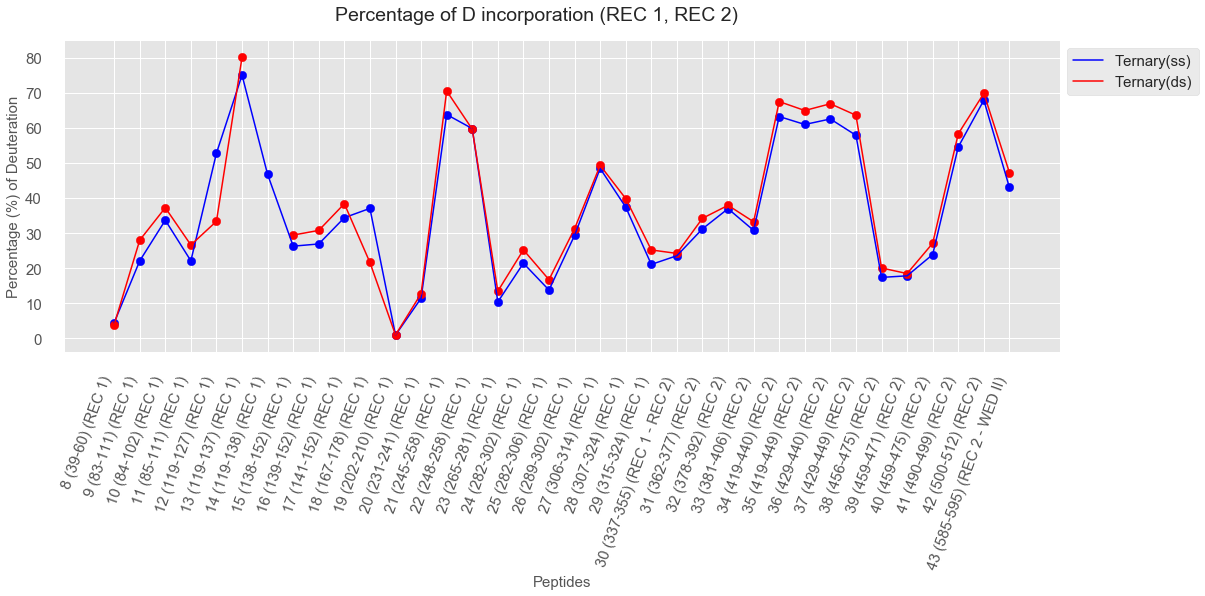

In [70]:
class plots(pep_analyzer, HDX):
    def __init__(self):
        
        HDX.__init__(self, df = df, states_list = states_list)
        
        pep_analyzer.__init__(self)
        
    
    def name(self, plot_states = ["Apo", 'Binary']):
   
        na = ""
        for st in plot_states:
            na = na + st + "-" 
            name = [i for i in na.split("-")]    
            name = name[:-1]
            name = "-".join(name)
        return name
          
    
    def uptake_plots(self, df, plot_states = ["Apo", 'Binary'], 
                    domains = None, pep_no = None,  pep_class = None,
                     pdf = False, tiff = False):
        """
        This function will create uptake plots of peptides against log of time.
        
        parameters:
        ----------
        df: dataframe.
        plot_states: list, the name of the plot_states (as many state as you want) to be plotted as a list.
        pep_class: list of peptides, it takes the second output from the function pep_dif_class
                    or pep_diff_sig_class.
        domains: list,  the list of domains you want to plot.
        pep_no: list, it takes individual pep umbers as a list.
        pdf: boolean, if True, it will save a pdf file of all plots.
        tiff: boolean, if True, it will save a tiff image for each peptide
        ----------
        output: it returns plots. 
        """
        
        #df = self.cal_diff()
        plt.style.use("ggplot")

        number =[]
        percent =[]
        std = []
        conf = []

        for st in plot_states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)
            
        if pep_class == None:
            
            if domains == None:
                
                if pep_no == None:
                    
                    unique_indxs = df.index.unique()
                    name = self.name(plot_states) 
                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "-".join(name)
            else:
                ud= []
                for i in domains:
                    a = df.loc[df['domains_start']== i].index
                    ud.append(a)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))
                
                name = self.name(plot_states)
                for dm in domains:
                    name = name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(plot_states)
            name = name + "pep_class"
                

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(plot_states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}

        with PdfPages(name + ".pdf") as pdf: 
            
            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:

                    a = (time, df2[sts])
                    dataD.append(a)

                dataP =[]
                for stx in percent:

                    a1 = (time, df2[stx])
                    dataP.append(a1)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)

                # Error for the percent plot
                confl =[]
                for c in conf:
                    a_p =  df2[c].values.tolist()
                    confl.append(a_p)

                # Create plot
                f, (ax1, ax2) = plt.subplots(1, 2, figsize =( 8,5))

                # Ploting the number plot

                for datad, datap, color, state, errord, errorp in zip(
                    dataD,dataP, colors, plot_states, stdl, confl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=14, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)

                    x2,y2 = datap
                    ax2.scatter(x2, y2, c=color, edgecolors='none', s=14, label = None )
                    ax2.plot(x2,y2,c=color, label = state)
                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlabel('time (s)', fontdict = font)
                    
                    

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax1.xaxis.set_tick_params(labelsize=14)
                ax1.yaxis.set_tick_params(labelsize=14)
                
                ax2.xaxis.set_tick_params(labelsize=14)
                ax2.yaxis.set_tick_params(labelsize=14)                
                ax2.set_ylim(ymin=-5, ymax=100)
                ax2.set_ylabel("Percent (%) of D",fontdict = font)
 
                

                # Setting a common Legend a out of the box and the title
                legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))
                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)
                f.tight_layout()
                plt.tight_layout()

                
                if pdf:
                    
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')

                if tiff:
                    folder = 'HDX_Plots/Uptake_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    folder_name = os.path.join('HDX_Plots','Uptake_Plots')

                    plt.savefig(folder_name + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )      

                plt.show()


    def difference_plots(self,df, diff_states = ("Apo","Binary"), domains = None,
                   pep_no = None, pep_class = None, pdf = False, tiff = False):
        
        """
        This function will create plots of differences in uptake of D between two states against log of time.
        
        parameters:
        ----------
        df: dataframe.
        diff_states: tuple, the name of the two states that you want to see the difference. 
        domains: list,  the list of domains you want to the differences in D uptake.
        pep_no: list, it takes individual pep umbers as a list.
        pep_class: list of peptides, it takes the second output from the function pep_dif_class
                    or pep_diff_sig_class.        
        pdf: boolean, if True, it will save a pdf file of all plots.
        tiff: boolean, if True, it will save a tiff image for each peptide
        ----------
        output: it returns plots.
        """
        plt.style.use("ggplot")
        #df = self.cal_diff()
        a, b =  diff_states 

        ast = "#D" + "_" + a
        bst = "#D" + "_" + b
        number =[ast,bst]

        sa = 'Stddev'+ "_" + a
        sb = 'Stddev'+ "_" + b
        std = [sa, sb]

        if pep_class == None:

            if domains == None:

                if pep_no == None:

                    unique_indxs = df.index.unique()
                    name =  "diff-" + self.name(diff_states)

                else:
                    unique_indxs= []
                    for i in pep_no:
                        d = df.loc[df.idx_pep==i].index[0]
                        unique_indxs.append(d)
                    na = ""
                    for st in pep_no:
                        na = na + str(st) + "-" 
                        name = [i for i in na.split("-")]    
                        name = name[:-1]
                        name = "diff-" + "-".join(name)
            else:
                ud= []
                for i in domains:
                    da = df.loc[df['domains_start']== i].index
                    ud.append(da)

                unique_indxs=[]
                for i in ud:
                    for j in i:
                        unique_indxs.append(j)
                unique_indxs = sorted(list(set(unique_indxs)))

                name = self.name(diff_states)
                for dm in domains:
                    name = "diff-" + name + "-" + dm
        else:
            unique_indxs = pep_class
            name = self.name(diff_states)
            name = "diff-" +name + "pep_class"


        colors = ("blue", "red")
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 10}

        with PdfPages(name + ".pdf") as pdf: 

            for idx in unique_indxs:

                df2 = df.loc[idx]

                dmn = str(df.loc[idx].domains.unique()[0])
                p = str(df.loc[idx].peps.unique()[0])
                maxD = df.loc[idx].maxD.unique()

                time = df2['Deut Time (sec)']

                dataD = []
                for sts in number:
                    ad = (time, df2[sts])
                    dataD.append(ad)

                stdl = []
                for s in std:
                    a_std =  df2[s].values.tolist()
                    stdl.append(a_std)
                
                f, (ax1, ax2) = plt.subplots(1, 2, figsize =(8,5))

                for datad, color, state, errord in zip(
                    dataD, colors, diff_states, stdl):

                    x1, y1 = datad
                    ax1.scatter(x1, y1, c=color, edgecolors='none', s=30, label = None )
                    ax1.plot(x1,y1,c=color, label = state)
                    (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                                markersize=8, capsize=5, label = None, c= color)
                    for cap in caps:
                        cap.set_markeredgewidth(1)
                    
                    col = a+"_"+b
                    col_er = a+"_"+b+ "_std"
                    diff_std = df2[col_er].values.tolist()
                    
                    x2, y2 = time, df2[col]
                    ax2.scatter(x2, y2, c='black', edgecolors='none', s=30, label = None )
                    ax2.plot(x2,y2,c='black', label = None)

                    (_, caps, _) = ax2.errorbar(x2, y2, yerr=diff_std, fmt='o',
                                                markersize=8, capsize=5, label = None, c= "black")

                    for cap in caps:
                        cap.set_markeredgewidth(1)
                for ax in (ax1,ax2):
                    ax.set_xscale('log')
                    ax.set_xlim(1, 10000)
                    ax.set_xlabel('time (s)', fontdict = font)
                    

                ax1.set_ylim(ymin=-1, ymax = maxD)
                ax2.set_ylim(ymax = maxD)
                
                ax1.xaxis.set_tick_params(labelsize=14)
                ax1.yaxis.set_tick_params(labelsize=14)
                
                ax2.xaxis.set_tick_params(labelsize=14)
                ax2.yaxis.set_tick_params(labelsize=14)
                
                ylabel_del = "$\Delta$" " ("+  a + " ," + b + ")"
                ax1.set_ylabel("Number (#) of D",fontdict = font)
                ax2.set_ylabel(ylabel_del,fontdict = font)

                # Setting a common Legend a out of the box and the title
                legend = ax1.legend(fontsize = 10)

                title = plt.suptitle(p +" (" +dmn +")", x = 0.6, y=1.05, fontdict = font_t)


                f.tight_layout()
                plt.tight_layout()

                plt.rc("font")
                
                if pdf:
                    
                    folder = 'HDX_Plots/Diff_Plots'
                    try:
                        os.makedirs(folder)
                    except OSError:
                        pass
                    
                    pdf.savefig(dpi=300, bbox_extra_artists=(legend, title), bbox_inches='tight')
                    
                if tiff:
                    plt.savefig(folder + p + ".tif", dpi=300,
                                bbox_extra_artists=(legend, title), bbox_inches='tight' )        

                plt.show()
    
    
    def scatter_plot(self,df, domains, timepoint= "t1", states = ["Apo", "Binary", "Ternary"],
                figsize =(14,12), plot_style = 'ggplot', pdf= False, tiff= False):
        
        #df = self.cal_diff()
    
        plt.style.use(plot_style)
        fig, ax = plt.subplots(figsize = figsize)

        # Finding out the indexes of the specified domains
        domidx= []
        for dmn in domains:
            da = df.loc[df['domains_start']== dmn].index
            domidx.append(da)

        unique_indxs=[]
        for i in domidx:
            for j in i:
                unique_indxs.append(j)
        unique_indxs = sorted(list(set(unique_indxs)))

        # Fishing out the dataframe by the time point and domains specified  
        df = df[df["timepoint_map"]==timepoint].loc[unique_indxs]


        # Selecting the states in the dataframe
        new_states =[]

        for st in states:
            new_states.append("%D_" + st )

        new_states_cof =[]
        for st in states:
            new_states_cof.append("Confidence_" + st )


        colors = ("blue", "red", "green", "magenta", "indigo", "cyan")[:len(states)]

        for newst, clr, st in zip(new_states, colors, states):
            
            ax.scatter(df.idxdmn,
                        df[newst],
                        s=70,
                        c= clr,
                        label = None)

            ax.plot(df.idxdmn,
                     df[newst],
                     color =clr,
                     label = st)

        ax.set_xticks(range(len(df.idxdmn.unique())))
        ax.set_xticklabels(df.idxdmn.unique(), rotation = 70, ha ="right")
            #ax.set_yticks(size=14)
        ax.set_xlabel("Peptides", size=figsize[0])
        ax.set_ylabel("Percentage (%) of Deuteration", size=figsize[0])
        plt.xticks(fontsize = figsize[0])
        plt.yticks(fontsize = figsize[0])
        title = ", ".join(st for st in domains)
        title ="Percentage of D incorporation"  +" (" + title +")" 
        plt.suptitle(title, size =1.3*figsize[0], y=1.03)

        ax.legend(loc='best',fontsize=figsize[0],fancybox=True, bbox_to_anchor=(1,1))
        plt.tight_layout()

        if pdf:

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')
        plt.show()
                
    def bubble_plot(self,df, domains, state,
                figsize =(14,12), plot_style = 'ggplot',
                name = None, pdf= False, tiff= False, fig_title =True, xfont =12):
        
        #df = self.cal_diff()

        plt.style.use(plot_style)
        fig, ax = plt.subplots(figsize = figsize)

        # Selecting the states in the dataframe
        state = "%D_" + state
        state_conf = "Confidence_" + state


        domidx= []
        for dmn in domains:
            da = df.loc[df['domains_start']== dmn].index
            domidx.append(da)

        unique_indxs=[]
        for i in domidx:
            for j in i:
                unique_indxs.append(j)
        unique_indxs = sorted(list(set(unique_indxs)))

        # Making a list of tuple containing x, the minimum and the maximum %D for the peptides in the unique_idxs

        tup_xminmax =[]
        for x, idx in zip(range(0,len(unique_indxs)),unique_indxs):
            tup_xminmax.append((x,df.loc[idx][state].min(),df.loc[idx][state].max()))

        df = df.loc[unique_indxs]

        # Adding vertical lines connecting each timepoint for a peptide
        for x, ymin, ymax in tup_xminmax:
            ax.vlines(x,ymin,ymax, linewidth =2)    

        # Scatter Plot
        ax.scatter(df.idxdmn,
                    df[state],
                    s=70,
                    c= df['Deut Time (sec)'].astype(float),
                    cmap= "prism", label = None)



        plt.xticks(range(len(df.idxdmn.unique())), df.idxdmn.unique(),rotation = 70, ha="right", fontsize = xfont)
        plt.yticks(size=14)
        ax.set_xlabel("Peptides", size=12)
        ax.set_ylabel("Percentage (%) of Deuteration", size=figsize[0])
        plt.title("Percentage of D incorporation", size =figsize[0], y =1.03)



        from matplotlib.colors import Normalize

        labels= df['Deut Time (sec)'].unique();
        # Extracting the color map to create a label
        cmap = plt.get_cmap("prism")
        # Creating an object instance for Normalizing the timepoints
        norm = Normalize(vmin = labels.min(), vmax=labels.max())
        # Performing Normalization
        norm_label = norm(labels)
        # Now finidng the rgbs for the colors used in the plot
        rgbs = cmap(norm_label)
        #Crating emply plots for the labels and the associated colors
        for cr, lb in zip(rgbs, labels):
            ax.scatter([], [], c= cr, label = str(lb) + " s" )

        plt.legend(loc='best',fontsize=figsize[0],fancybox=True, bbox_to_anchor=(1,1))

        title = ", ".join(st for st in domains)
        title ="Time Dependent Deuterium Incorporation" +" (" + state[3:] + " Complex"+ ")" +" (" + title +")" 
        if fig_title:
            plt.title(title, size =1.3*figsize[0])

        plt.legend(loc='best',fontsize=figsize[0],fancybox=True, bbox_to_anchor=(1,1))
        plt.tight_layout()

        if pdf:

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')
        plt.tight_layout()
        
        plt.show()
        
    def barplots_timeseries(self, df,diff_state=("Binary", "Ternary"), timepoints = ["t2", "t4"], domains = None,
                            plot_kind = "percent", peptides = None, plot_style ="ggplot", 
                            figsize =(20,14), pdf=False, tiff = False,name ="Barplots"):
        
        """ It will produce barplots of the differences in D uptakes between two states for each peptide"""

        plt.style.use(plot_style)
        
        state1, state2 = diff_state
        if plot_kind == "percent":
            yaxis = state1 + "_" + state2 + "_%D" 
            ylabel = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (% D)"
            yci = state1 + "_" + state2+ "_ci"
            title ="Differences in Percentage Deuteration Between " + state1 + " and " + state2 + " complexes"
        if plot_kind == "d":
            yaxis = state1 + "_" + state2
            ystd = state1 + "_" + state2 +"_"+ "std"
            ylabel = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (Number of 'D')"
            title ="Differences in Deuteration Between " + state1 + " and " + state2 + " complexes"

        if peptides==None:
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)
                df = df.loc[sorted(domain_indices)]
                domain_name =", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
                
            if domains == None:
                pass 
        else:
            df = df.loc[sorted(peptides)]
            

        plt.style.use(plot_style)
        plt.figure(figsize = figsize)
        
        # finding ymax for each plot so that I can find a single ymax for all of the plots
        ylim=[]
        # collecting all plot axes
        axes = []  
        # defining a dictionary for font
        fontdict = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}
        for idx, tm in enumerate(timepoints):
            fig = plt.subplot(len(timepoints),1, idx+1)
            label = str(df[df["timepoint_map"] == tm]["Deut Time (sec)"].unique()).strip("[]") + " s"
            barplot = sns.barplot(x ="idx_pep", y=yaxis, palette = df[df["timepoint_map"] == tm].color,
                        data =df[df["timepoint_map"] == tm], label = label)

            ticks=df[df["timepoint_map"] == tm].index.unique().tolist()
            barplot.set_xticklabels(ticks, rotation=90, fontdict = fontdict, ha ="center")
        
            axes.append(fig.axes)
            ylim.append(barplot.get_ylim()[1])

        for idx, ax in enumerate(axes):
            ax.legend(ncol=2, loc="upper right", frameon=False, fontsize=figsize[0],
                      handlelength=0, handletextpad=0, fancybox=True)
            ax.set_xlabel("Pepetides", fontdict = fontdict)
            ax.set_ylabel(ylabel, fontdict = fontdict)
            ax.yaxis.set_tick_params(labelsize=figsize[0])
            ax.set_ylim(top= max(ylim))

        ticks=df[df["timepoint_map"] == timepoints[-1]].idxdmn.unique().tolist()

        # Setting customized xticklabels only for the last axes plot
        axes[range(len(timepoints))[-1]].set_xticklabels(
            ticks,rotation=90, fontsize =figsize[0], ha ="center")
        
        # Increasing the distance between title and the plot.
        plt.suptitle(title, size =1.3*figsize[0], y=1.03, fontdict = fontdict )
        
        plt.rcParams['xtick.major.pad'] = 16
        
        plt.tight_layout()
        
        if pdf:

            folder = 'HDX_Plots/Bar_Plots'
            try:
                os.makedirs(folder)
            except OSError:
                pass
            folder_name = os.path.join('HDX_Plots','Bar_Plots')

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')

        plt.show() 
        
    def barplots(self, df,diff_state=("Binary", "Ternary"), timepoint = "t4", peptides = None,
             domains = None, plot_style ="ggplot" ,
                 figsize =(20,14), error_bar= False,
                 pdf=False, tiff = False,name ="Barplots"):
        
        """ It will produce barplots of the differences in D uptakes between two states for each peptide"""

        plt.style.use(plot_style)
        
        state1, state2 = diff_state
        
        yaxis_percent = state1 + "_" + state2 + "_%D" 
        ylabel_percent = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (% D)"
        yci = state1 + "_" + state2+ "_ci"
        title ="Differences in Deuteration Between " + state1 + " and " + state2 + " Complexes"

        yaxis_D = state1 + "_" + state2
        ystd = state1 + "_" + state2 +"_"+ "std"
        ylabel_D = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (Number of 'D')"
        title ="Differences in Deuteration Between " + state1 + " and " + state2 + " Complexes"

        
        
        if peptides==None:
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)
                df = df.loc[sorted(domain_indices)]
                domain_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
                
            if domains == None:
                raise ValueError("Put a list in the domains or pep_class parameter") 
        else:
            if domains:

                #Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)

                peptide_indices = df.loc[peptides].index.unique().tolist()
                combined_idices = [common_idx for common_idx in domain_indices if common_idx not in peptide_indices]
                df = df.loc[sorted(combined_idices)]
                domian_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
            else:
                df = df.loc[sorted(peptides)]
                title ="Differences in Deuteration Between " + state1 + " and " + state2 + " Complexes"

        df = df[df["timepoint_map"] == timepoint]
        label = str(df[df["timepoint_map"] == timepoint]["Deut Time (sec)"].unique()).strip("[]") + "s"
    
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize =figsize)
        plt.style.use(plot_style)
        
        fontdict = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}

        
        # Barplot in terms of percentage      
        ax1 = sns.barplot(x ="idx_pep", y=yaxis_percent, palette = df.color, data =df, 
                          label = " (%)", ax =ax1)
        if error_bar:
            # Error Bars        
            ax1.errorbar(range(len(df["idx_pep"])), df[yaxis_percent], yerr = df[yci],
                                        fmt='none', label = None, c= "b")
        # Bar plot in terms of D
        ax2 = sns.barplot(x ="idx_pep", y=yaxis_D, palette = df.color, data =df,
                          errcolor="black", label = " (#D)", ax =ax2)
        if error_bar:
            # Error Bars
            ax2.errorbar(range(len(df["idx_pep"])), df[yaxis_D], yerr = df[ystd],
                                          label = None, c=  "b", fmt = "none")
        
        ticks=df.idxdmn.unique().tolist()
        
        for ax in [ax1, ax2]:
            ax.set_xticklabels(ticks, rotation=90, fontdict = fontdict, ha ="center")
            
            ax.legend(ncol=2, loc="upper right", frameon=False, fontsize=figsize[0],
                      handlelength=0, handletextpad=0, fancybox=True)
            ax.set_xlabel("Pepetides", fontdict = fontdict)
        ax1.set_ylabel(ylabel_percent, fontdict = fontdict)
        ax2.set_ylabel(ylabel_D, fontdict = fontdict)

        plt.rc('ytick',labelsize=figsize[0])
    
        
        plt.suptitle(title, size =1.3*figsize[0], y=1.03, fontdict = fontdict )

        plt.tight_layout()
        
        
        if pdf:

            folder = 'HDX_Plots/Bar_Plots'
            try:
                os.makedirs(folder)
            except OSError:
                pass
            folder_name = os.path.join('HDX_Plots','Bar_Plots')

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')

        plt.show()
        
    def heat_map(self, df, diff_state = ("Apo", "Binary"), peptides =None,
             domains= ["REC 1", "REC 2"], xticks =False, figsize=(30,6),
                 pdf= False, tiff= False, plot_style ="ggplot"):
    

       
        state1, state2 = diff_state
        diff_state = state1 + "_" + state2 + "_%D" 


        # Filtering Peptides

        if peptides==None:
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)

                df = df.loc[domain_indices]
                title = ", ".join(st for st in domains)
                title ="Difference in Percent Deuteration (%) between "  + state1 + " and " + state2  + " Complexes"+" (" + title +")" 

            if domains == None:
                title ="Difference in Percent (%) Deuteration between "  + state1 + " and " + state2 + " Complexes"

        else:

            df = df.loc[peptides]
            title ="Difference in Percent(%) Deuteration between "  + state1 + " and " +state2  + " Complexes"
        # Selecting the columns
        col = ['Deut Time (sec)',diff_state,]
        # Instatiating the StandardScaler
        sds = StandardScaler(with_mean=False, with_std=False)
        # Ecxtracting the required columns
        df_heat_map = df[col]

        # Melting and rearranging the datafram to plot the heatmap
        df_heat_map =df_heat_map.pivot_table(index='Deut Time (sec)',columns = "idx", values =diff_state)
        # Drooping column with missing values as NaN interferes with the StandardScaler
        df_heat_map = df_heat_map.fillna(0)

        # Performing Scaling
        df_heat_map_transformed = sds.fit_transform(df_heat_map)

        # Creating the dataframe with the scaled data
        df_processed= pd.DataFrame(df_heat_map_transformed ,index= df_heat_map.index, columns = df_heat_map.columns)

        fig, (ax) = plt.subplots(1,1, figsize=figsize)
        fontdict = {'size': 0.8*figsize[0]}
        font_tick = {'size': 0.5*figsize[0]}

        # Setting the collor mapper
        sns.set(font_scale=1.5)
        cmap = sns.diverging_palette(10, 240, sep=20, as_cmap=True)

        ax = sns.heatmap(df_processed,vmin=-100, vmax=100,linewidth=0.2, center=0, cmap = cmap)

        ax.set_xlabel("Peptides",fontsize=figsize[0] )
        ax.set_ylabel('Deut Time (sec)',fontsize=figsize[0],labelpad =3 )

        # Increasing the distance between title and the plot.
        plt.title(title, size =figsize[0])
        ttl = ax.title
        ttl.set_position([.5, 1.05])


        # Mannually picking the xticks and xticklabels 
        if xticks:
            xticks= df_processed.columns.tolist()
            ax.xaxis.set(ticks=range(len(xticks)), ticklabels=xticks)


        # Mannually picking the yticklabels 
        yticks = df_processed.index.tolist()
        ax.set_yticklabels(yticks, rotation=45, fontdict = fontdict, ha ="center", )

        # Increasing distance between yticks and the plot
        plt.rcParams['ytick.major.pad'] = 16

        plt.tight_layout()

        if pdf:

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:

            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')

            plt.show()
            
    def barplots_multiple_states(self, df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t4", peptides = None,
             domains = None, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= False,
                 pdf=False, tiff = False,name ="Barplots"):
        
        """ It will produce barplots of the differences in D uptakes between two states for each peptide"""

        plt.style.use(plot_style)
        
        state1, state2, state3 = diff_state
        

        
        if plot_kind=="#D":
            # Plot in terms of D
            yaxis_12 = state1 + "_" + state2
            ystd_12 = state1 + "_" + state2 +"_"+ "std"
            ylabel_12 = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (Number of 'D')"
            legend_12 = " ("+  state1 + " ," + state2 + ")" 
            title_12 ="Differences in Deuteration Between " + state1 + " and " + state2 + " Complexes"

            yaxis_23 = state2 + "_" + state3
            ystd_23 = state2 + "_" + state3 +"_"+ "std"
            ylabel_23 = "$\Delta$" " ("+  state2 + " ," + state3 + ")" "\n (Number of 'D')"
            legend_23 = " ("+  state2 + " ," + state3+ ")"
            title_23 ="Differences in Deuteration Between " + state2 + " and " + state3 + " Complexes"
            
        else:
            # Percentage plot
            yaxis_12 = state1 + "_" + state2 + "_%D" 
            ylabel_12 = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (% D)"
            legend_12 = " ("+  state1 + " ," + state2 + ")" 
            ystd_12 = state1 + "_" + state2+ "_ci"


            yaxis_23 = state2 + "_" + state3 + "_%D" 
            ylabel_23 = "$\Delta$" " ("+  state2 + " ," + state3 + ")" "\n (% D)"
            legend_23 = " ("+  state2 + " ," + state3+ ")"
            ystd_23 = state2 + "_" + state3+ "_ci"
        
        
        title ="Differential Deuteration" +" (" + plot_kind + ")"
        
        
        if peptides==None:
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)
                df = df.loc[sorted(domain_indices)]
                domain_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
                
            if domains == None:
                pass
        else:
            if domains:

                #Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)

                peptide_indices = df.loc[peptides].index.unique().tolist()
                combined_idices = [common_idx for common_idx in domain_indices if common_idx not in peptide_indices]
                df = df.loc[sorted(combined_idices)]
                domian_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
            else:
                df = df.loc[sorted(peptides)]

        df = df[df["timepoint_map"] == timepoint]
        label = str(df[df["timepoint_map"] == timepoint]["Deut Time (sec)"].unique()).strip("[]") + "s"
    
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize =figsize)
        plt.style.use(plot_style)
        
        fontdict = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}

        
        # Barplots     
        ax1 = sns.barplot(x ="idx_pep", y=yaxis_12, palette = df.color, data =df, 
                          label = legend_12, ax =ax1)
        if error_bar:
            # Error Bars        
            ax1.errorbar(range(len(df["idx_pep"])), df[yaxis_12], yerr = df[ystd_12],
                                        fmt='none', label = None, c= "b")
        # Barplot
        ax2 = sns.barplot(x ="idx_pep", y=yaxis_23, palette = df.color, data =df,
                          errcolor="black", label = legend_23, ax =ax2)
        if error_bar:
            # Error Bars
            ax2.errorbar(range(len(df["idx_pep"])), df[yaxis_23], yerr = df[ystd_23],
                                          label = None, c=  "b", fmt = "none")
        
        ticks=df.idxdmn.unique().tolist()
        
        for ax in [ax1, ax2]:
            ax.legend(ncol=2, frameon=False, fontsize=figsize[0],
                      handlelength=0, handletextpad=0, fancybox=True)
            ax.set_xlabel("")
            
        ax1.set_xticklabels(ticks, rotation=90, fontsize =figsize[1], ha ="center")
        ax2.set_xticklabels("")
        ax1.set_ylabel(ylabel_12, fontdict = fontdict)
        ax2.set_ylabel(ylabel_23, fontdict = fontdict)

        plt.rc('ytick',labelsize=figsize[0])
    
        
        plt.suptitle(title, size =1.3*figsize[0], y=1.03, fontdict = fontdict )

        plt.tight_layout()
        
        
        if pdf:

            folder = 'HDX_Plots/Bar_Plots'
            try:
                os.makedirs(folder)
            except OSError:
                pass
            folder_name = os.path.join('HDX_Plots','Bar_Plots')

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')

        plt.show()


pl = plots()
pl.scatter_plot(df, domains = rec, states = ["Ternary(ss)", "Ternary(ds)"], timepoint = "t2", pdf =True, figsize=(15, 8)  )

In [19]:
def barplots_multiple_states(self, df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t4", peptides = None,
             domains = None, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= False,
                 pdf=False, tiff = False,name ="Barplots"):
        
        """ It will produce barplots of the differences in D uptakes between two states for each peptide"""

        plt.style.use(plot_style)
        
        state1, state2, state3 = diff_state
        

        
        if plot_kind=="#D":
            # Plot in terms of D
            yaxis_12 = state1 + "_" + state2
            ystd_12 = state1 + "_" + state2 +"_"+ "std"
            ylabel_12 = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (Number of 'D')"
            legend_12 = " ("+  state1 + " ," + state2 + ")" 
            title_12 ="Differences in Deuteration Between " + state1 + " and " + state2 + " Complexes"

            yaxis_23 = state2 + "_" + state3
            ystd_23 = state2 + "_" + state3 +"_"+ "std"
            ylabel_23 = "$\Delta$" " ("+  state2 + " ," + state3 + ")" "\n (Number of 'D')"
            legend_23 = " ("+  state2 + " ," + state3+ ")"
            title_23 ="Differences in Deuteration Between " + state2 + " and " + state3 + " Complexes"
            
        else:
            # Percentage plot
            yaxis_12 = state1 + "_" + state2 + "_%D" 
            ylabel_12 = "$\Delta$" " ("+  state1 + " ," + state2 + ")" "\n (% D)"
            legend_12 = " ("+  state1 + " ," + state2 + ")" 
            ystd_12 = state1 + "_" + state2+ "_ci"


            yaxis_23 = state2 + "_" + state3 + "_%D" 
            ylabel_23 = "$\Delta$" " ("+  state2 + " ," + state3 + ")" "\n (% D)"
            legend_23 = " ("+  state2 + " ," + state3+ ")"
            ystd_23 = state2 + "_" + state3+ "_ci"
        
        
        title ="Differential Deuteration" +" (" + plot_kind + ")"
        
        
        if peptides==None:
            if domains:
                # Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)
                df = df.loc[sorted(domain_indices)]
                domain_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
                
            if domains == None:
                pass
        else:
            if domains:

                #Finding out the indexes of the specified domains
                domain_indices=[]
                for domain in domains:
                    domain_lists = df.loc[df['domains_start']== domain].index.unique().tolist()
                    domain_indices.extend(domain_lists)

                peptide_indices = df.loc[peptides].index.unique().tolist()
                combined_idices = [common_idx for common_idx in domain_indices if common_idx not in peptide_indices]
                df = df.loc[sorted(combined_idices)]
                domian_name = ", ".join(st for st in domains)
                title = title + " (" + domain_name + ")"
            else:
                df = df.loc[sorted(peptides)]

        df = df[df["timepoint_map"] == timepoint]
        label = str(df[df["timepoint_map"] == timepoint]["Deut Time (sec)"].unique()).strip("[]") + "s"
    
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize =figsize)
        plt.style.use(plot_style)
        
        fontdict = {'family': 'serif','color':  'black', 'weight': 'normal','size': figsize[0]}

        
        # Barplots     
        ax1 = sns.barplot(x ="idx_pep", y=yaxis_12, palette = df.color, data =df, 
                          label = legend_12, ax =ax1)
        if error_bar:
            # Error Bars        
            ax1.errorbar(range(len(df["idx_pep"])), df[yaxis_12], yerr = df[ystd_12],
                                        fmt='none', label = None, c= "b")
        # Barplot
        ax2 = sns.barplot(x ="idx_pep", y=yaxis_23, palette = df.color, data =df,
                          errcolor="black", label = legend_23, ax =ax2)
        if error_bar:
            # Error Bars
            ax2.errorbar(range(len(df["idx_pep"])), df[yaxis_23], yerr = df[ystd_23],
                                          label = None, c=  "b", fmt = "none")
        
        ticks=df.idxdmn.unique().tolist()
        
        for ax in [ax1, ax2]:
            ax.legend(ncol=2, frameon=False, fontsize=figsize[0],
                      handlelength=0, handletextpad=0, fancybox=True)
            ax.set_xlabel("")
            
        ax1.set_xticklabels(ticks, rotation=90, fontsize =figsize[1], ha ="center")
        ax2.set_xticklabels("")
        ax1.set_ylabel(ylabel_12, fontdict = fontdict)
        ax2.set_ylabel(ylabel_23, fontdict = fontdict)

        plt.rc('ytick',labelsize=figsize[0])
    
        
        plt.suptitle(title, size =1.3*figsize[0], y=1.03, fontdict = fontdict )

        plt.tight_layout()
        
        
        if pdf:

            folder = 'HDX_Plots/Bar_Plots'
            try:
                os.makedirs(folder)
            except OSError:
                pass
            folder_name = os.path.join('HDX_Plots','Bar_Plots')

            plt.savefig(title + ".pdf", dpi=500, bbox_inches='tight')

        if tiff:
            plt.savefig(title + ".tif", dpi=500, bbox_inches='tight')

        plt.show()


In [17]:
df.index

Int64Index([  1,   1,   1,   1,   1,   2,   2,   2,   2,   2,
            ...
            159, 159, 159, 159, 159, 160, 160, 160, 160, 160],
           dtype='int64', name='idx', length=800)

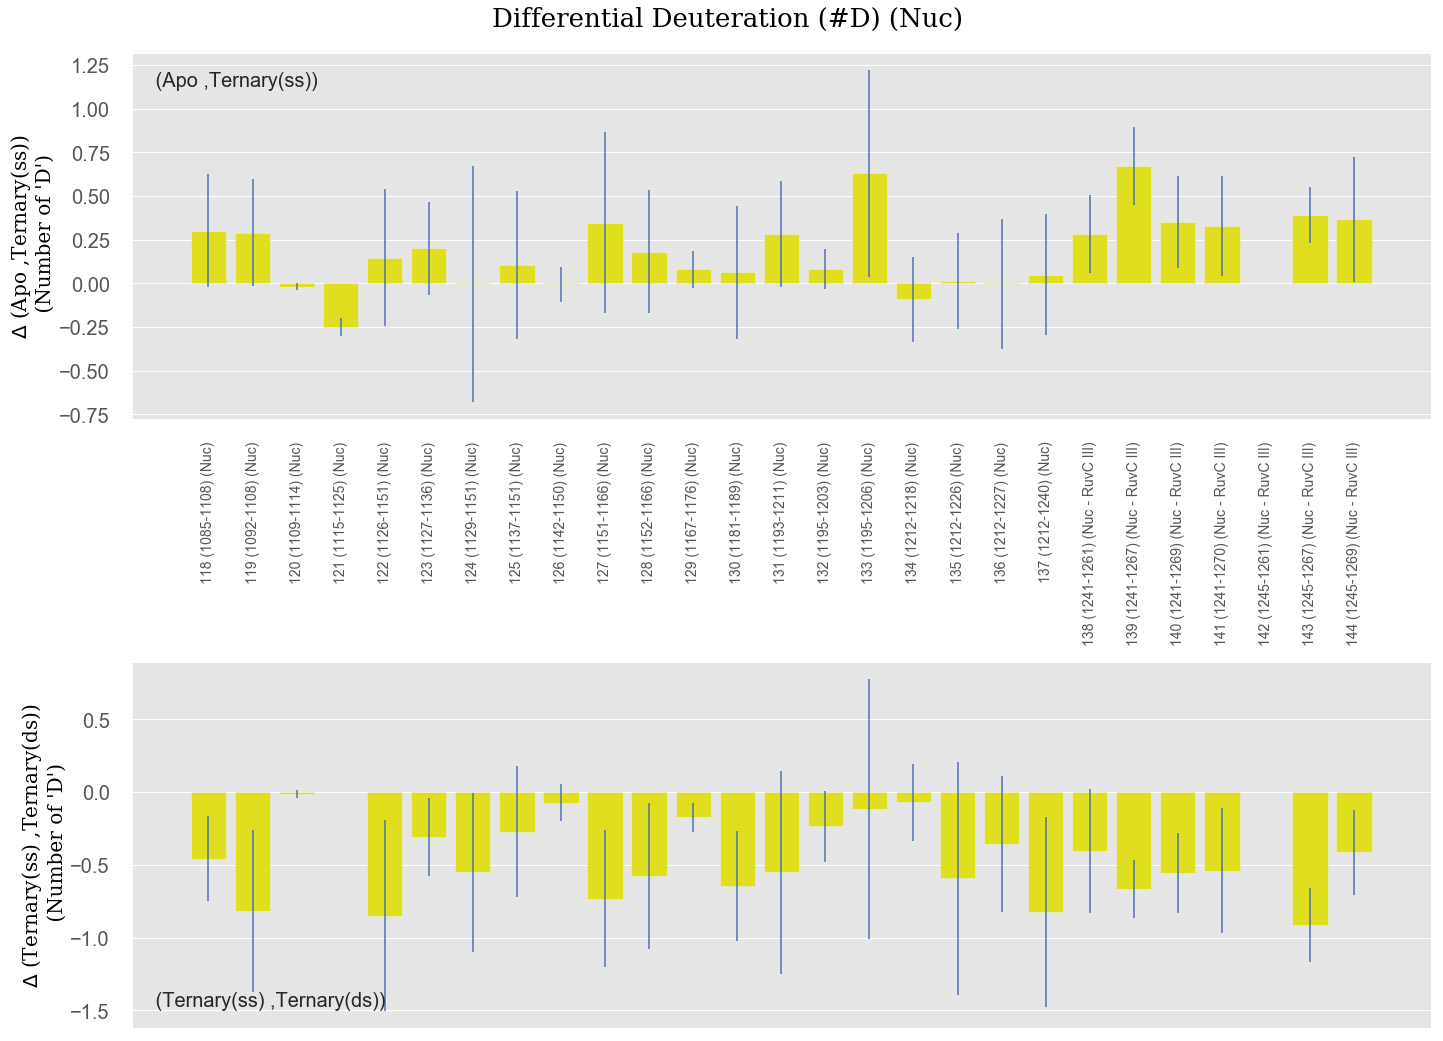

In [87]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Ternary(ss)", "Ternary(ds)"), timepoint = "t2", peptides=None,
             domains = nuc, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= True,
                 pdf=True, tiff = False,name ="Barplots")

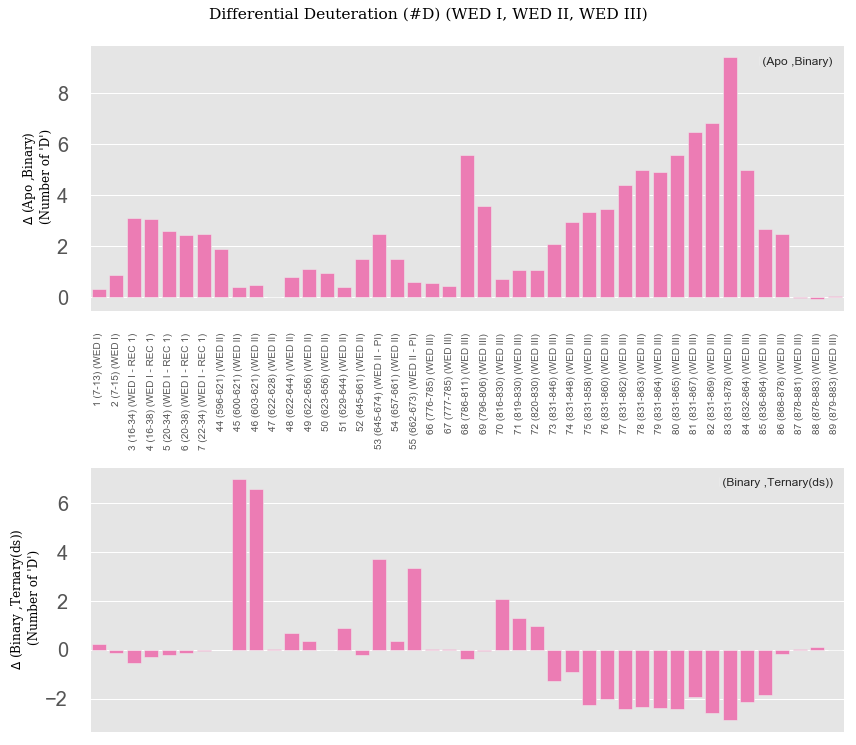

In [72]:
pl.barplots_multiple_states(df,diff_state=("Apo","Binary","Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = wedge, plot_style ="ggplot" ,
                 figsize =(12,10), plot_kind="#D", error_bar= False,
                 pdf=True, tiff = False,name ="Barplots")

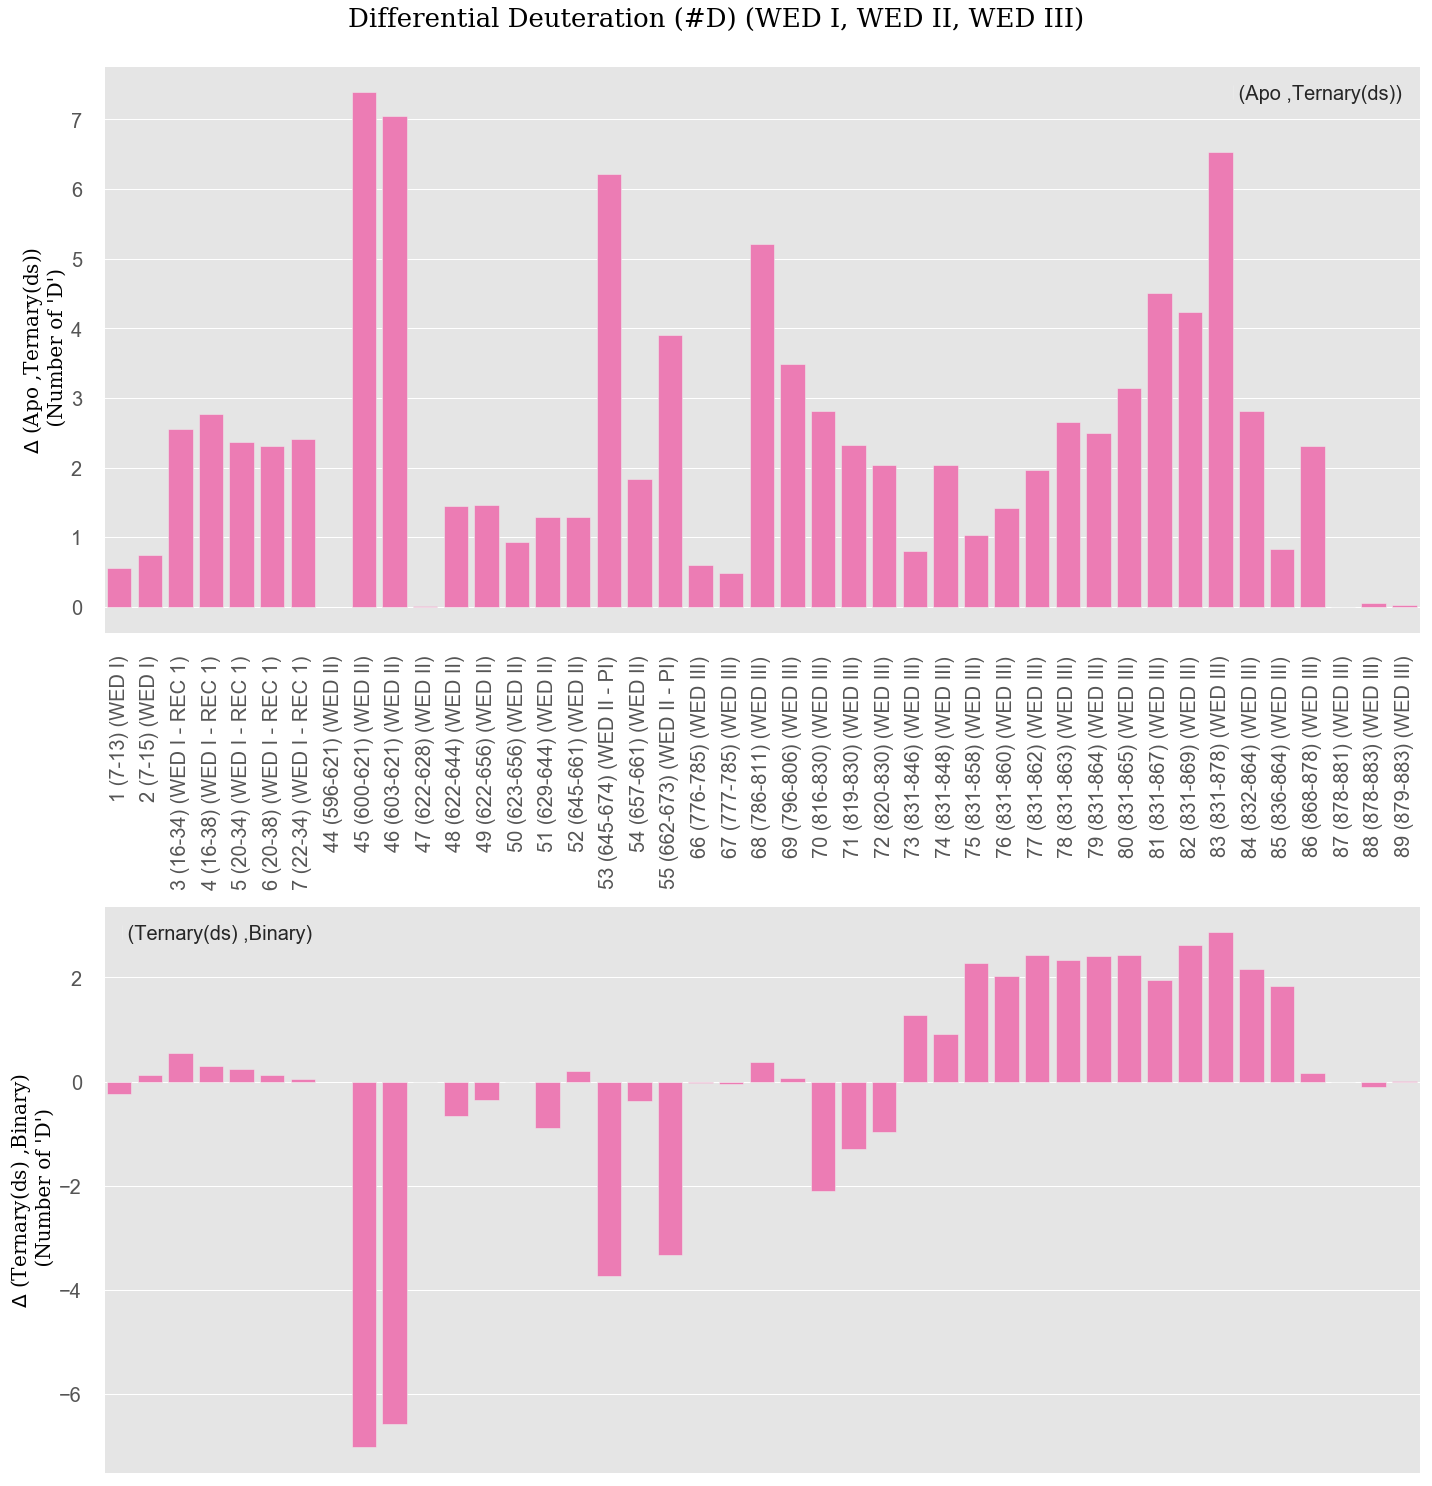

In [35]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Ternary(ds)", "Binary"), timepoint = "t2", peptides = None,
             domains = wedge, plot_style ="ggplot" ,
                 figsize =(20,20), plot_kind="#D", error_bar= False,
                 pdf=True, tiff = False,name ="Barplots")

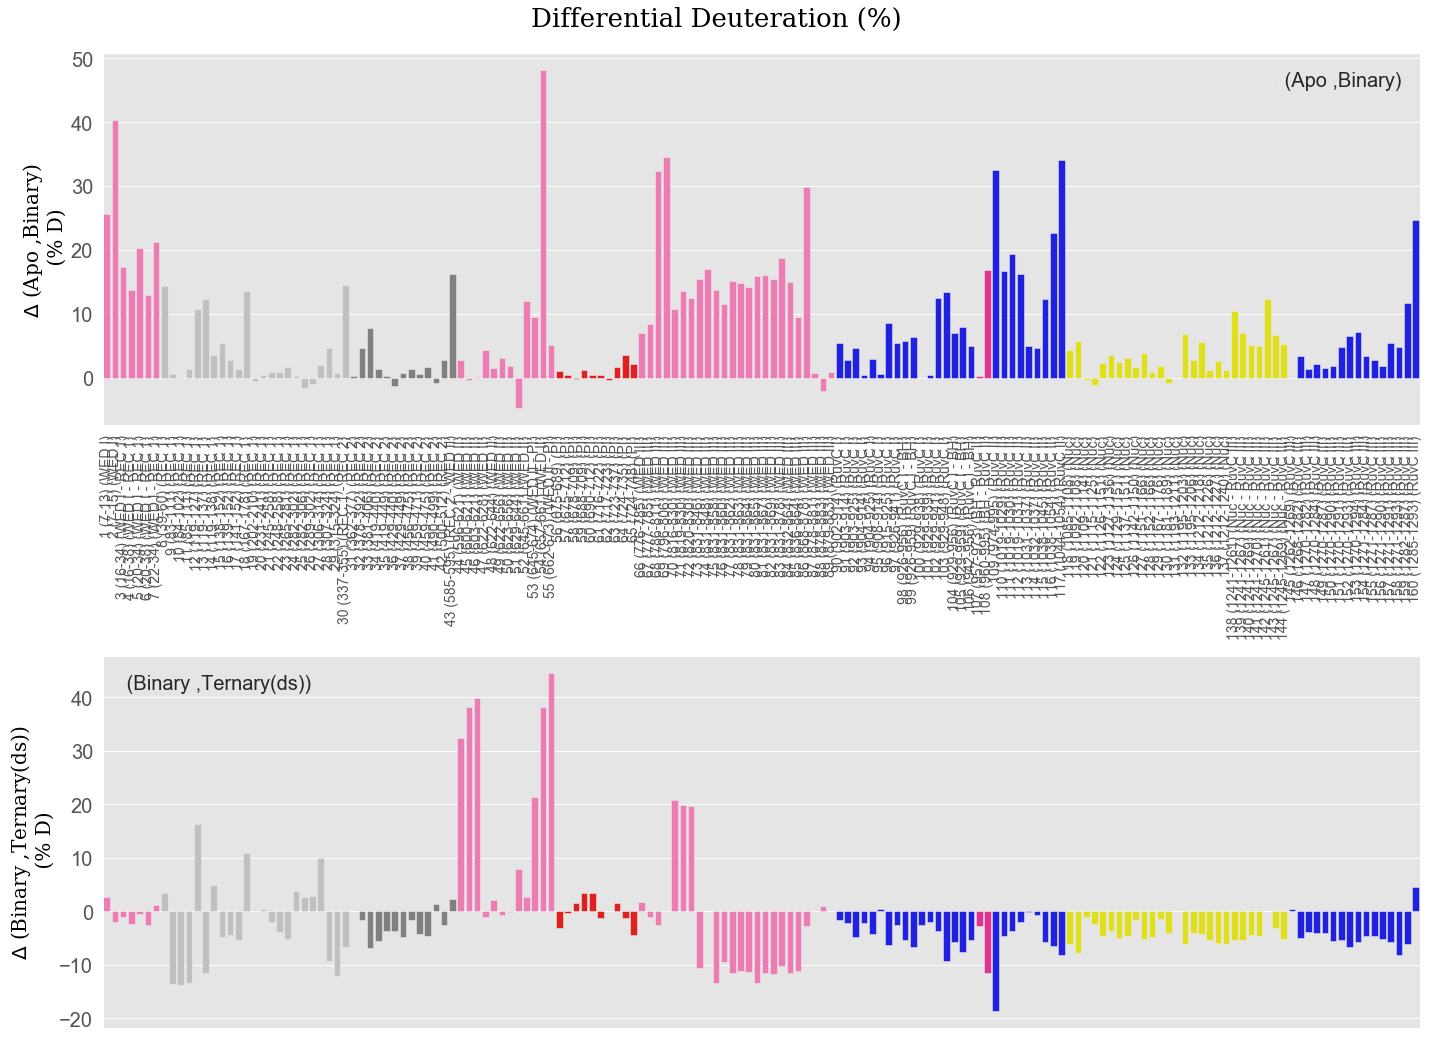

In [40]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t3", peptides = None,
             domains = None, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="%", error_bar= False,
                 pdf=False, tiff = False,name ="Barplots")

In [ ]:
pl.bubble_plot(df, domains = ruvc, state ="Ternary(ss)", figsize=(15, 8), pdf =True, xfont = 15, fig_title =False)

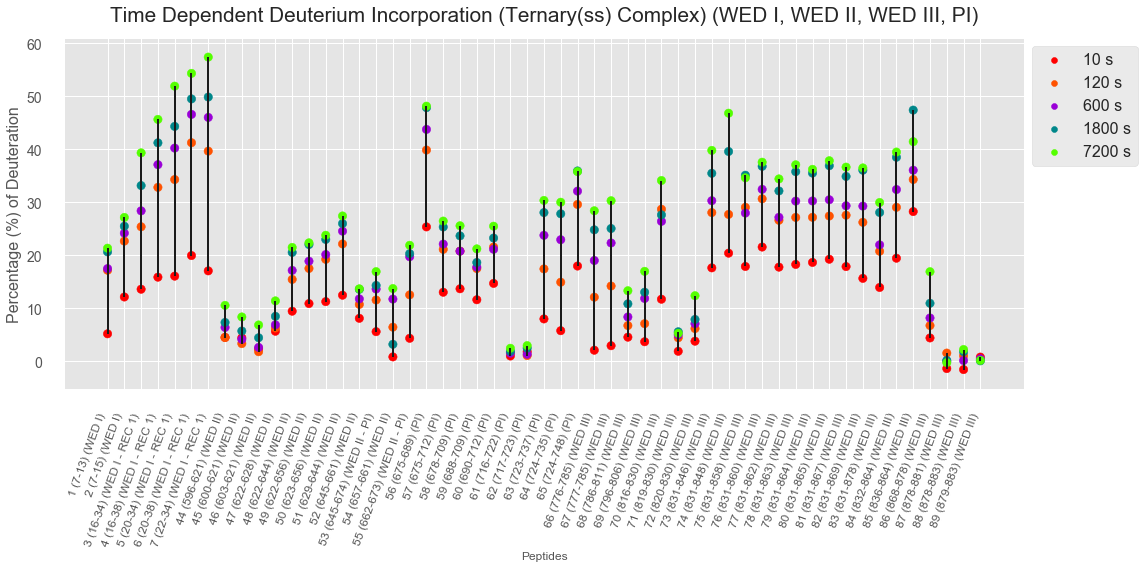

In [88]:
pl.bubble_plot(df, domains = wedge + pi, state ="Ternary(ss)", figsize=(16, 8), pdf =True)

In [303]:
df.columns

Index(['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
       '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
       'Stddev_Apo', 'p_Apo', '#D_Binary', '%D_Binary',
       'Conf Interval (#D)_Binary', '#Pts_Binary', 'Confidence_Binary',
       'Stddev_Binary', 'p_Binary', '#D_Ternary(ss)', '%D_Ternary(ss)',
       'Conf Interval (#D)_Ternary(ss)', '#Pts_Ternary(ss)',
       'Confidence_Ternary(ss)', 'Stddev_Ternary(ss)', 'p_Ternary(ss)',
       '#D_Ternary(ds)', '%D_Ternary(ds)', 'Conf Interval (#D)_Ternary(ds)',
       '#Pts_Ternary(ds)', 'Confidence_Ternary(ds)', 'Stddev_Ternary(ds)',
       'p_Ternary(ds)', 'idx_pep', 'idx1', 'peps', 'timepoint_map', 'domains',
       'domains_start', 'domains_end', 'pepsdmn', 'idxdmn', 'color',
       'Apo_Binary', 'Apo_Binary_%D', 'Apo_Ternary(ss)', 'Apo_Ternary(ss)_%D',
       'Apo_Ternary(ds)', 'Apo_Ternary(ds)_%D', 'Binary_Apo', 'Binary_Apo_%D',
       'Binary_Ternary(ss)', 'Binary_Ternary(ss)_%D', 'Binary_Te

In [319]:
df.head()

Start  End Sequence  Deut Time (sec)  maxD  #D_Apo  %D_Apo  \
idx                                                               
1        7   13  FVNKYSL               10     5   0.733  14.663   
1        7   13  FVNKYSL              120     5   1.372  27.439   
1        7   13  FVNKYSL              600     5   2.316  46.326   
1        7   13  FVNKYSL             1800     5   2.945  58.909   
1        7   13  FVNKYSL             7200     5   2.907  58.136   

     Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                    
1                     0.122       3.0         Medium   
1                     1.287       2.0         Medium   
1                     0.921       3.0         Medium   
1                     0.213       2.0         Medium   
1                     1.207       3.0         Medium   

                ...              Apo_Ternary(ds)_ci  Binary_Apo_ci  \
idx             ...                                                  
1               ...                        0.782568       0.358403   
1               ...                        1.293251       1.288902   
1               ...                        0.928276       0.947613   
1               ...                        2.488134       0.300521   
1               ...                        1.323517       1.251299   

     Binary_Ternary(ss)_ci  Binary_Ternary(ds)_ci  Ternary(ss)_Apo_ci  \
idx                                                                     
1                 0.384440               0.843266            0.221606   
1                 0.128701               0.145014            1.291524   
1                 0.246059               0.251366            0.926853   
1                 0.276818               2.488048            0.277584   
1                 0.683887               0.635412            1.347461   

     Ternary(ss)_Binary_ci Ternary(ss)_Ternary(ds)_ci  Ternary(ds)_Apo_ci  \
idx                                                                         
1                 0.384440                   0.794830            0.782568   
1                 0.128701                   0.166712            1.293251   
1                 0.246059                   0.155795            0.928276   
1                 0.276818                   2.485382            2.488134   
1                 0.683887                   0.808486            1.323517   

     Ternary(ds)_Binary_ci  Ternary(ds)_Ternary(ss)_ci  
idx                                                     
1                 0.843266                    0.794830  
1                 0.145014                    0.166712  
1                 0.251366                    0.155795  
1                 2.488048                    2.485382  
1                 0.635412                    0.808486  

[5 rows x 91 columns]

In [320]:
def domain_slection(df, domains = ruvc):

    filtered_df = []
    for subdomain in domains:
        df_subdomain = df.loc[df["domains"]==subdomain]
        filtered_df.append(df_subdomain)
    filtered_df = pd.concat(filtered_df)
    return filtered_df

In [339]:
t2['peps'].tolist()

['1. FVNKYSL (7-13)',
 '2. FVNKYSLSK (7-15)',
 '44. FKLNFENSTLANGWDKNKEPDNTAIL (596-621)',
 '45. FENSTLANGWDKNKEPDNTAIL (600-621)',
 '46. STLANGWDKNKEPDNTAIL (603-621)',
 '47. FIKDDKY (622-628)',
 '48. FIKDDKYYLGVMNKKNNKIFDDK (622-644)',
 '49. FIKDDKYYLGVMNKKNNKIFDDKAIKENKGEGYKK (622-656)',
 '50. IKDDKYYLGVMNKKNNKIFDDKAIKENKGEGYKK (623-656)',
 '51. YLGVMNKKNNKIFDDK (629-644)',
 '52. AIKENKGEGYKKIVYKL (645-661)',
 '54. IVYKL (657-661)',
 '66. SVVNQGKLYL (776-785)',
 '67. VVNQGKLYL (777-785)',
 '68. FQIYNKDFSAYSKGRPNLHTLYWKAL (786-811)',
 '69. YSKGRPNLHTL (796-806)',
 '70. NLQDVVYKLNGEAEL (816-830)',
 '71. DVVYKLNGEAEL (819-830)',
 '72. VVYKLNGEAEL (820-830)',
 '73. FYRKQSIPKKITHPAK (831-846)',
 '74. FYRKQSIPKKITHPAKEA (831-848)',
 '75. FYRKQSIPKKITHPAKEAIANKNKDNPK (831-858)',
 '76. FYRKQSIPKKITHPAKEAIANKNKDNPKKE (831-860)',
 '77. FYRKQSIPKKITHPAKEAIANKNKDNPKKESV (831-862)',
 '78. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVF (831-863)',
 '79. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFE (831-864)',
 '80. FYR

In [343]:
(1/64)**5

9.313225746154785e-10

In [340]:

wedge_dom =domain_slection(df, domains = wedge)
t2 = wedge_dom.loc[wedge_dom["timepoint_map"]=="t2"]
t2[['peps', 'maxD','Apo_Binary', 'Binary_Ternary(ds)']].round(1)


peps  maxD  Apo_Binary  \
idx                                                                        
1                                    1. FVNKYSL (7-13)     5         0.3   
2                                  2. FVNKYSLSK (7-15)     7         0.9   
44            44. FKLNFENSTLANGWDKNKEPDNTAIL (596-621)    23         1.9   
45                45. FENSTLANGWDKNKEPDNTAIL (600-621)    19         0.4   
46                   46. STLANGWDKNKEPDNTAIL (603-621)    16         0.5   
47                               47. FIKDDKY (622-628)     5        -0.0   
48               48. FIKDDKYYLGVMNKKNNKIFDDK (622-644)    21         0.8   
49   49. FIKDDKYYLGVMNKKNNKIFDDKAIKENKGEGYKK (622-656)    33         1.1   
50    50. IKDDKYYLGVMNKKNNKIFDDKAIKENKGEGYKK (623-656)    32         0.9   
51                      51. YLGVMNKKNNKIFDDK (629-644)    14         0.4   
52                     52. AIKENKGEGYKKIVYKL (645-661)    15         1.5   
54                                 54. IVYKL (657-661)     3         1.5   
66                            66. SVVNQGKLYL (776-785)     8         0.6   
67                             67. VVNQGKLYL (777-785)     7         0.4   
68            68. FQIYNKDFSAYSKGRPNLHTLYWKAL (786-811)    23         5.6   
69                           69. YSKGRPNLHTL (796-806)     8         3.6   
70                       70. NLQDVVYKLNGEAEL (816-830)    13         0.7   
71                          71. DVVYKLNGEAEL (819-830)    10         1.0   
72                           72. VVYKLNGEAEL (820-830)     9         1.1   
73                      73. FYRKQSIPKKITHPAK (831-846)    12         2.1   
74                    74. FYRKQSIPKKITHPAKEA (831-848)    14         2.9   
75          75. FYRKQSIPKKITHPAKEAIANKNKDNPK (831-858)    23         3.3   
76        76. FYRKQSIPKKITHPAKEAIANKNKDNPKKE (831-860)    25         3.4   
77      77. FYRKQSIPKKITHPAKEAIANKNKDNPKKESV (831-862)    27         4.4   
78     78. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVF (831-863)    28         5.0   
79    79. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFE (831-864)    29         4.9   
80   80. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFEY (831-865)    30         5.6   
81   81. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFEYDL (831...    32         6.5   
82   82. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFEYDLIK (8...    34         6.8   
83   83. FYRKQSIPKKITHPAKEAIANKNKDNPKKESVFEYDLIKDKR...    43         9.4   
84     84. YRKQSIPKKITHPAKEAIANKNKDNPKKESVFE (832-864)    28         5.0   
85         85. SIPKKITHPAKEAIANKNKDNPKKESVFE (836-864)    24         2.7   
86                           86. IKDKRFTEDKF (868-878)     9         2.5   
87                                  87. FFFH (878-881)     2        -0.0   
88                                88. FFFHCP (878-883)     3        -0.1   
89                                 89. FFHCP (879-883)     2         0.0   

     Binary_Ternary(ds)  
idx                      
1                   0.2  
2                  -0.1  
44                  NaN  
45                  7.0  
46                  6.6  
47                  0.0  
48                  0.7  
49                  0.4  
50                  0.0  
51                  0.9  
52                 -0.2  
54                  0.4  
66                  0.0  
67                  0.0  
68                 -0.4  
69                 -0.1  
70                  2.1  
71                  1.3  
72                  1.0  
73                 -1.3  
74                 -0.9  
75                 -2.3  
76                 -2.0  
77                 -2.4  
78                 -2.3  
79                 -2.4  
80                 -2.4  
81                 -2.0  
82                 -2.6  
83                 -2.9  
84                 -2.2  
85                 -1.8  
86                 -0.2  
87                  0.0  
88                  0.1  
89                 -0.0

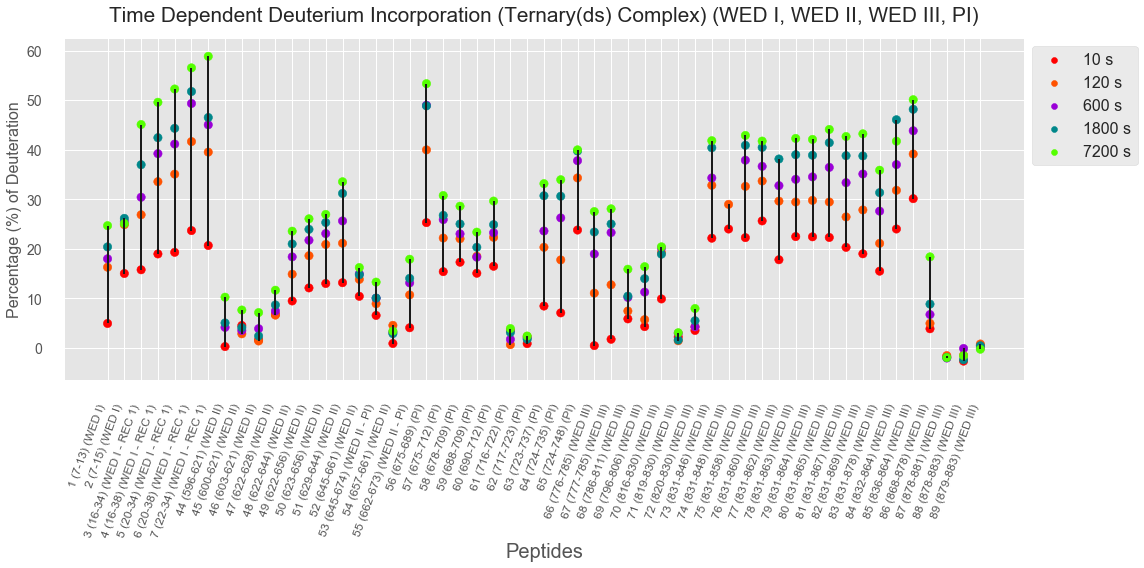

In [332]:
pl.bubble_plot(df, domains = wedge + pi, state ="Ternary(ds)", figsize=(16, 8), pdf =True)

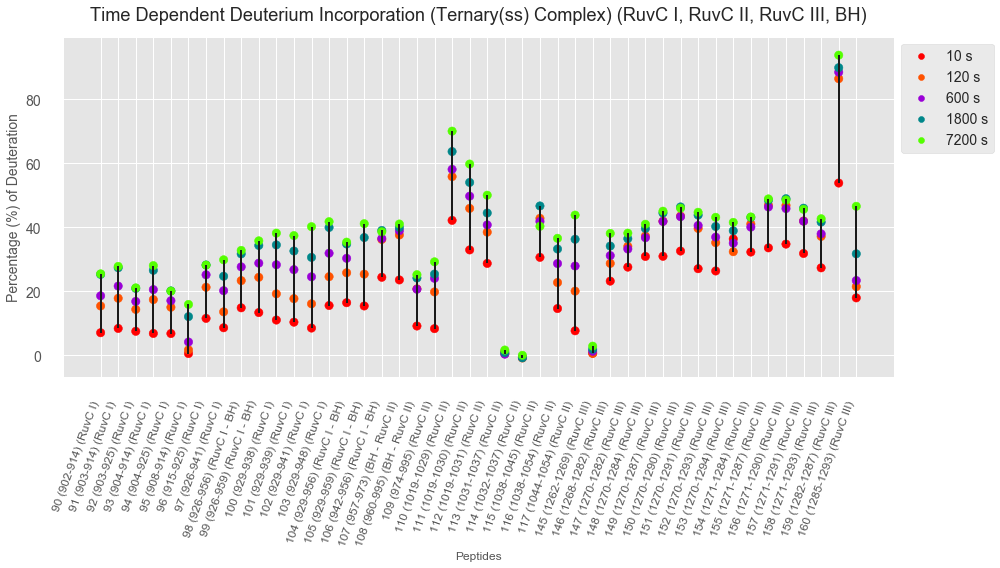

In [42]:
pl.bubble_plot(df, domains = ruvc +bh, state ="Ternary(ss)", figsize=(14, 8), pdf =True)

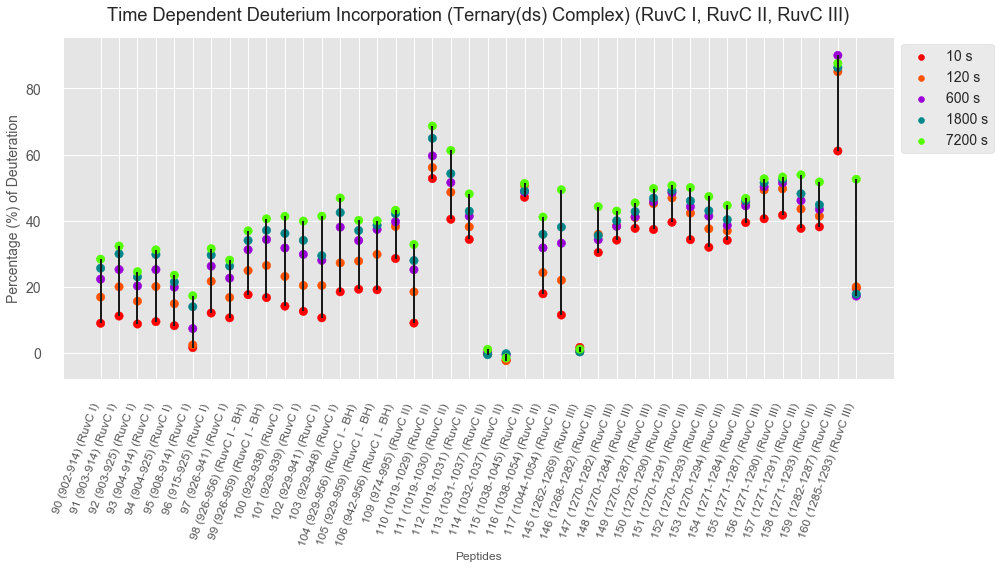

In [44]:
pl.bubble_plot(df, domains = ruvc, state ="Ternary(ds)", figsize=(14, 8), pdf =True)

In [ ]:
dom 

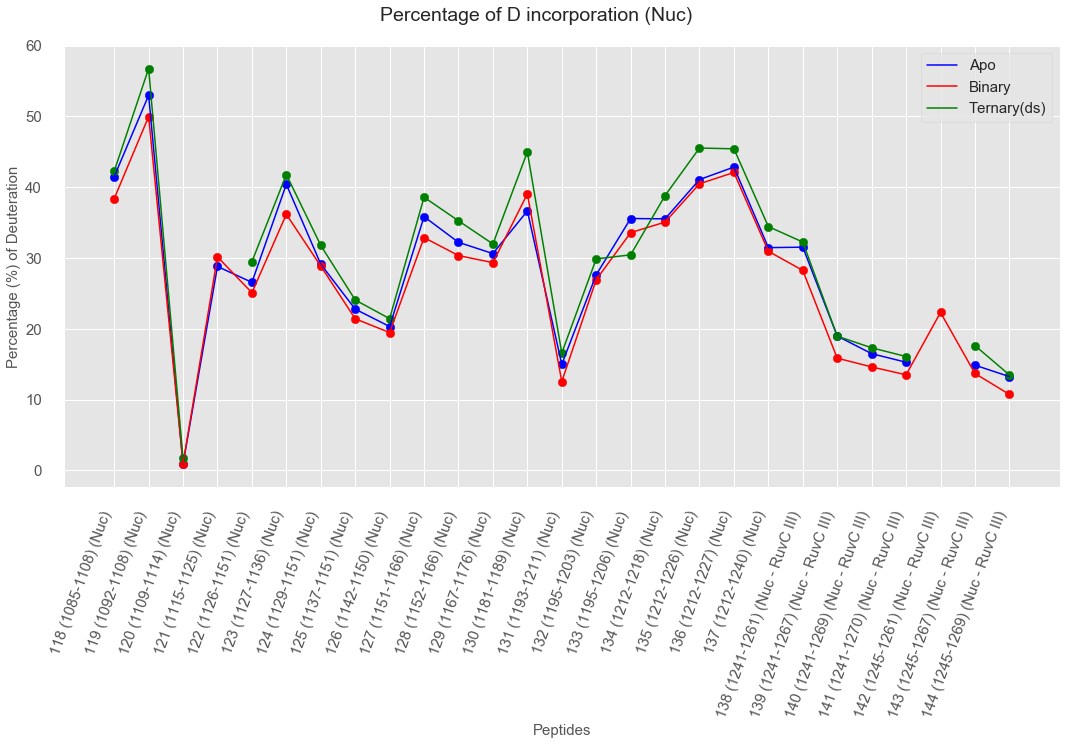

In [77]:
# scatter plots for a particular time point (2 min), Recongnition domain
pl.scatter_plot(df, domains = nuc, states = [ "Apo", "Binary", "Ternary(ds)"], timepoint = "t2", pdf =False, figsize=(15, 10)  )

In [53]:
df.columns

Index(['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
       '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
       'Stddev_Apo', 'p_Apo', '#D_Binary', '%D_Binary',
       'Conf Interval (#D)_Binary', '#Pts_Binary', 'Confidence_Binary',
       'Stddev_Binary', 'p_Binary', '#D_Ternary(ss)', '%D_Ternary(ss)',
       'Conf Interval (#D)_Ternary(ss)', '#Pts_Ternary(ss)',
       'Confidence_Ternary(ss)', 'Stddev_Ternary(ss)', 'p_Ternary(ss)',
       '#D_Ternary(ds)', '%D_Ternary(ds)', 'Conf Interval (#D)_Ternary(ds)',
       '#Pts_Ternary(ds)', 'Confidence_Ternary(ds)', 'Stddev_Ternary(ds)',
       'p_Ternary(ds)', 'idx_pep', 'idx1', 'peps', 'timepoint_map', 'domains',
       'domains_start', 'domains_end', 'pepsdmn', 'idxdmn', 'color',
       'Apo_Binary', 'Apo_Binary_%D', 'Apo_Ternary(ss)', 'Apo_Ternary(ss)_%D',
       'Apo_Ternary(ds)', 'Apo_Ternary(ds)_%D', 'Binary_Apo', 'Binary_Apo_%D',
       'Binary_Ternary(ss)', 'Binary_Ternary(ss)_%D', 'Binary_Te

In [58]:
df["#D_Apo"].mean(), df["#D_Binary"].mean(), df["#D_Ternary(ss)"].mean(), df["#D_Ternary(ds)"].mean()

(5.487277289836879, 4.335139097744358, 4.418939393939396, 4.8213856041131145)

In [62]:
df.loc[df["timepoint_map"]=="t2"]["Stddev_Apo"].std(), df["Stddev_Binary"].std(), df["Stddev_Ternary(ss)"].std(), df["Stddev_Ternary(ds)"].std()

(0.18344575350479703,
 0.22663953420710148,
 0.4383662815658886,
 0.32562559071696695)

In [65]:
df.loc[df["timepoint_map"]=="t2"]["#D_Apo"].mean(), df.loc[df["timepoint_map"]=="t2"]["#D_Binary"].mean(), df.loc[df["timepoint_map"]=="t2"]["#D_Ternary(ss)"].mean(), df.loc[df["timepoint_map"]=="t2"]["#D_Ternary(ds)"].mean()

(5.307056603773585, 4.118737500000001, 4.176468750000001, 4.50451282051282)

In [68]:
df.columns

Index(['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
       '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
       'Stddev_Apo', 'p_Apo', '#D_Binary', '%D_Binary',
       'Conf Interval (#D)_Binary', '#Pts_Binary', 'Confidence_Binary',
       'Stddev_Binary', 'p_Binary', '#D_Ternary(ss)', '%D_Ternary(ss)',
       'Conf Interval (#D)_Ternary(ss)', '#Pts_Ternary(ss)',
       'Confidence_Ternary(ss)', 'Stddev_Ternary(ss)', 'p_Ternary(ss)',
       '#D_Ternary(ds)', '%D_Ternary(ds)', 'Conf Interval (#D)_Ternary(ds)',
       '#Pts_Ternary(ds)', 'Confidence_Ternary(ds)', 'Stddev_Ternary(ds)',
       'p_Ternary(ds)', 'idx_pep', 'idx1', 'peps', 'timepoint_map', 'domains',
       'domains_start', 'domains_end', 'pepsdmn', 'idxdmn', 'color',
       'Apo_Binary', 'Apo_Binary_%D', 'Apo_Ternary(ss)', 'Apo_Ternary(ss)_%D',
       'Apo_Ternary(ds)', 'Apo_Ternary(ds)_%D', 'Binary_Apo', 'Binary_Apo_%D',
       'Binary_Ternary(ss)', 'Binary_Ternary(ss)_%D', 'Binary_Te

In [75]:
cf.columns

Index(['Protein State', 'Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD',
       '#D', '%D', 'Conf Interval (#D)', '#Pts', 'Confidence', 'Stddev', 'p'],
      dtype='object')

In [245]:


states_list = ["Apo", "Binary", "Ternary(ss)", "Ternary(ds)"]
cf = pd.read_csv("Uptake_Summary_Table10152018.csv")
chx = HDX(cf,states_list, pep_map= None)
cf =chx.cal_diff()

[]


In [249]:
def uptake_plots( df2, plot_states = ["Apo", 'Binary'],
                     pdf = False, tiff = False):
        """
        This function will create uptake plots of peptides against log of time.
        
        parameters:
        ----------
        df: dataframe.
        plot_states: list, the name of the plot_states (as many state as you want) to be plotted as a list.
        pep_class: list of peptides, it takes the second output from the function pep_dif_class
                    or pep_diff_sig_class.
        domains: list,  the list of domains you want to plot.
        pep_no: list, it takes individual pep umbers as a list.
        pdf: boolean, if True, it will save a pdf file of all plots.
        tiff: boolean, if True, it will save a tiff image for each peptide
        ----------
        output: it returns plots. 
        """
        
        #df = self.cal_diff()
        plt.style.use("ggplot")

        number =[]
        percent =[]
        std = []
        conf = []

        for st in plot_states:
            n = "#D" + "_" + st
            number.append(n)

            p = "%D" + "_" + st
            percent.append(p)

            s = 'Stddev'+ "_" + st
            std.append(s)

            c = 'Conf Interval (#D)'+ "_" + st
            conf.append(c)
            

                

        colors = ("black", "blue", "red", "green", "magenta", "indigo", "cyan")[:len(plot_states)]
        font = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}
        font_t = {'family': 'serif','color':  'black', 'weight': 'normal','size': 14}


        time = df2['Deut Time (sec)']

        dataD = []
        for sts in number:

            a = (time, df2[sts])
            dataD.append(a)

        dataP =[]
        for stx in percent:

            a1 = (time, df2[stx])
            dataP.append(a1)

        stdl = []
        for s in std:
            a_std =  df2[s].values.tolist()
            stdl.append(a_std)

        # Error for the percent plot
        confl =[]
        for c in conf:
            a_p =  df2[c].values.tolist()
            confl.append(a_p)

        # Create plot
        f, (ax1, ax2) = plt.subplots(1, 2, figsize =( 8,5))

        # Ploting the number plot

        for datad, datap, color, state, errord, errorp in zip(
            dataD,dataP, colors, plot_states, stdl, confl):

            x1, y1 = datad
            ax1.scatter(x1, y1, c=color, edgecolors='none', s=14, label = None )
            ax1.plot(x1,y1,c=color, label = state)
            (_, caps, _) = ax1.errorbar(x1, y1, yerr=errord, fmt='o',
                                        markersize=8, capsize=5, label = None, c= color)
            for cap in caps:
                cap.set_markeredgewidth(1)

            x2,y2 = datap
            ax2.scatter(x2, y2, c=color, edgecolors='none', s=14, label = None )
            ax2.plot(x2,y2,c=color, label = state)
            (_, caps, _) = ax2.errorbar(x2, y2, yerr=errorp, fmt='o',
                                        markersize=8, capsize=5, label = None, c= color)

            for cap in caps:
                cap.set_markeredgewidth(1)
        for ax in (ax1,ax2):
            ax.set_xscale('log')
            ax.set_xlabel('Exposure time (s)', fontdict = font)



        #ax1.set_ylim(ymin=-1, ymax = maxD)
        ax1.set_ylabel("Averge (#D) Uptake",fontdict = font)
        ax1.xaxis.set_tick_params(labelsize=14)
        ax1.yaxis.set_tick_params(labelsize=14)

        ax2.xaxis.set_tick_params(labelsize=14)
        ax2.yaxis.set_tick_params(labelsize=14)                
        #ax2.set_ylim(ymin)
        ax2.set_ylabel("Averge (%) Uptake",fontdict = font)


        title = "Global Uptake Plots"
        # Setting a common Legend a out of the box and the title
        legend = plt.legend(fontsize = 10, bbox_to_anchor=(1.1, 1.05))
        plt.suptitle(title, x = 0.45, y=1.05, fontsize = 14)
        f.tight_layout()
        plt.tight_layout()


        plt.savefig(title + ".pdf",dpi=300, bbox_inches='tight')

        plt.savefig(title + ".tif", dpi=300, bbox_inches='tight' )      

        plt.show()

def domain_slection(df, domains = ruvc):

    filtered_df = []
    for subdomain in domains:
        df_subdomain = df.loc[df["domains"]==subdomain]
        filtered_df.append(df_subdomain)
    filtered_df = pd.concat(filtered_df)
    return filtered_df

def global_df(df):
    object_ = df.select_dtypes("object").columns.tolist()
    non_object = df.select_dtypes(exclude = "object").columns.tolist()

    df_non_object = df.groupby('Deut Time (sec)')[non_object].agg("mean")
    df_object = df.groupby('Deut Time (sec)')[object_].agg(custom_agg)

    new_df = pd.concat([df_object,df_non_object], axis =1)
    return new_df

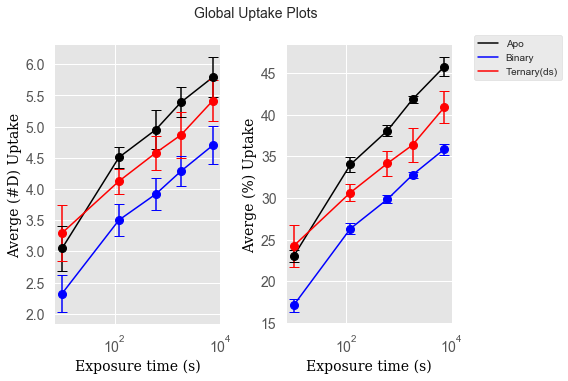

In [250]:

ruvc_df =domain_slection(df, domains = ruvc)
ruvc_df = global_df(ruvc_df)
uptake_plots(ruvc_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

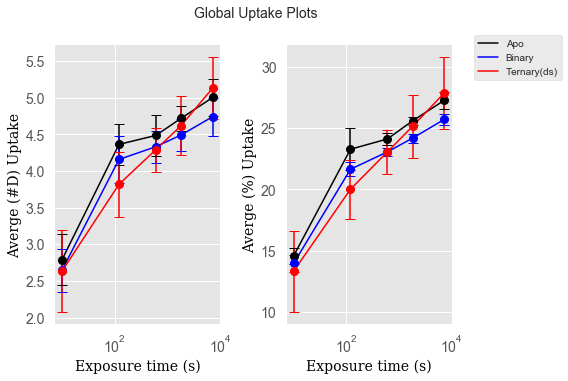

In [251]:
pi_df =domain_slection(df, domains = pi)
pi_df = global_df(pi_df)
uptake_plots(pi_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

In [261]:
nuc_df =domain_slection(df, domains = nuc)
len(nuc_df)

100

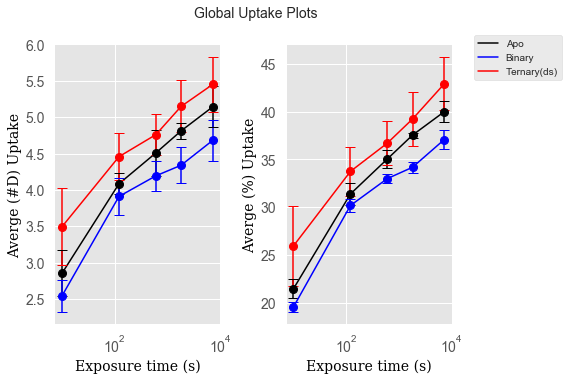

In [265]:
nuc_df =domain_slection(df, domains = nuc)
nuc_df = global_df(nuc_df)
uptake_plots(nuc_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

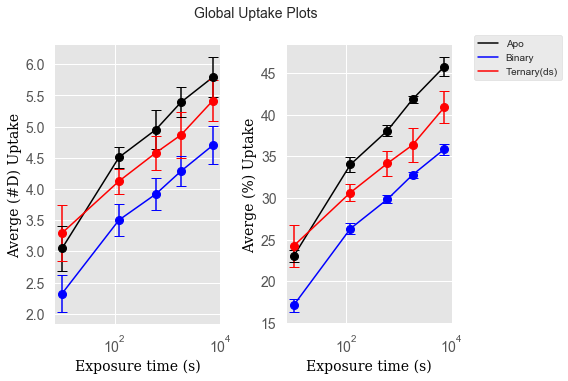

In [264]:
ruvc_df =domain_slection(df, domains = ruvc)
ruvc_df = global_df(ruvc_df)
uptake_plots(ruvc_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

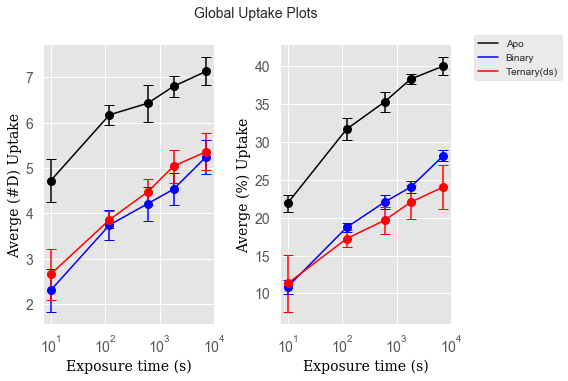

In [262]:
wedge_df =domain_slection(df, domains = wedge)
wedge_df = global_df(wedge_df)
uptake_plots(wedge_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

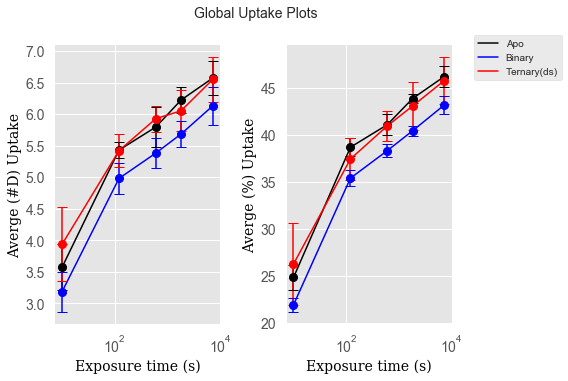

In [263]:
rec_df =domain_slection(df, domains = rec)
rec_df = global_df(rec_df)
uptake_plots(rec_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

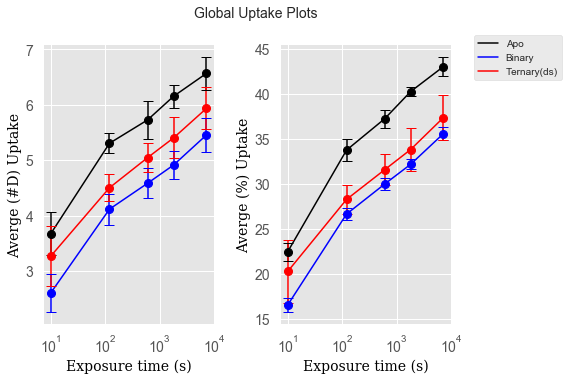

In [241]:

global_df = global_df(df)
uptake_plots(global_df, plot_states = ["Apo", 'Binary', "Ternary(ds)"], pdf =True)

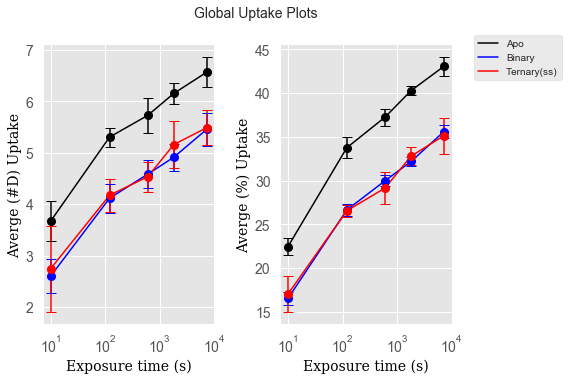

In [230]:
uptake_plots( global_df, plot_states = ["Apo", 'Binary', "Ternary(ss)"], pdf =True)

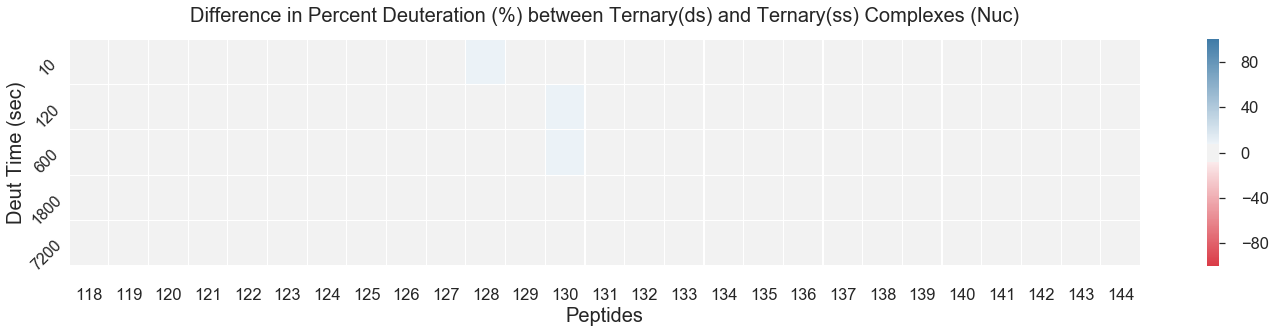

In [81]:
pl.heat_map(df, diff_state = ("Ternary(ds)","Ternary(ss)"), peptides =None,
             domains=  nuc,figsize=(20,5), pdf= True, tiff= False)

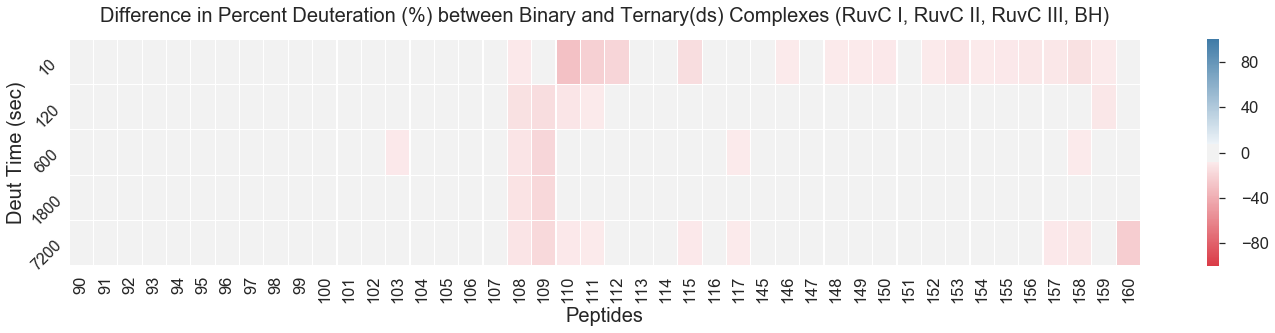

In [32]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ds)"), peptides =None,
             domains=  ruvc+bh,figsize=(20,5), pdf= True, tiff= False)

In [30]:
pep, idx = pl.pep_diff_sig_class(df, dstate=('Apo', "Binary"), st1_st2=True, er_da=2)
pep

array(['2. FVNKYSLSK (7-15) (WED I)',
       '3. TLRFELIPQGKTLENIKAR (16-34) (WED I - REC 1)',
       '4. TLRFELIPQGKTLENIKARGLIL (16-38) (WED I - REC 1)',
       '5. ELIPQGKTLENIKAR (20-34) (WED I - REC 1)',
       '6. ELIPQGKTLENIKARGLIL (20-38) (WED I - REC 1)',
       '7. IPQGKTLENIKAR (22-34) (WED I - REC 1)',
       '8. DDEKRAKDYKKAKQIIDKYHQF (39-60) (REC 1)',
       '13. FKNLFNQNLIDAKKGQESD (119-137) (REC 1)',
       '14. FKNLFNQNLIDAKKGQESDL (119-138) (REC 1)',
       '30. FVIDKLEDDSDVVTTMQSF (337-355) (REC 1 - REC 2)',
       '33. LKAQKLDLSKIYFKNDKSLTDLSQQV (381-406) (REC 2)',
       '44. FKLNFENSTLANGWDKNKEPDNTAIL (596-621) (WED II)',
       '45. FENSTLANGWDKNKEPDNTAIL (600-621) (WED II)',
       '46. STLANGWDKNKEPDNTAIL (603-621) (WED II)',
       '49. FIKDDKYYLGVMNKKNNKIFDDKAIKENKGEGYKK (622-656) (WED II)',
       '53. AIKENKGEGYKKIVYKLLPGANKMLPKVFF (645-674) (WED II - PI)',
       '68. FQIYNKDFSAYSKGRPNLHTLYWKAL (786-811) (WED III)',
       '69. YSKGRPNLHTL (796-806) (WED 

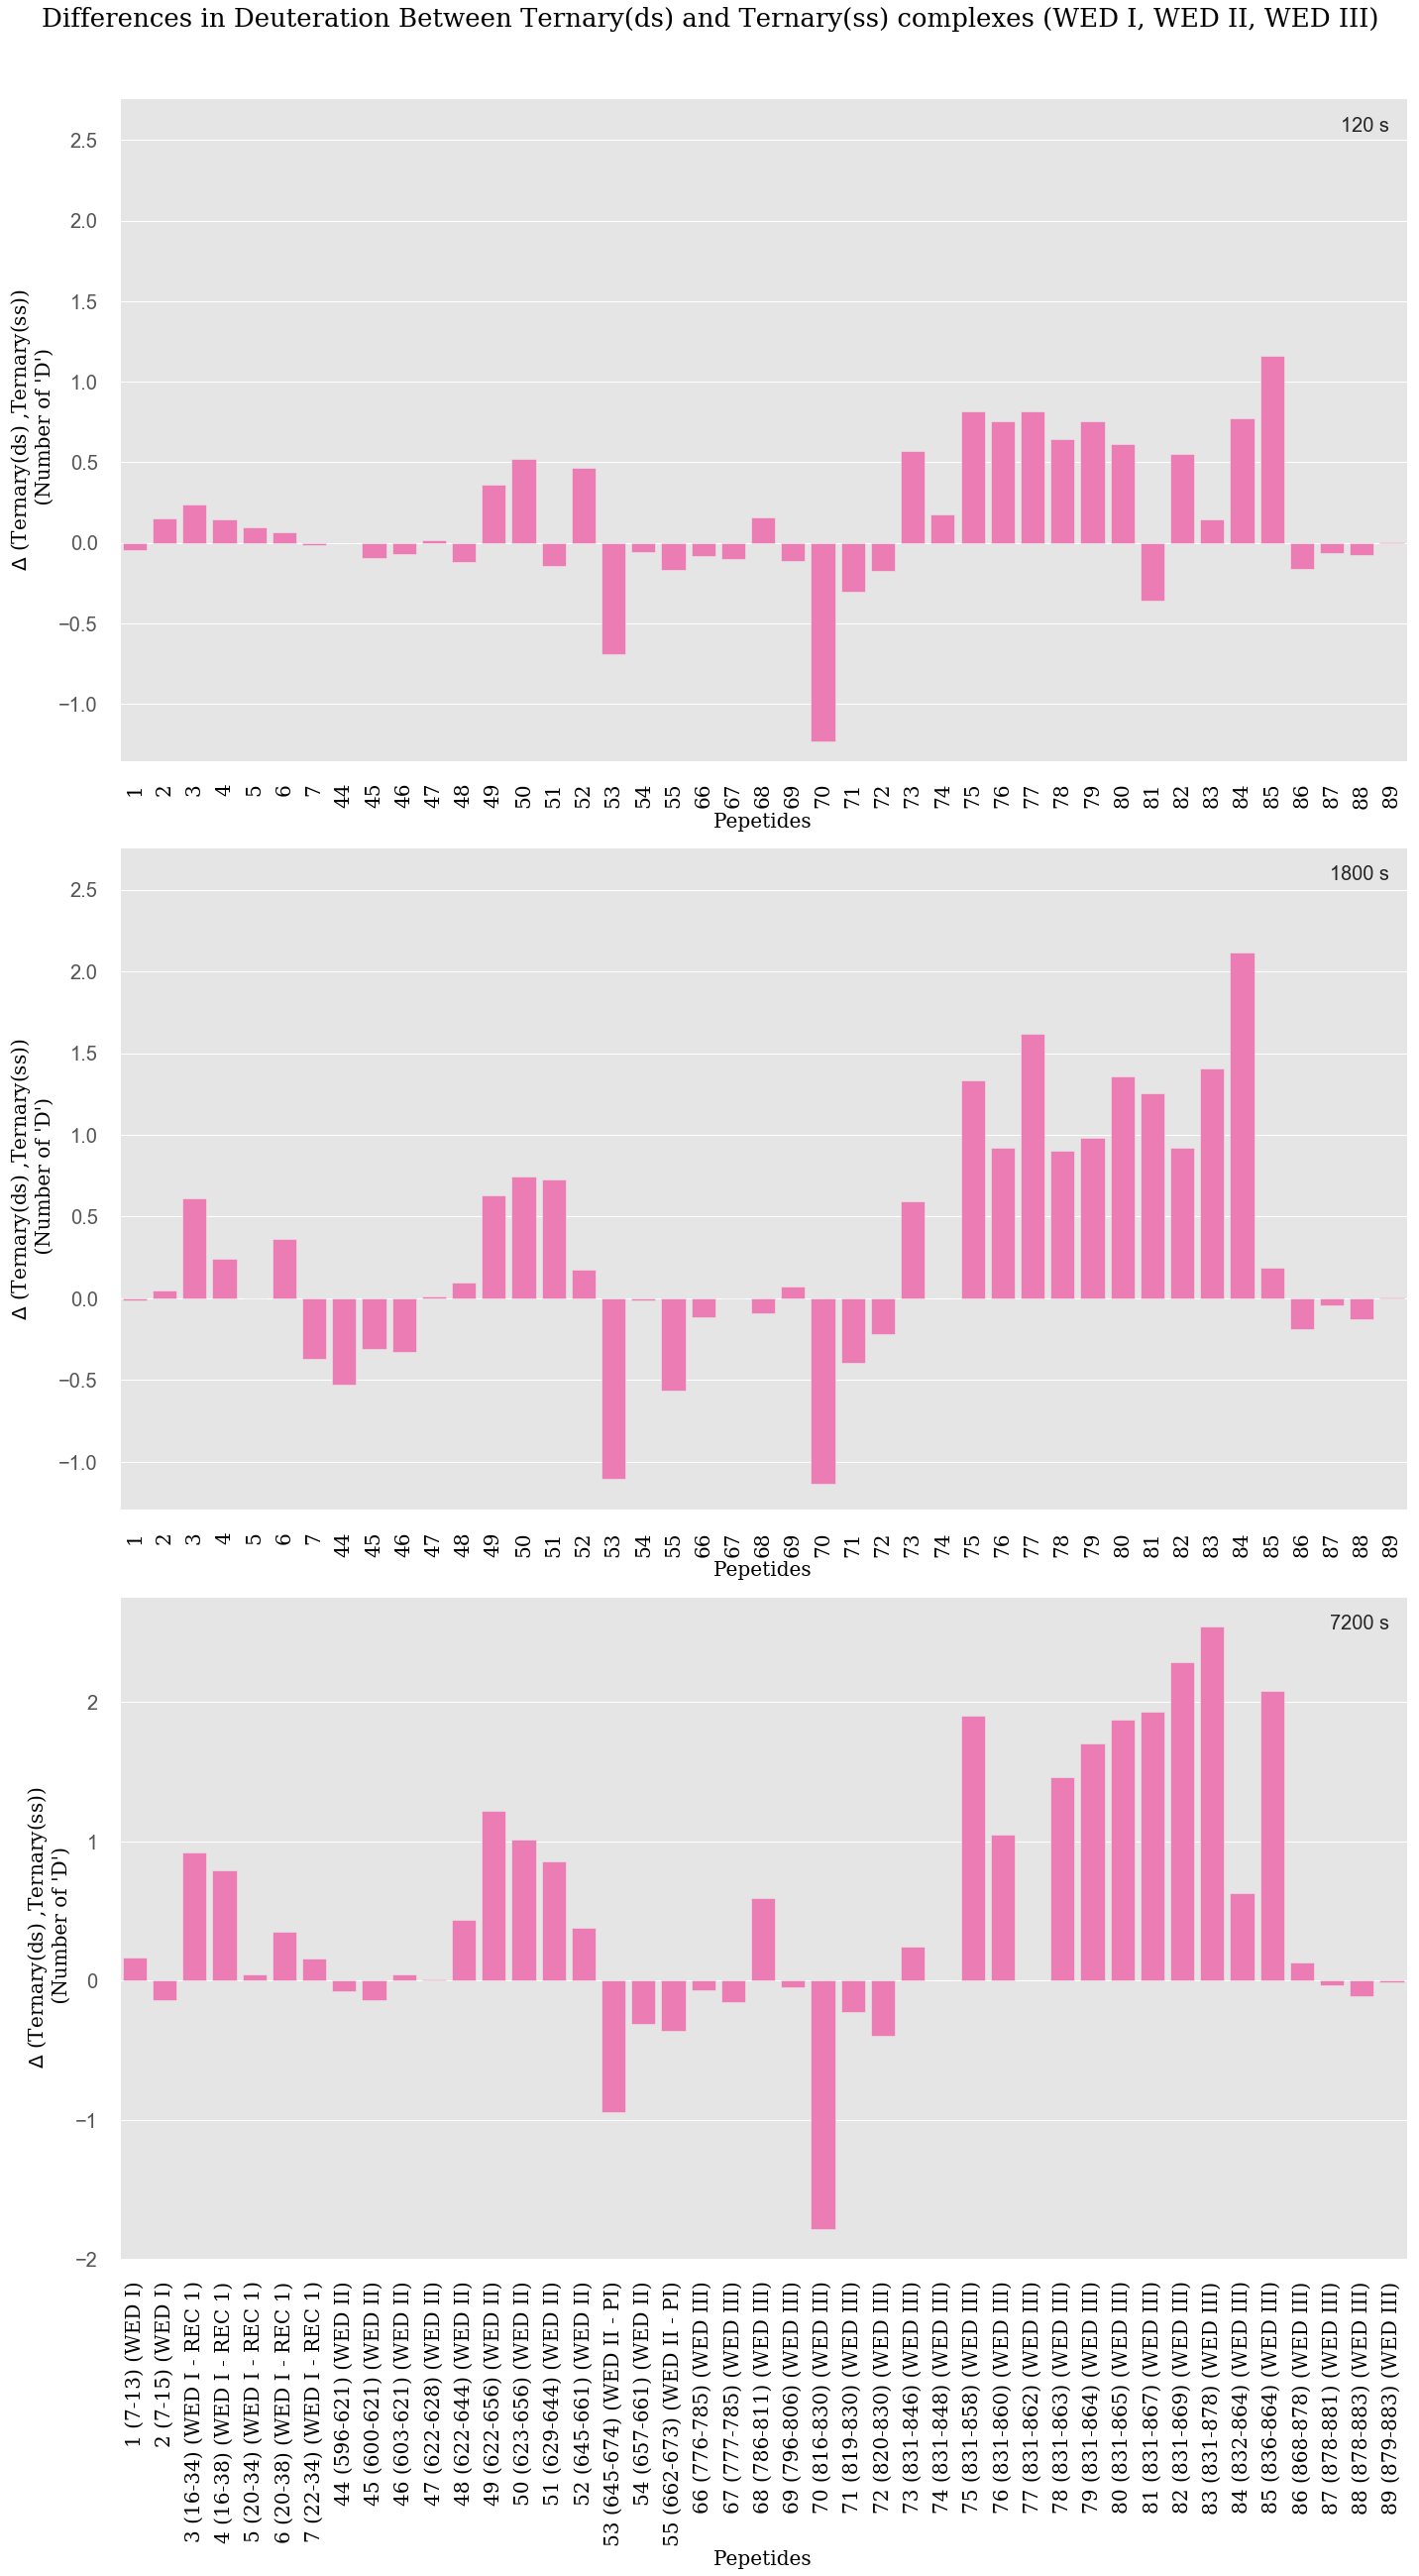

In [84]:
pl.barplots_timeseries(df,diff_state=( "Ternary(ds)", "Ternary(ss)"), timepoints = ["t2", "t4", "t5"],
                    plot_kind = "d",domains = wedge, pdf =True, figsize =(20,35))

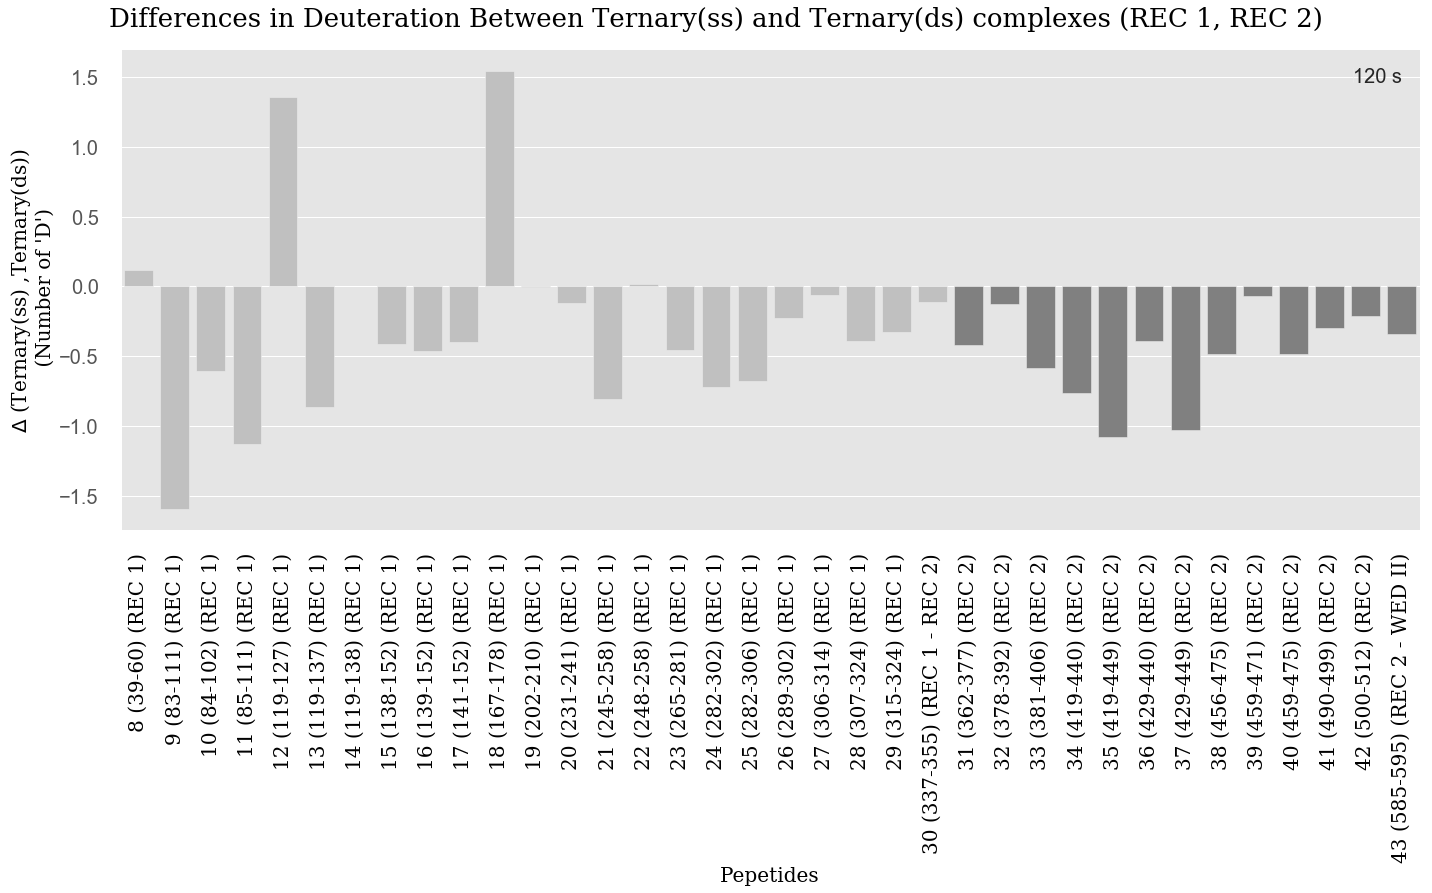

In [364]:
# Analyzing Rec 1 and Rec 2 domain
pl.barplots_timeseries(df,diff_state=("Ternary(ss)", "Ternary(ds)"), timepoints = ["t2"],  plot_kind = "d", peptides = None,
             domains =  rec, plot_style ="ggplot" ,
                 figsize =(20,12), pdf=False, tiff = False,name ="Rec1_Rec2")

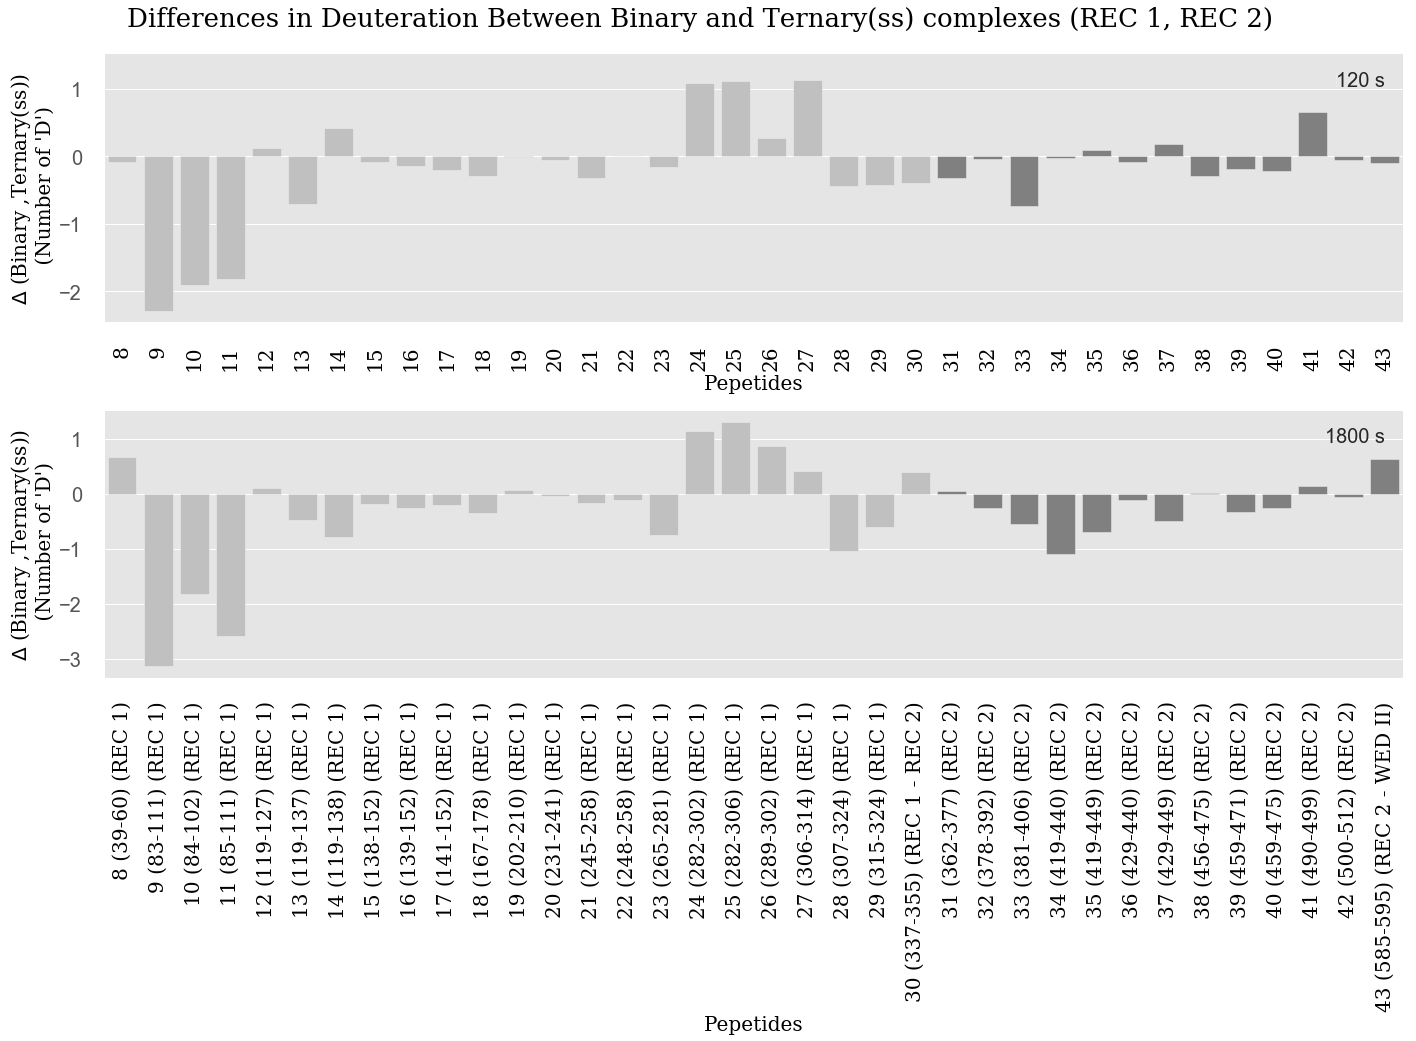

In [36]:
# Analyzing Rec 1 and Rec 2 domain
pl.barplots_timeseries(df,diff_state=("Binary", "Ternary(ss)"), timepoints = ["t2", "t4"],  plot_kind = "d", peptides = None,
             domains = rec, plot_style ="ggplot" ,
                 figsize =(20,14), pdf=False, tiff = False,name ="Rec1_Rec2")

In [37]:
dtt_pep, dtt_idx = pl.pep_diff_uptake_class(df, dstate=("Ternary(ss)", "Ternary(ds)"),)

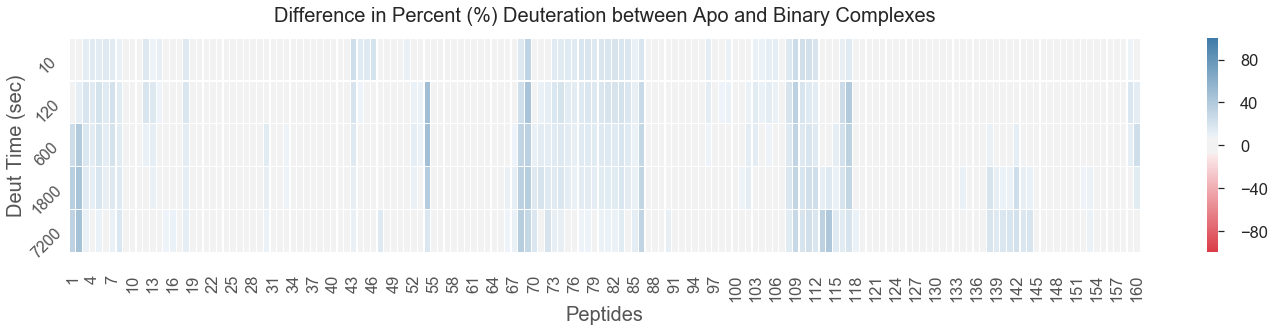

In [38]:
pl.heat_map(df, diff_state = ("Apo","Binary"), peptides =None,
             domains=  None,figsize=(20,5), pdf= True, tiff= False)

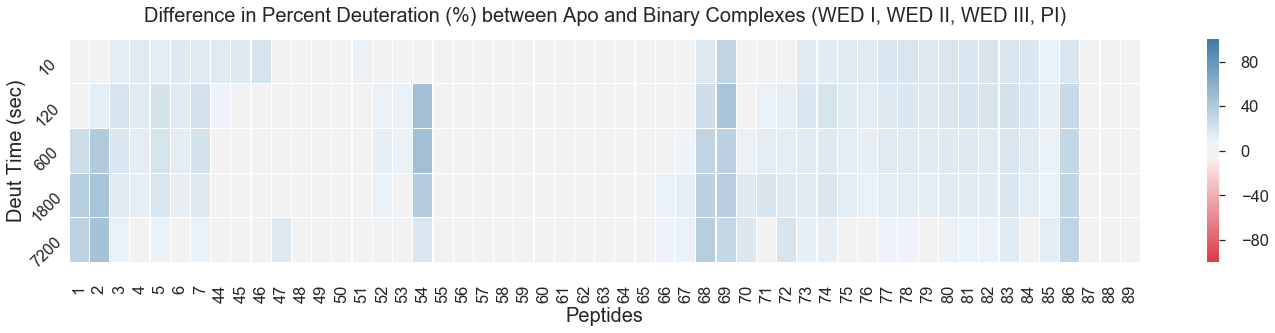

In [39]:
pl.heat_map(df, diff_state = ("Apo", "Binary"), peptides =None,
             domains=  wedge+pi,figsize=(20,5), pdf= True, tiff= False)

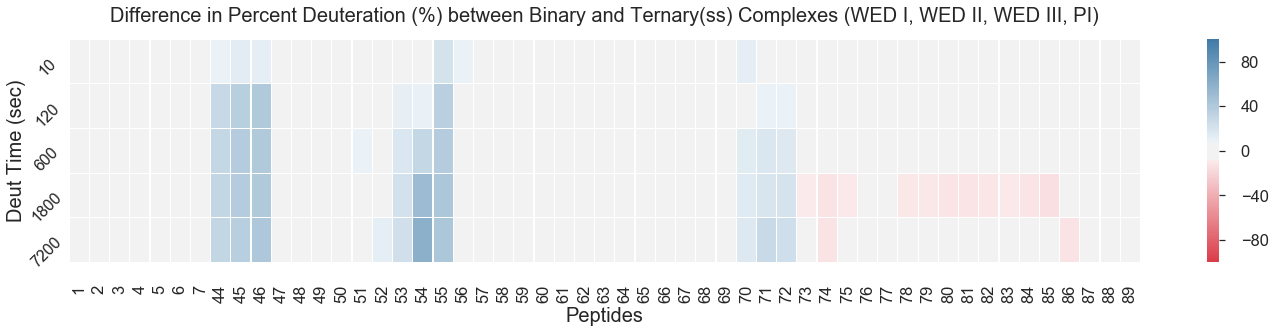

In [40]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ss)"), peptides =None,
             domains=  wedge+pi,figsize=(20,5), pdf= True, tiff= False)

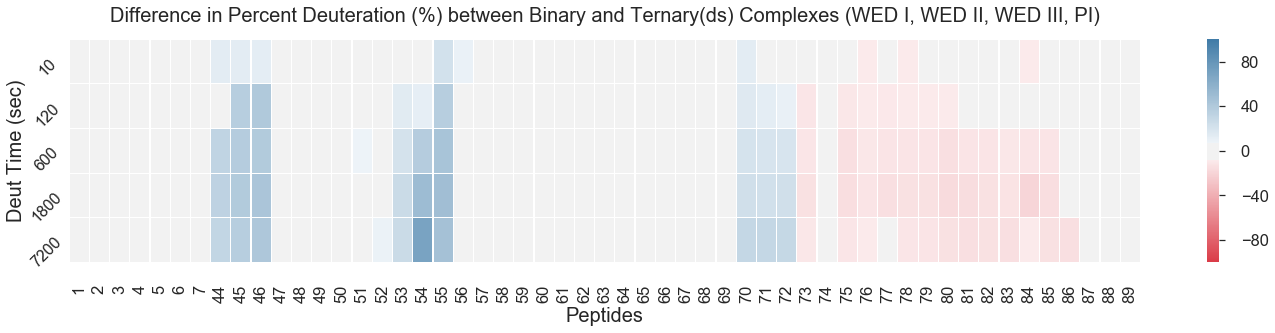

In [41]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ds)"), peptides =None,
             domains=  wedge+pi,figsize=(20,5), pdf= True, tiff= False)

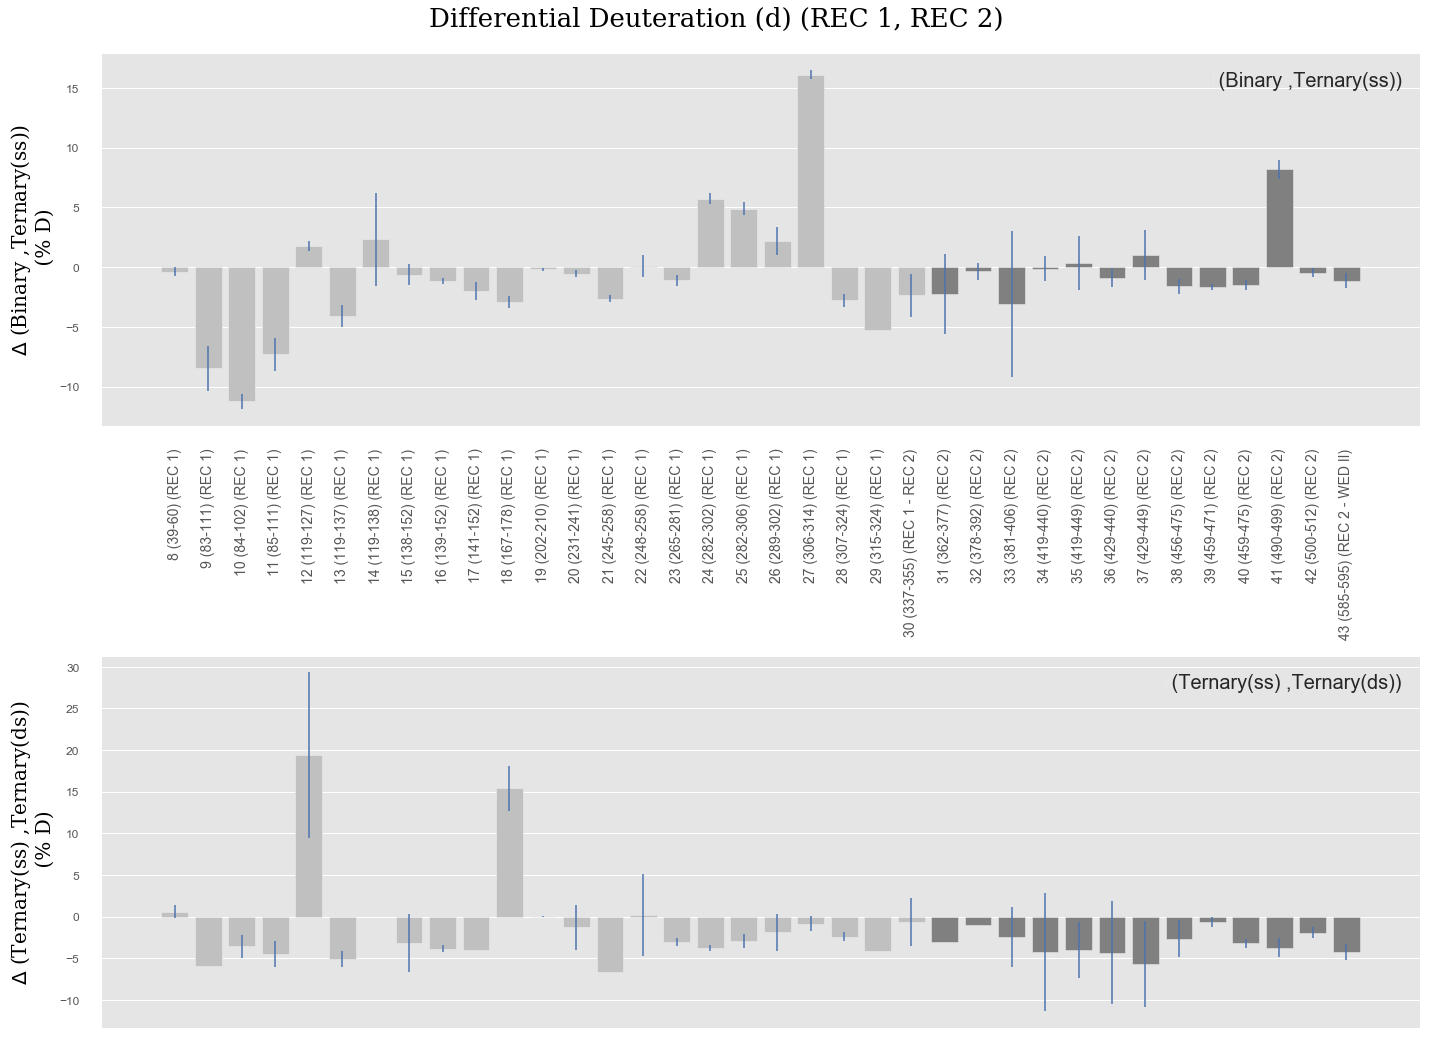

In [365]:
pl.barplots_multiple_states(df,diff_state=("Binary", "Ternary(ss)", "Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = rec, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="d", error_bar= True,
                 pdf=False, tiff = False,name ="Barplots")

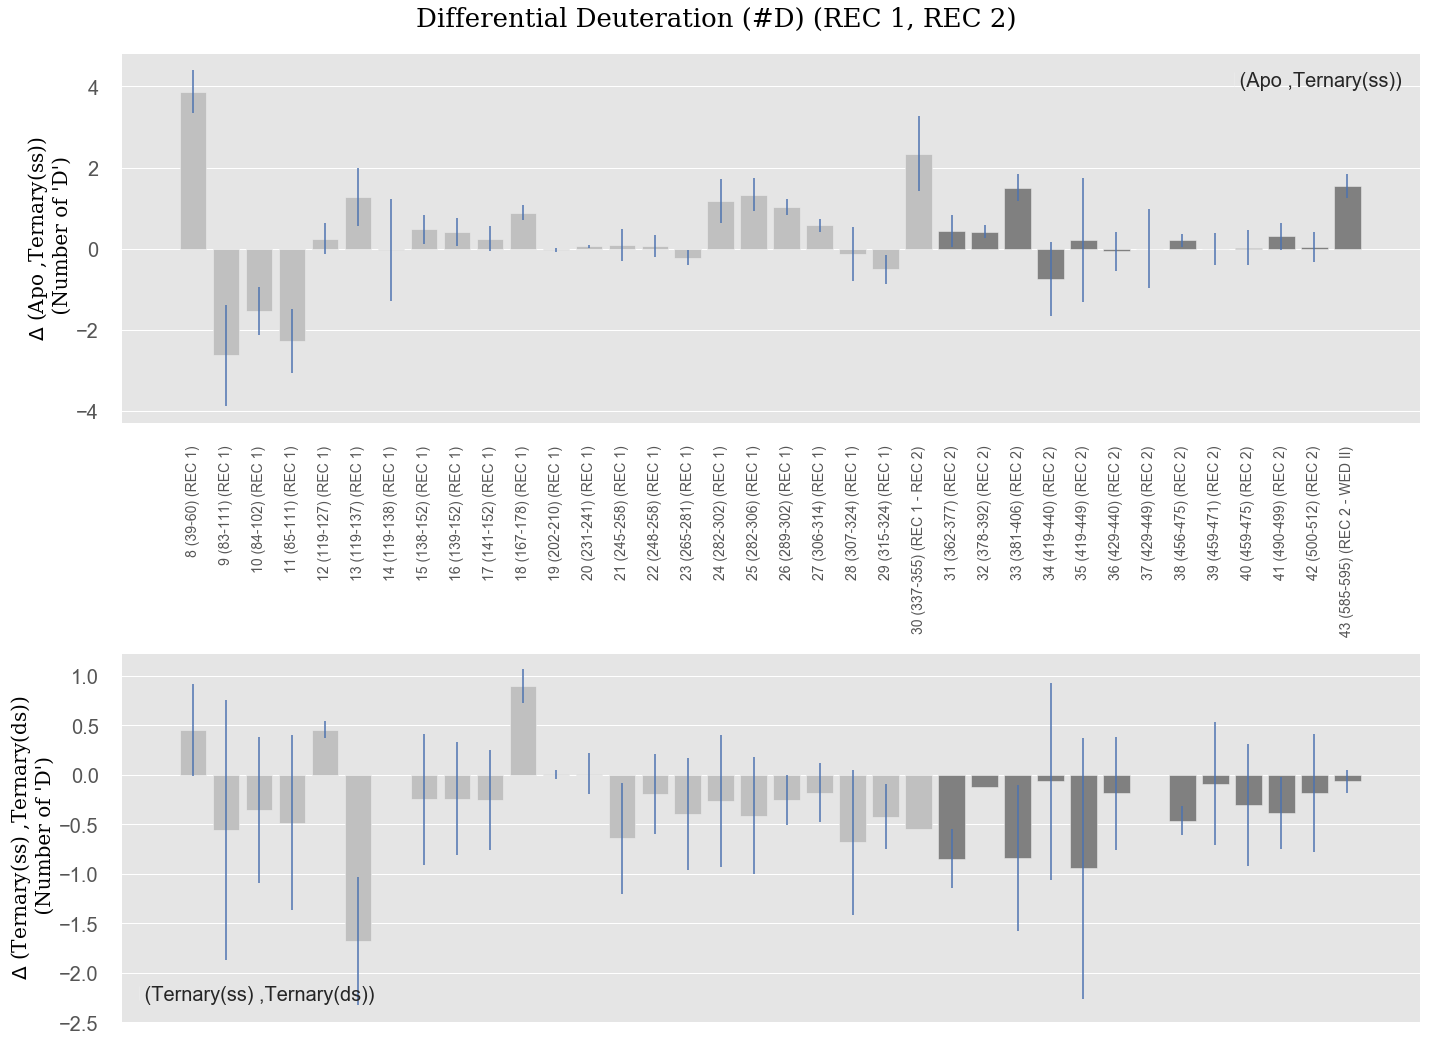

In [370]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Ternary(ss)", "Ternary(ds)"), timepoint = "t4", peptides = None,
             domains = rec, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= True,
                 pdf=False, tiff = False,name ="Barplots")

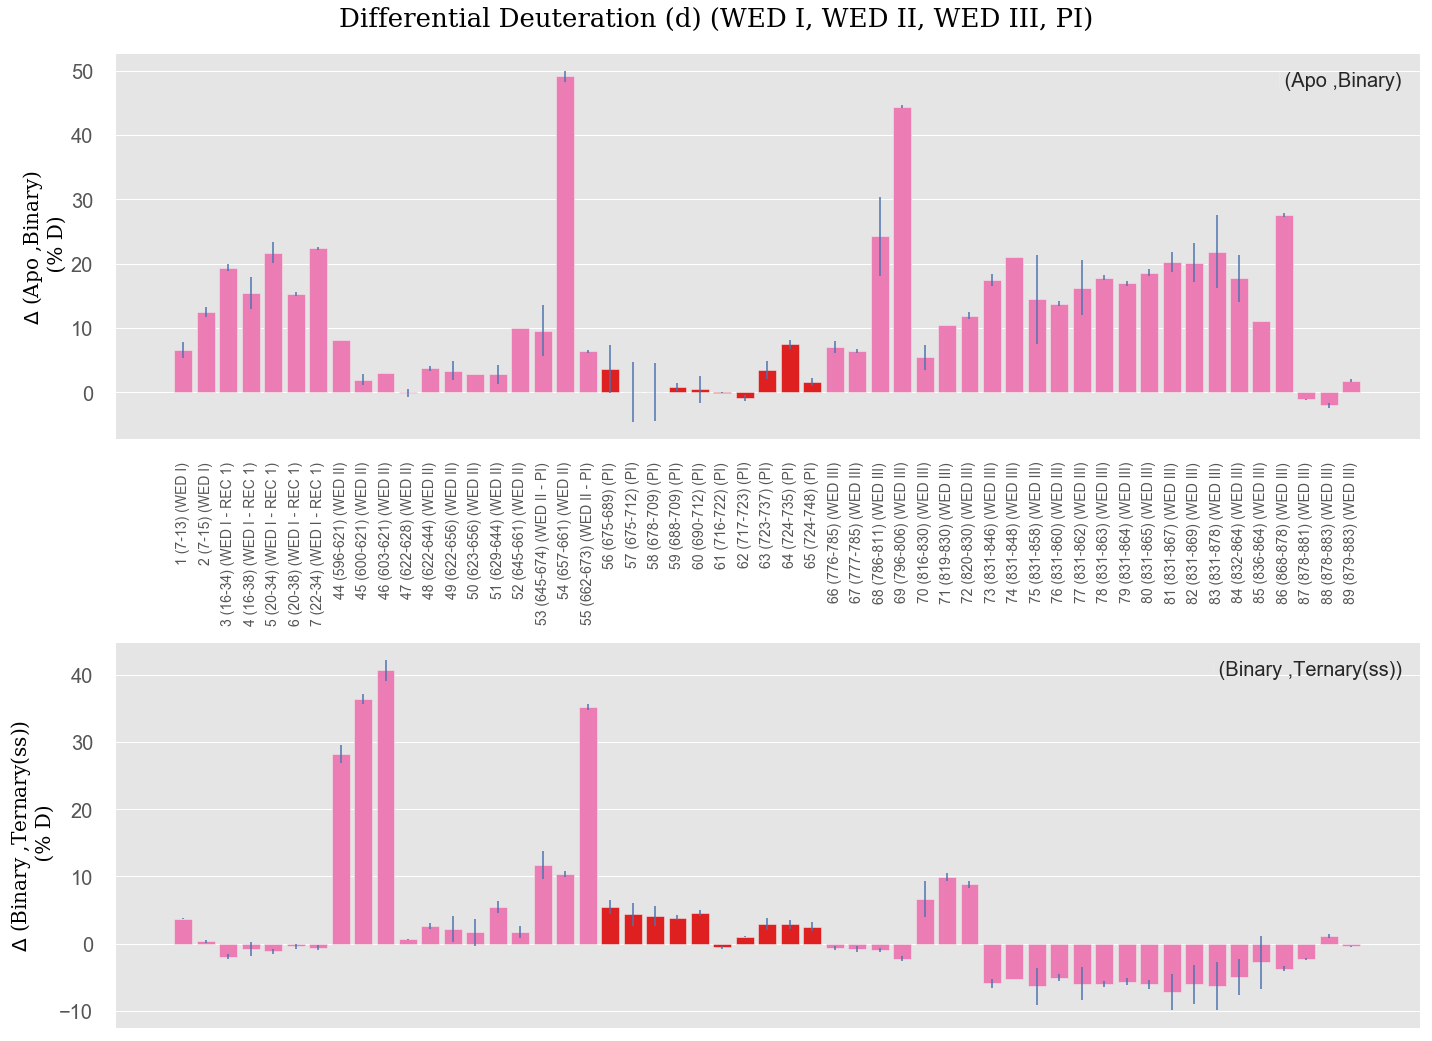

In [46]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ss)"), timepoint = "t2", peptides = None,
             domains = wedge+pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="d", error_bar= True,
                 pdf=False, tiff = False,name ="Barplots")

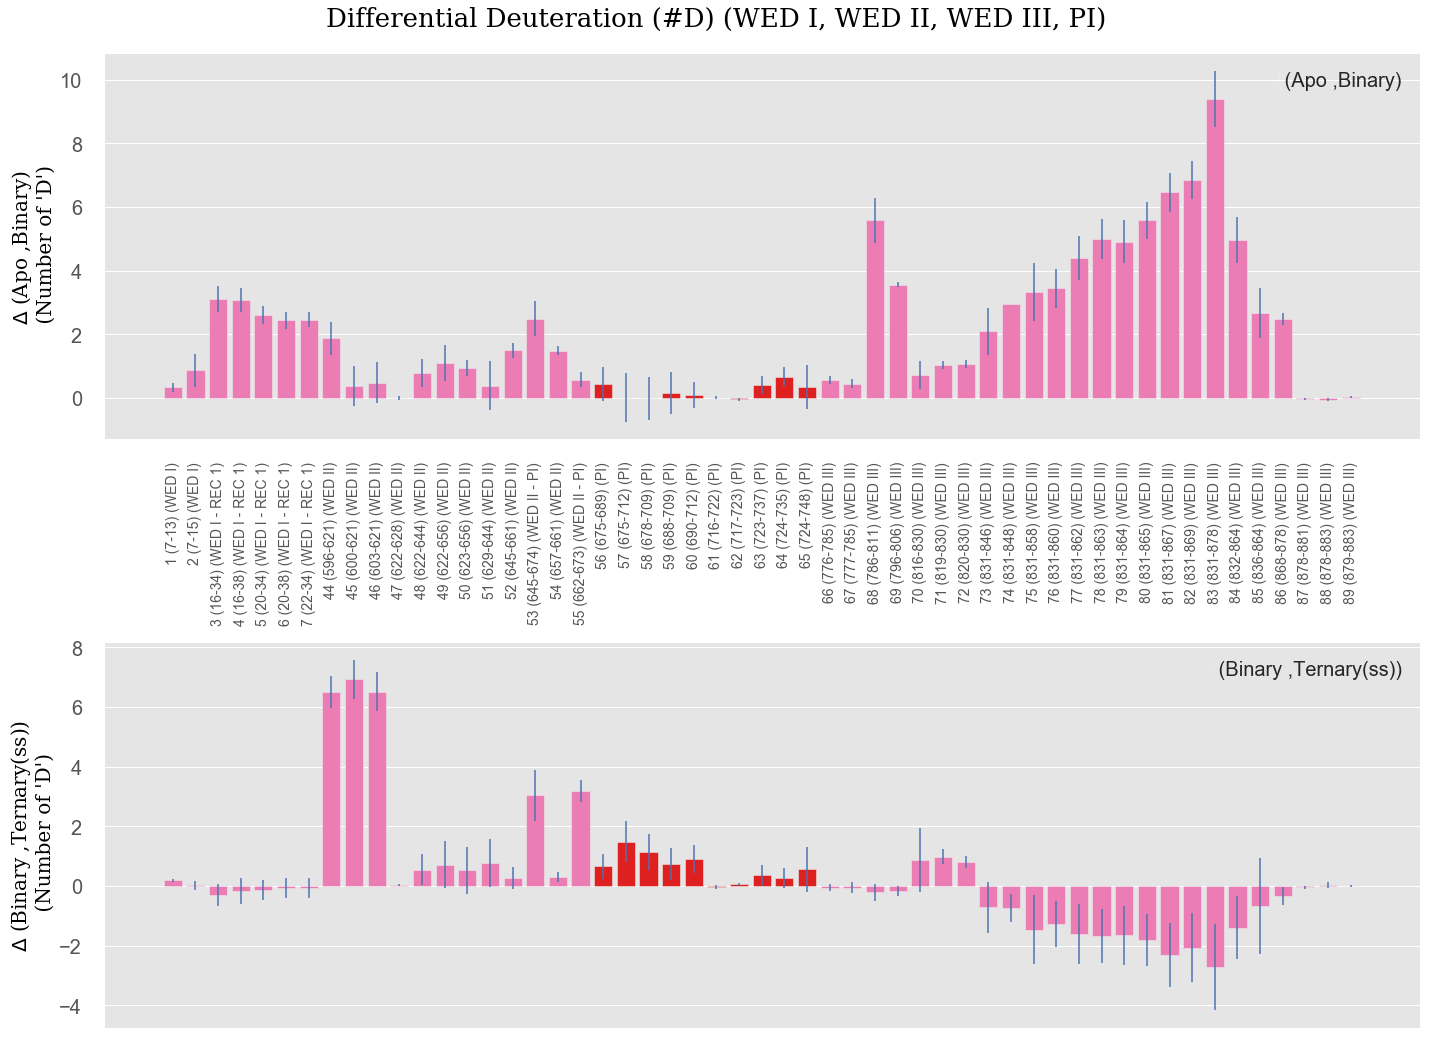

In [47]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ss)"), timepoint = "t2", peptides = None,
             domains = wedge +pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= True,
                 pdf=True, tiff = False)

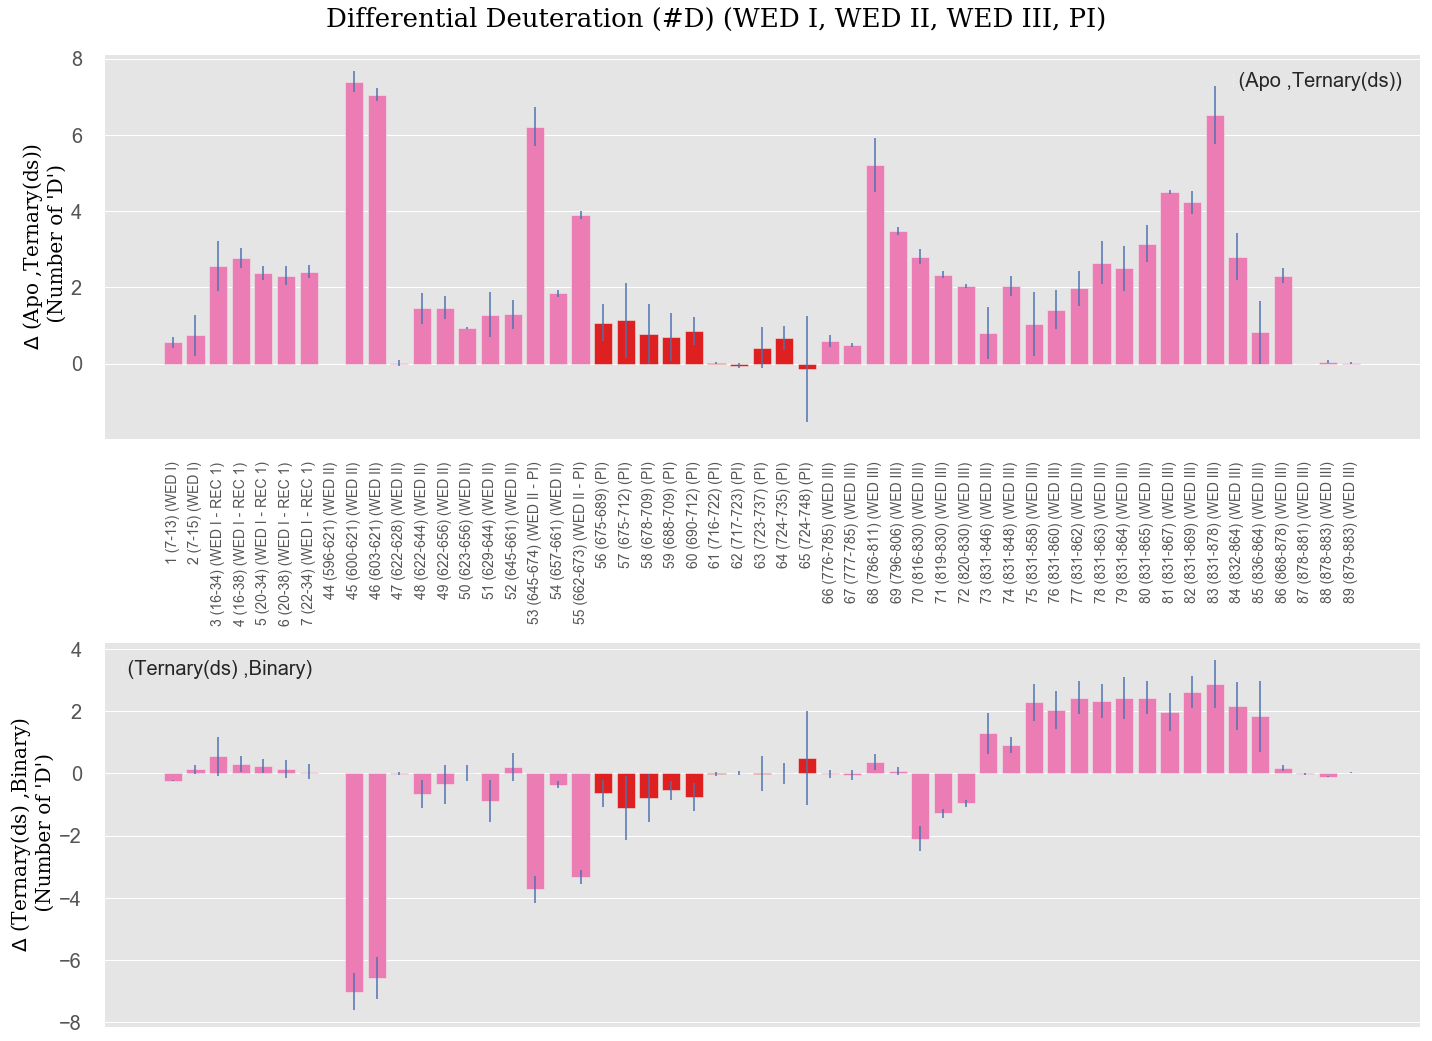

In [48]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Ternary(ds)", "Binary",), timepoint = "t2", peptides = None,
             domains = wedge +pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= True,
                 pdf=True, tiff = False)

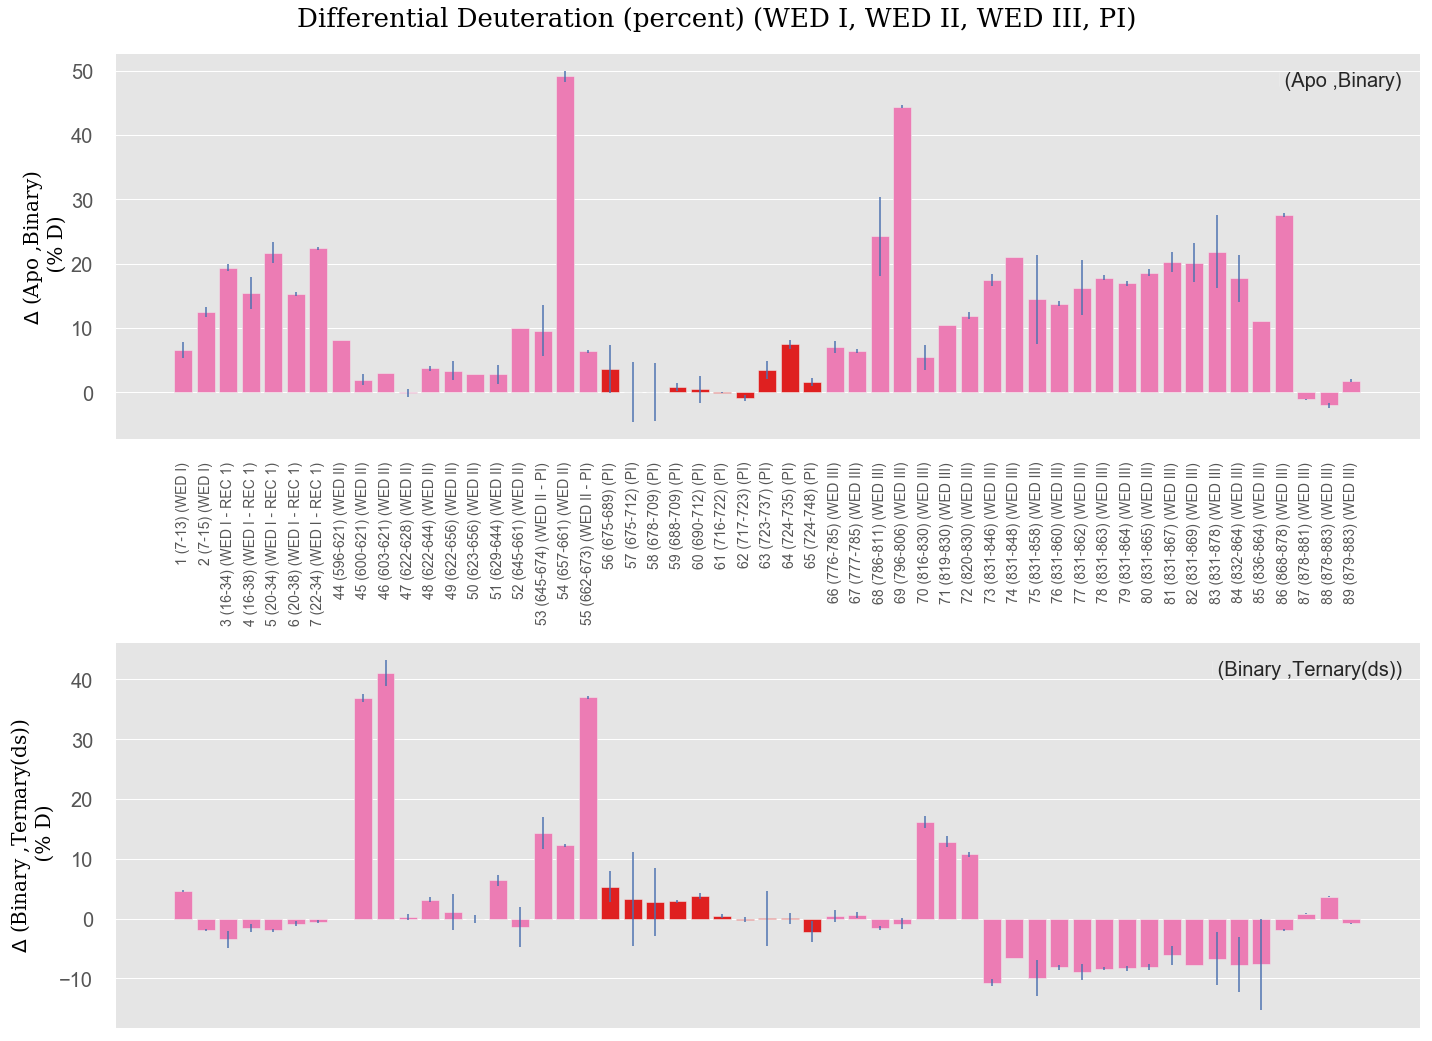

In [49]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = wedge+pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="percent", error_bar= True,
                 pdf=True, tiff = False)

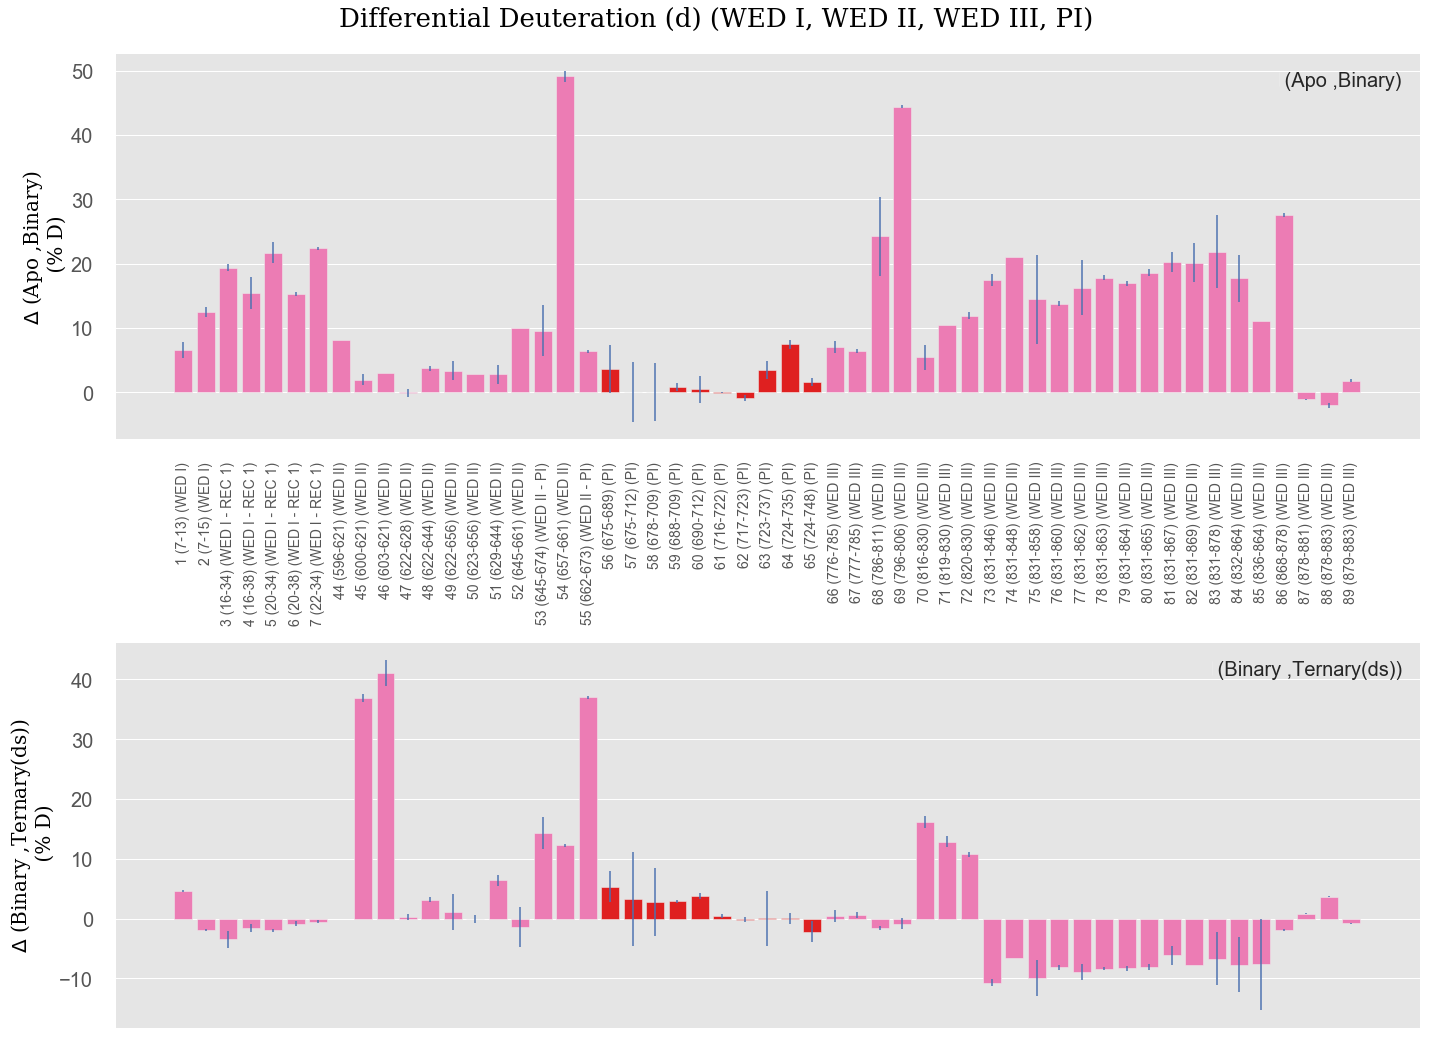

In [50]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = wedge+pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="d", error_bar= True,
                 pdf=True, tiff = False,name ="Barplots")

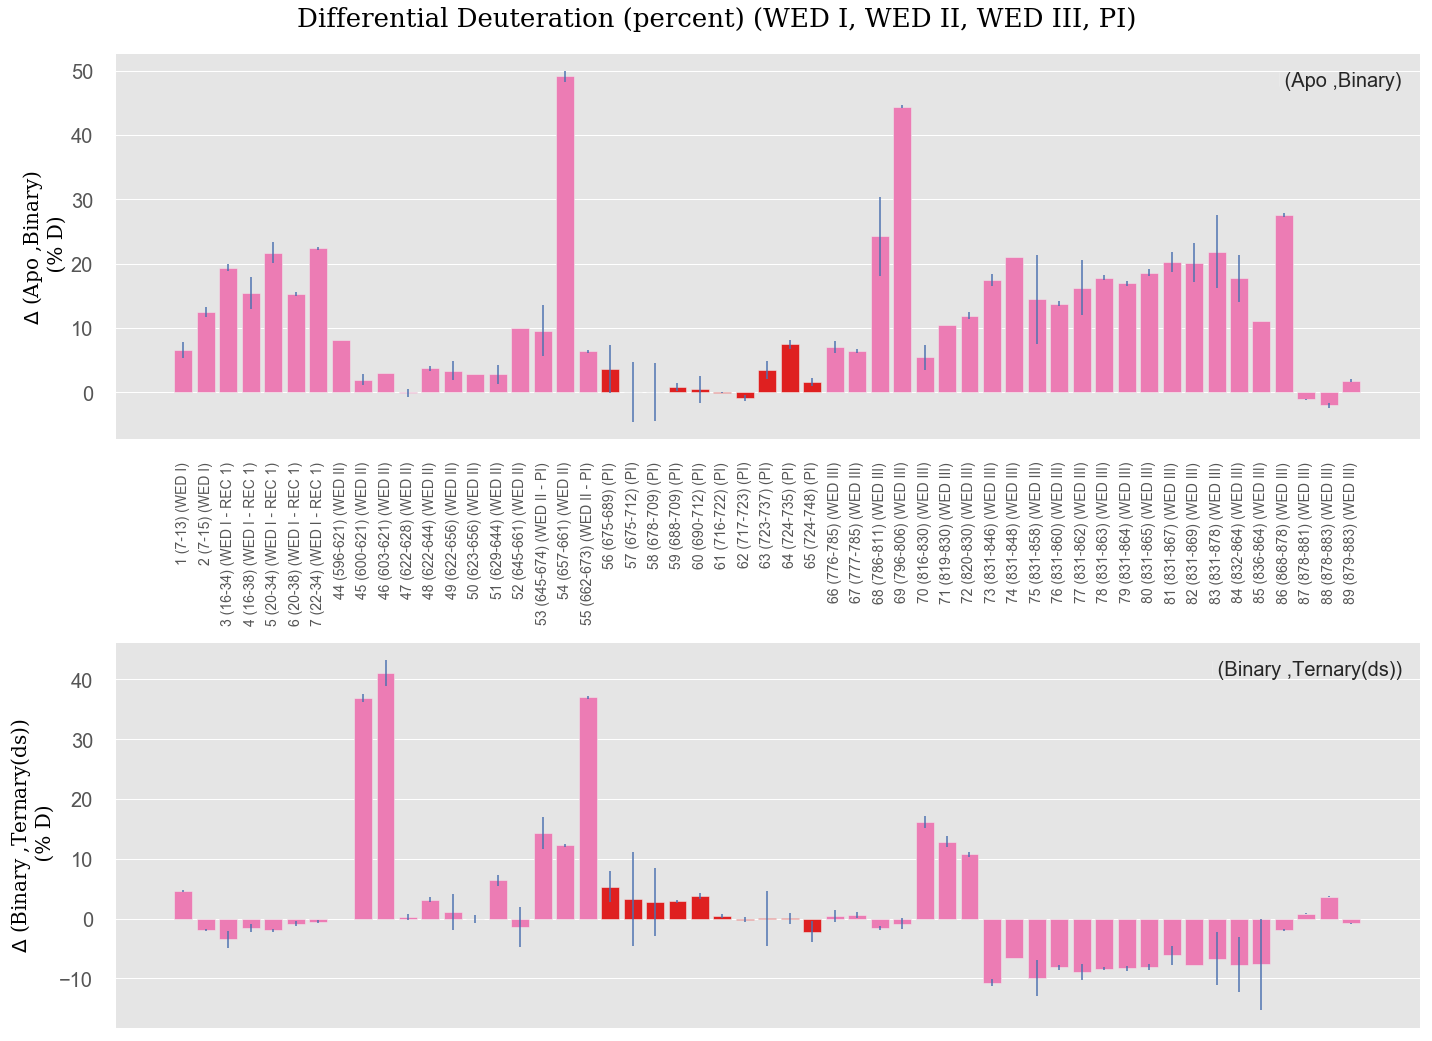

In [51]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = wedge+pi, plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="percent", error_bar= True,
                 pdf=True, tiff = False)

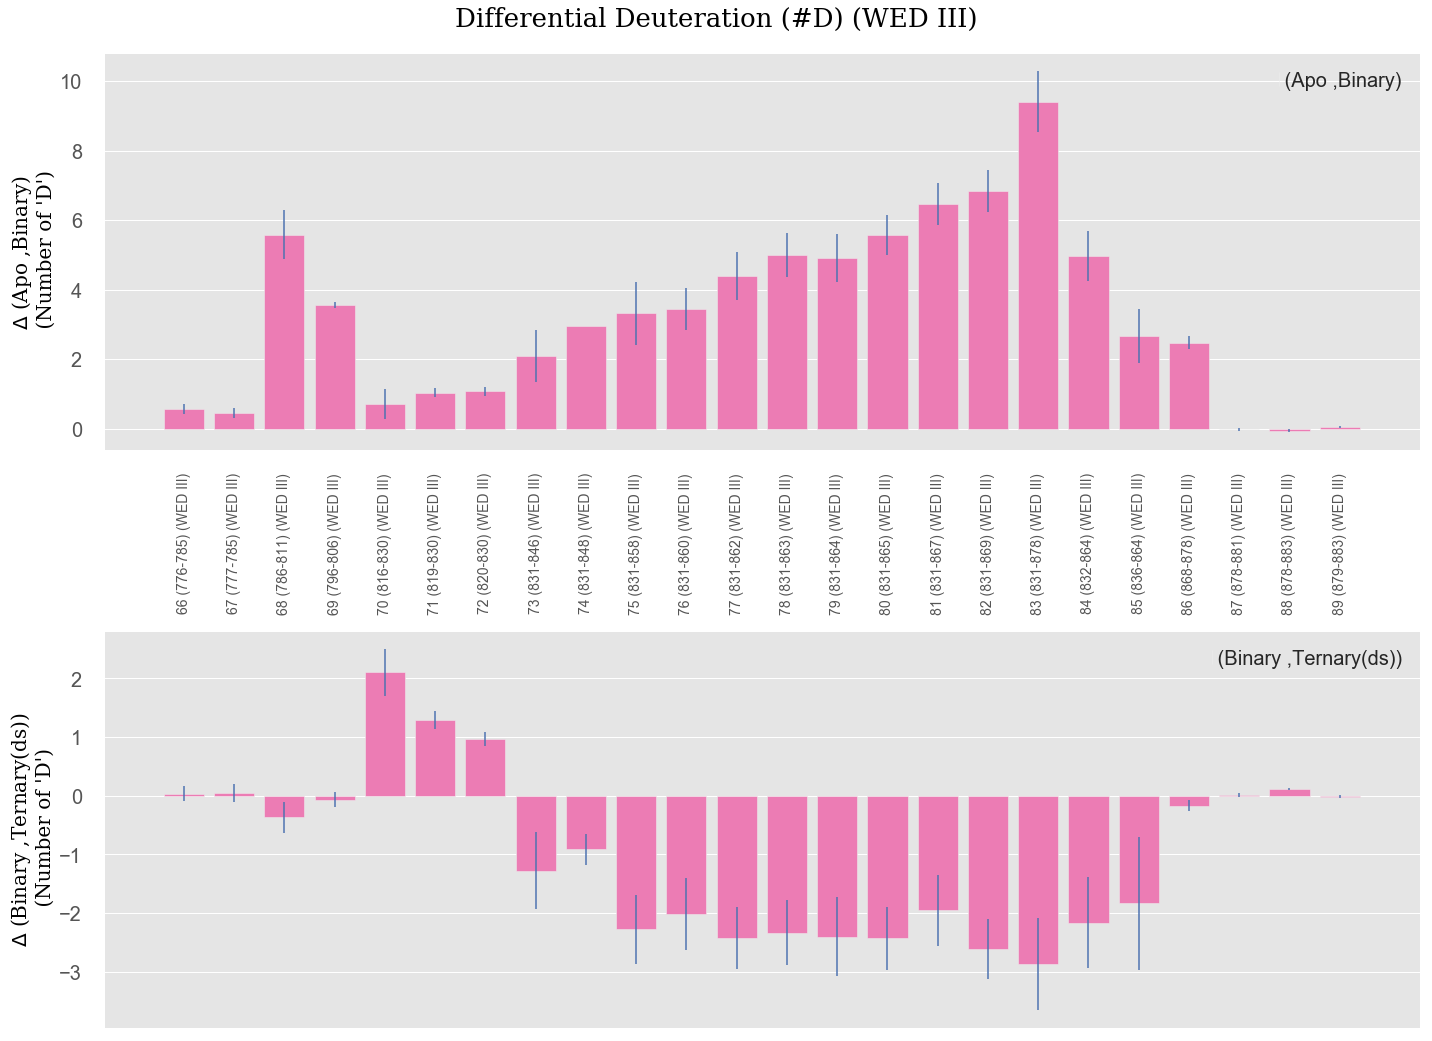

In [52]:
pl.barplots_multiple_states(df,diff_state=("Apo", "Binary", "Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = ["WED III"], plot_style ="ggplot" ,
                 figsize =(20,14), plot_kind="#D", error_bar= True,
                 pdf=True, tiff = False)

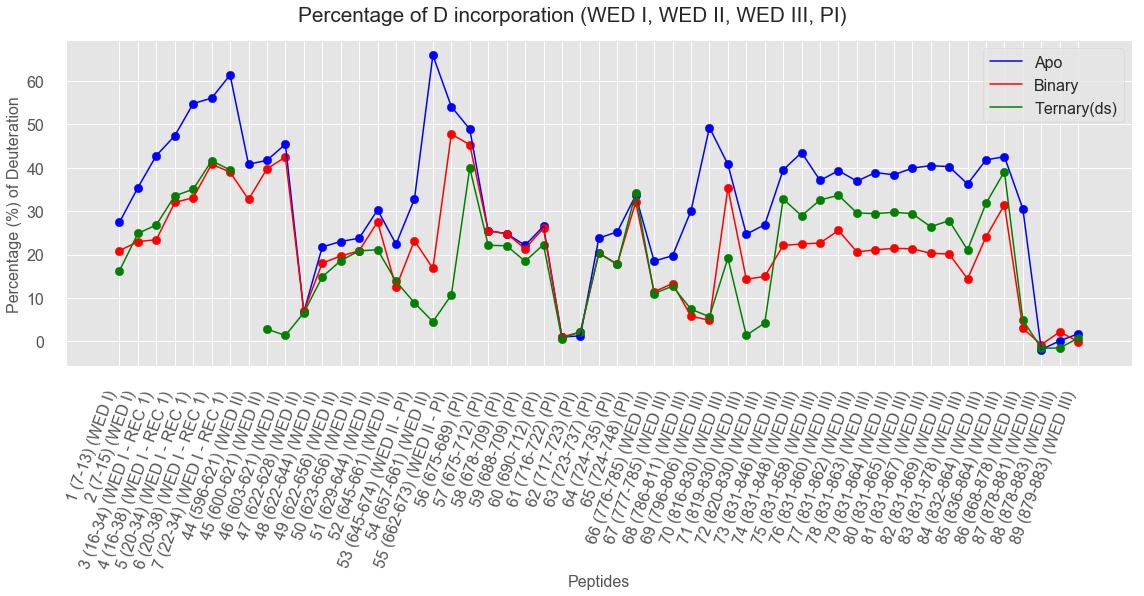

In [53]:
pl.scatter_plot(df, domains = wedge +pi, states = ["Apo", "Binary", "Ternary(ds)"], timepoint = "t2",
                    figsize =(16,8), pdf = True)

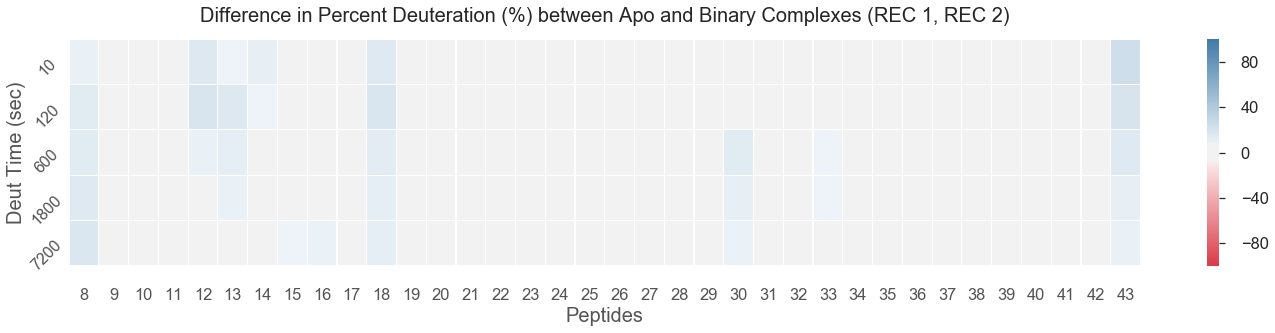

In [54]:
pl.heat_map(df, diff_state = ("Apo","Binary"), peptides =None,
             domains=  rec,figsize=(20,5), pdf= True, tiff= False)

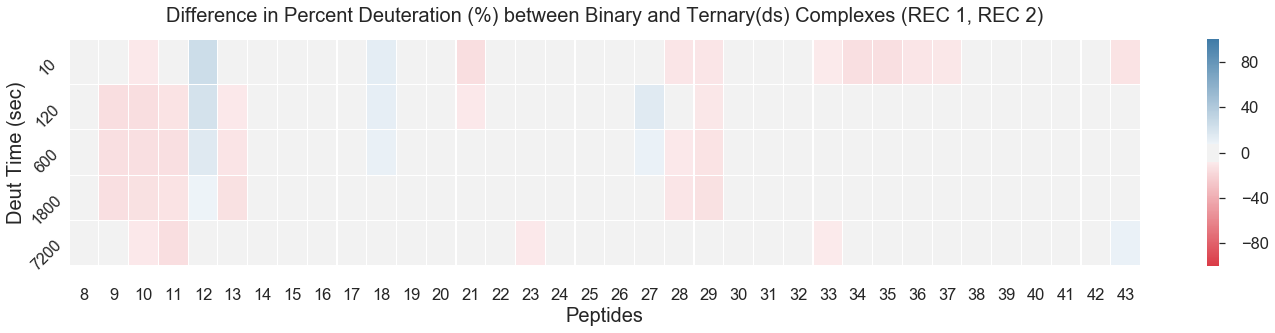

In [55]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ds)"), peptides =None,
             domains=  rec,figsize=(20,5), pdf= True, tiff= False)

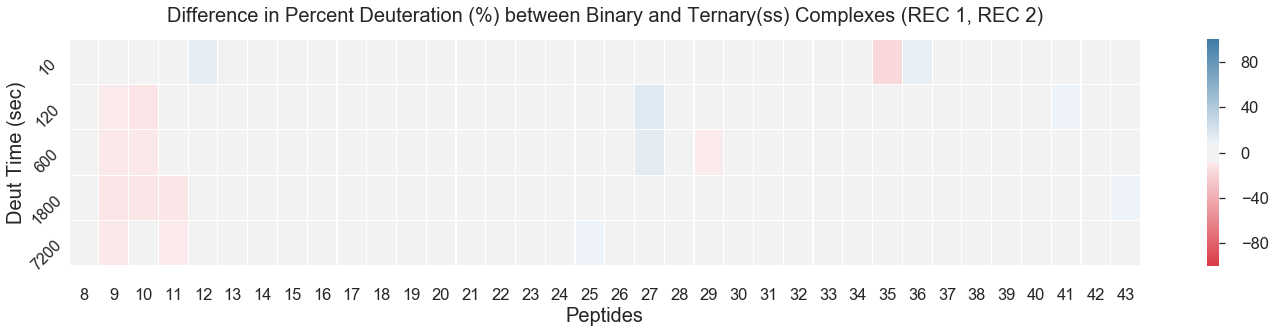

In [56]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ss)"), peptides =None,
             domains=  rec,figsize=(20,5), pdf= True, tiff= False)

In [57]:
df[['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
       '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
       'Stddev_Apo', 'p_Apo', ]].loc[[53,54,55]]

Start  End                        Sequence  Deut Time (sec)  maxD  \
idx                                                                      
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF               10    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF              120    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF              600    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF             1800    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF             7200    26   
54     657  661                           IVYKL               10     3   
54     657  661                           IVYKL              120     3   
54     657  661                           IVYKL              600     3   
54     657  661                           IVYKL             1800     3   
54     657  661                           IVYKL             7200     3   
55     662  673                    LPGANKMLPKVF               10     9   
55     662  673                    LPGANKMLPKVF              120     9   
55     662  673                    LPGANKMLPKVF              600     9   
55     662  673                    LPGANKMLPKVF             1800     9   
55     662  673                    LPGANKMLPKVF             7200     9   

     #D_Apo  %D_Apo  Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                                    
53    3.955  15.210                   0.754       3.0         Medium   
53    8.529  32.805                   3.916       2.0         Medium   
53   10.635  40.905                   1.000       3.0         Medium   
53   11.106  42.717                   0.305       3.0         Medium   
53   11.196  43.060                   0.999       3.0         Medium   
54    0.194   6.480                   0.140       3.0           High   
54    1.978  65.930                   0.781       2.0           High   
54    2.686  89.545                   0.217       3.0         Medium   
54    2.741  91.352                   0.156       3.0           High   
54    2.739  91.284                   0.036       3.0         Medium   
55    2.755  30.610                   0.207       6.0         Medium   
55    4.869  54.104                   0.145       4.0         Medium   
55    5.655  62.832                   0.215       6.0         Medium   
55    5.891  65.453                   0.145       6.0         Medium   
55    5.792  64.355                   0.138       6.0         Medium   

     Stddev_Apo  p_Apo  
idx                     
53        0.303    NaN  
53        0.436    NaN  
53        0.403    NaN  
53        0.123    NaN  
53        0.402    NaN  
54        0.056    NaN  
54        0.087    NaN  
54        0.087    NaN  
54        0.063    NaN  
54        0.014    NaN  
55        0.197    NaN  
55        0.091    NaN  
55        0.205    NaN  
55        0.138    NaN  
55        0.131    NaN

In [58]:
df.loc[[53, 54,55]]

Start  End                        Sequence  Deut Time (sec)  maxD  \
idx                                                                      
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF               10    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF              120    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF              600    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF             1800    26   
53     645  674  AIKENKGEGYKKIVYKLLPGANKMLPKVFF             7200    26   
54     657  661                           IVYKL               10     3   
54     657  661                           IVYKL              120     3   
54     657  661                           IVYKL              600     3   
54     657  661                           IVYKL             1800     3   
54     657  661                           IVYKL             7200     3   
55     662  673                    LPGANKMLPKVF               10     9   
55     662  673                    LPGANKMLPKVF              120     9   
55     662  673                    LPGANKMLPKVF              600     9   
55     662  673                    LPGANKMLPKVF             1800     9   
55     662  673                    LPGANKMLPKVF             7200     9   

     #D_Apo  %D_Apo  Conf Interval (#D)_Apo  #Pts_Apo Confidence_Apo  \
idx                                                                    
53    3.955  15.210                   0.754       3.0         Medium   
53    8.529  32.805                   3.916       2.0         Medium   
53   10.635  40.905                   1.000       3.0         Medium   
53   11.106  42.717                   0.305       3.0         Medium   
53   11.196  43.060                   0.999       3.0         Medium   
54    0.194   6.480                   0.140       3.0           High   
54    1.978  65.930                   0.781       2.0           High   
54    2.686  89.545                   0.217       3.0         Medium   
54    2.741  91.352                   0.156       3.0           High   
54    2.739  91.284                   0.036       3.0         Medium   
55    2.755  30.610                   0.207       6.0         Medium   
55    4.869  54.104                   0.145       4.0         Medium   
55    5.655  62.832                   0.215       6.0         Medium   
55    5.891  65.453                   0.145       6.0         Medium   
55    5.792  64.355                   0.138       6.0         Medium   

                ...              Apo_Ternary(ds)_ci  Binary_Apo_ci  \
idx             ...                                                  
53              ...                        4.039985       1.151267   
53              ...                        4.655142       3.999503   
53              ...                        1.371074       1.455077   
53              ...                        3.879009       0.673071   
53              ...                        3.205638       1.181059   
54              ...                        0.184391       0.181177   
54              ...                        0.781400       0.830013   
54              ...                        0.255566       0.425494   
54              ...                        0.318779       0.317907   
54              ...                        0.536210       0.065734   
55              ...                        0.249898       0.368611   
55              ...                        0.167075       0.277838   
55              ...                        0.272239       0.242423   
55              ...                        0.417020       0.195412   
55              ...                        0.280321       0.248783   

     Binary_Ternary(ss)_ci  Binary_Ternary(ds)_ci  Ternary(ss)_Apo_ci  \
idx                                                                     
53                1.254638               4.063233            1.177171   
53                2.106233               2.645044            4.371533   
53               11.594282            

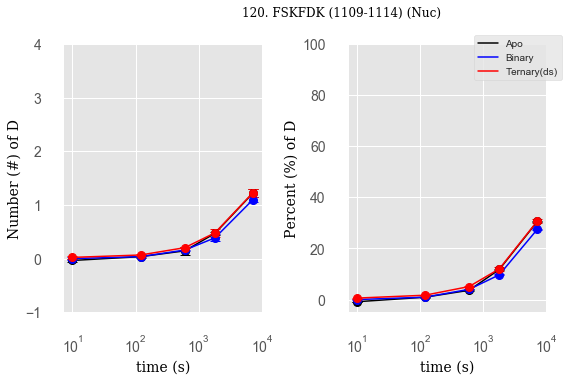

In [39]:

pl.uptake_plots(df, plot_states=["Apo", "Binary","Ternary(ds)"], pep_class = [120], domains = None, pdf=True)

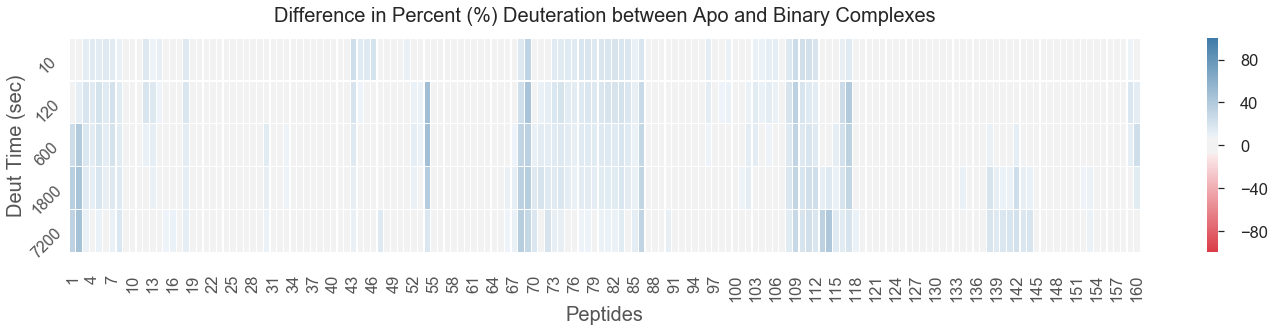

In [60]:
pl.heat_map(df, diff_state = ("Apo", "Binary"), peptides =None,
             domains=  None,figsize=(20,5), pdf= True, tiff= False)

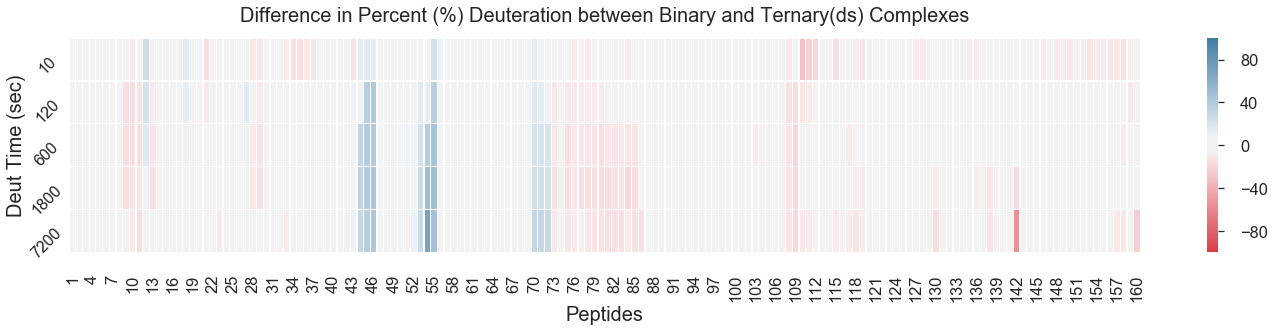

In [61]:
pl.heat_map(df, diff_state = ("Binary", "Ternary(ds)"), peptides =None,
             domains=  None,figsize=(20,5), pdf= True, tiff= False)

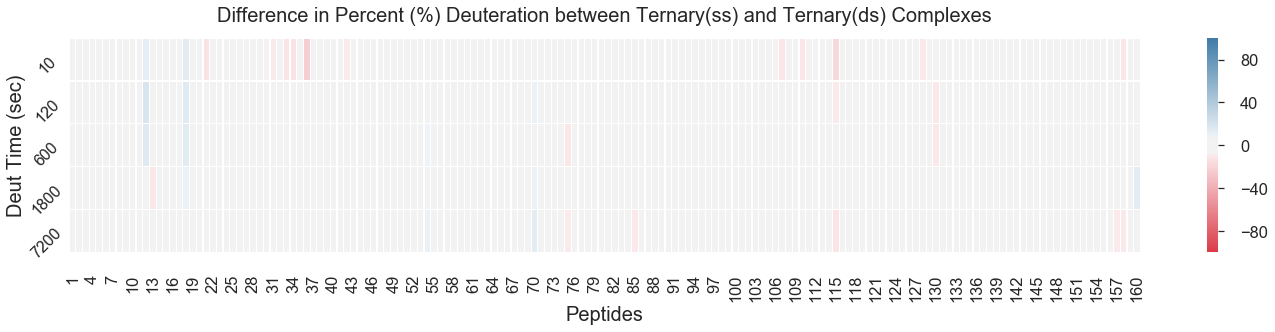

In [62]:
pl.heat_map(df, diff_state = ("Ternary(ss)", "Ternary(ds)"), peptides =None,
             domains=  None,figsize=(20,5), pdf= True, tiff= False)

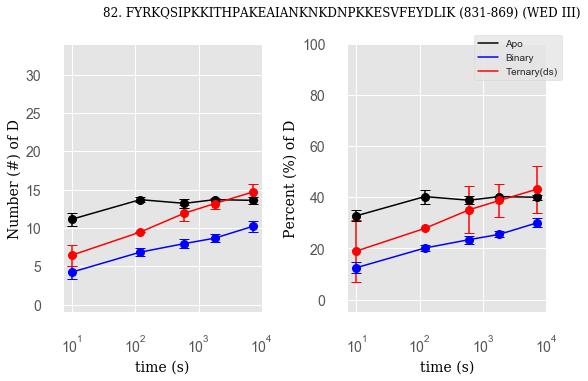

In [59]:
pl.uptake_plots(df, plot_states=["Apo", "Binary", "Ternary(ds)"], pep_class=[82] ,pdf=True,)

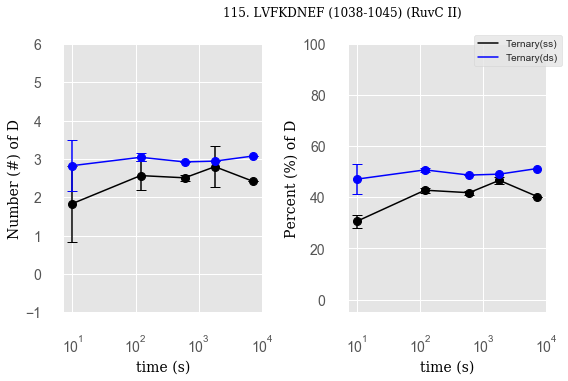

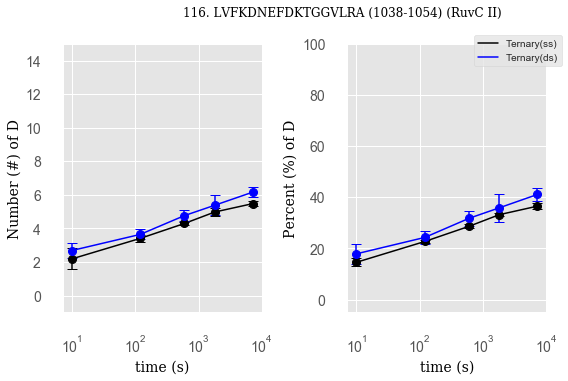

In [64]:
pl.uptake_plots(df, plot_states=["Ternary(ss)", "Ternary(ds)"], pep_class=[115,116] ,pdf=True,)

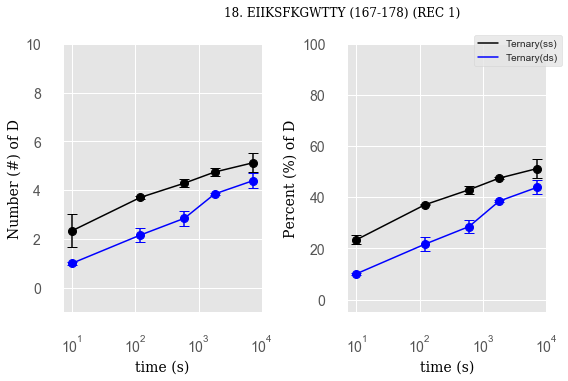

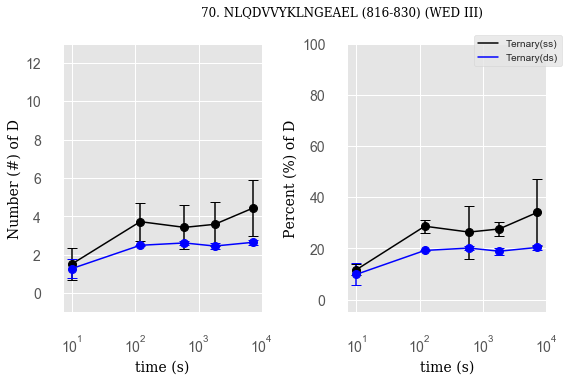

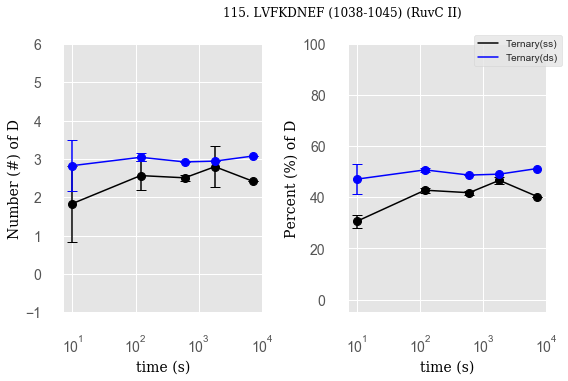

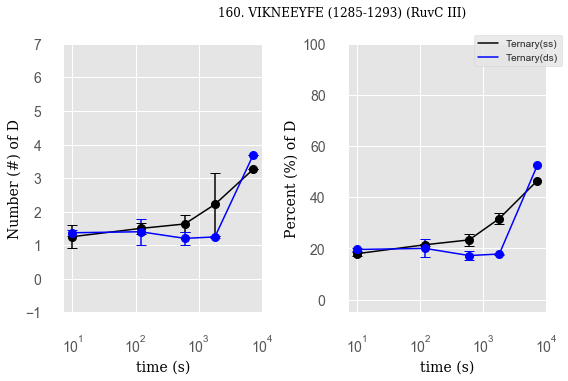

In [65]:
pl.uptake_plots(df, plot_states=["Ternary(ss)", "Ternary(ds)"], pep_class=[18,70,115,160] ,pdf=True,)

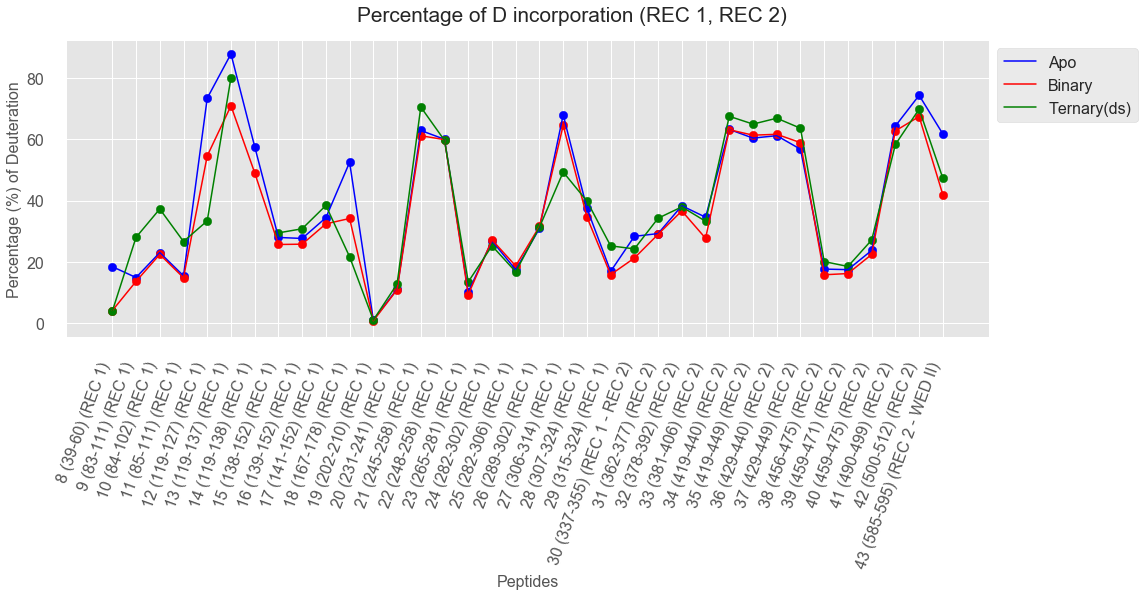

In [66]:

# scatter plots for a particular time point (2 min), Recongnition domain
pl.scatter_plot(df, domains = rec, states = ["Apo", "Binary", "Ternary(ds)"], timepoint = "t2",
                    figsize =(16,8), pdf = True)

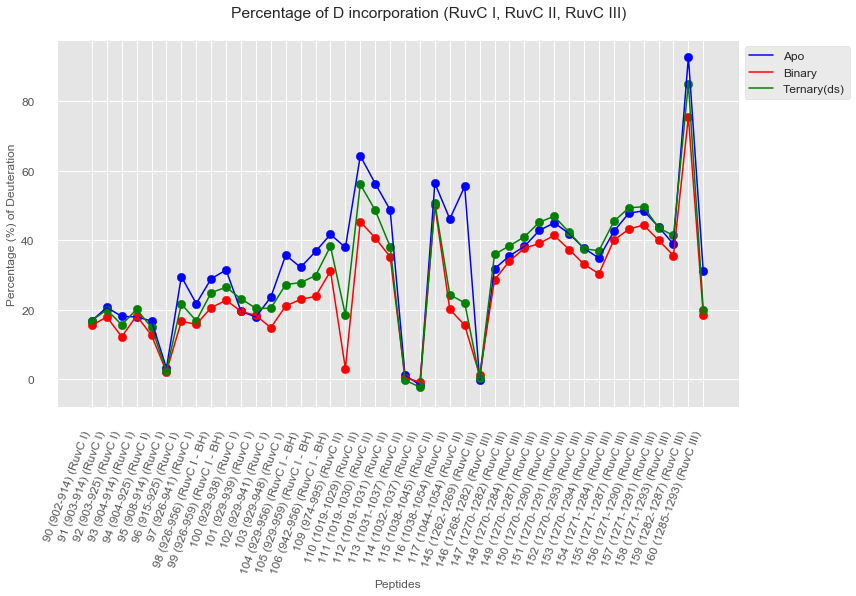

In [67]:
pl.scatter_plot(df, domains = ruvc, states = ["Apo", "Binary", "Ternary(ds)"], timepoint = "t2",
                    figsize =(12,8), pdf = True)

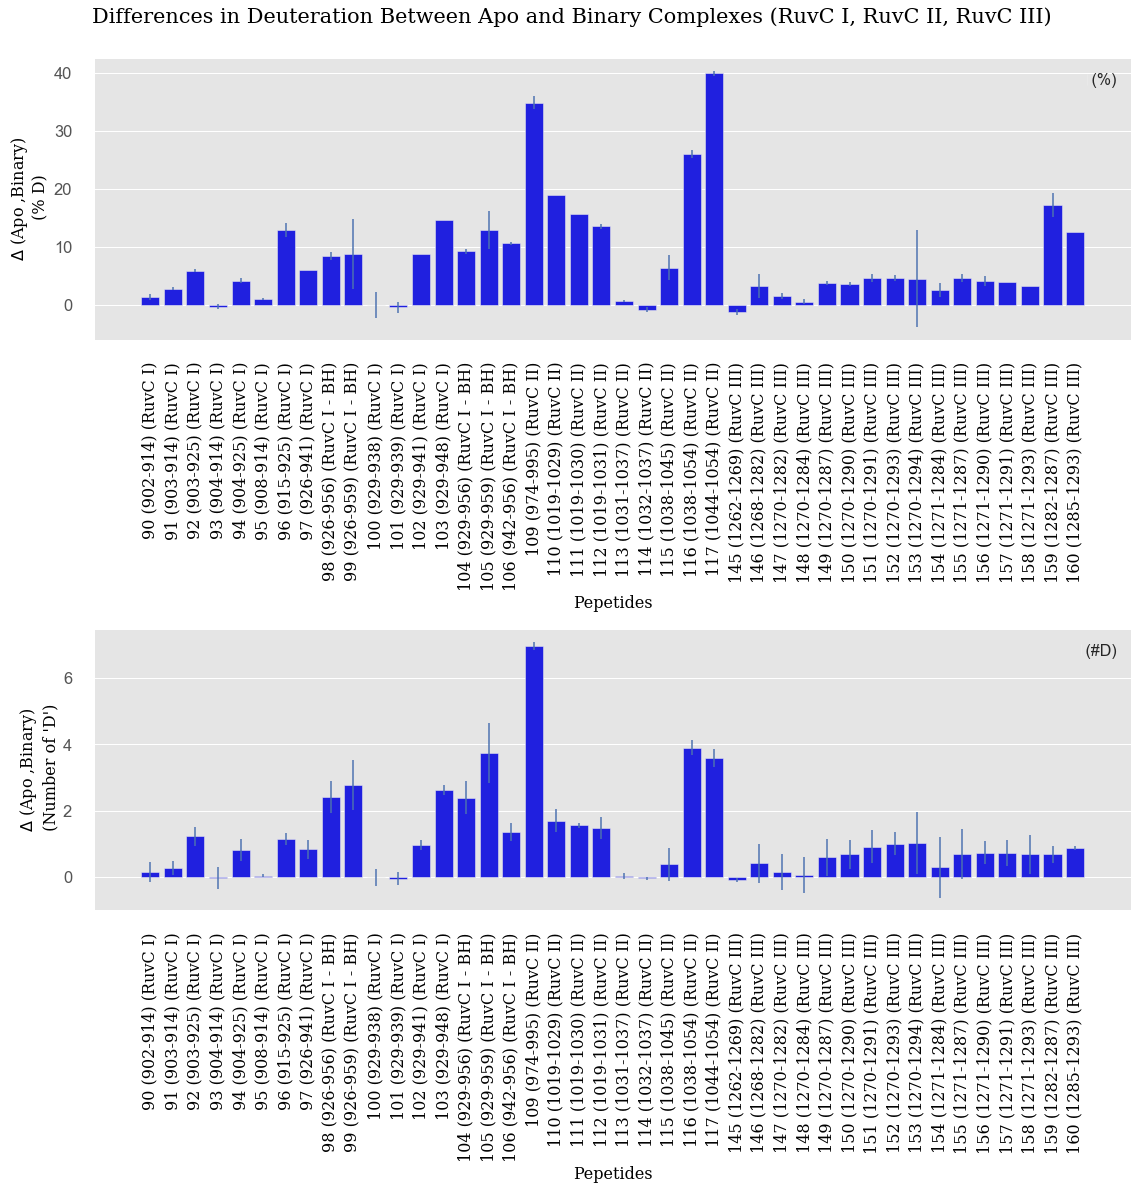

In [68]:
pl.barplots(df, timepoint="t2", domains= ruvc, diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = True, name = "ruvc_apo-binary_barplot", figsize=(16, 16))

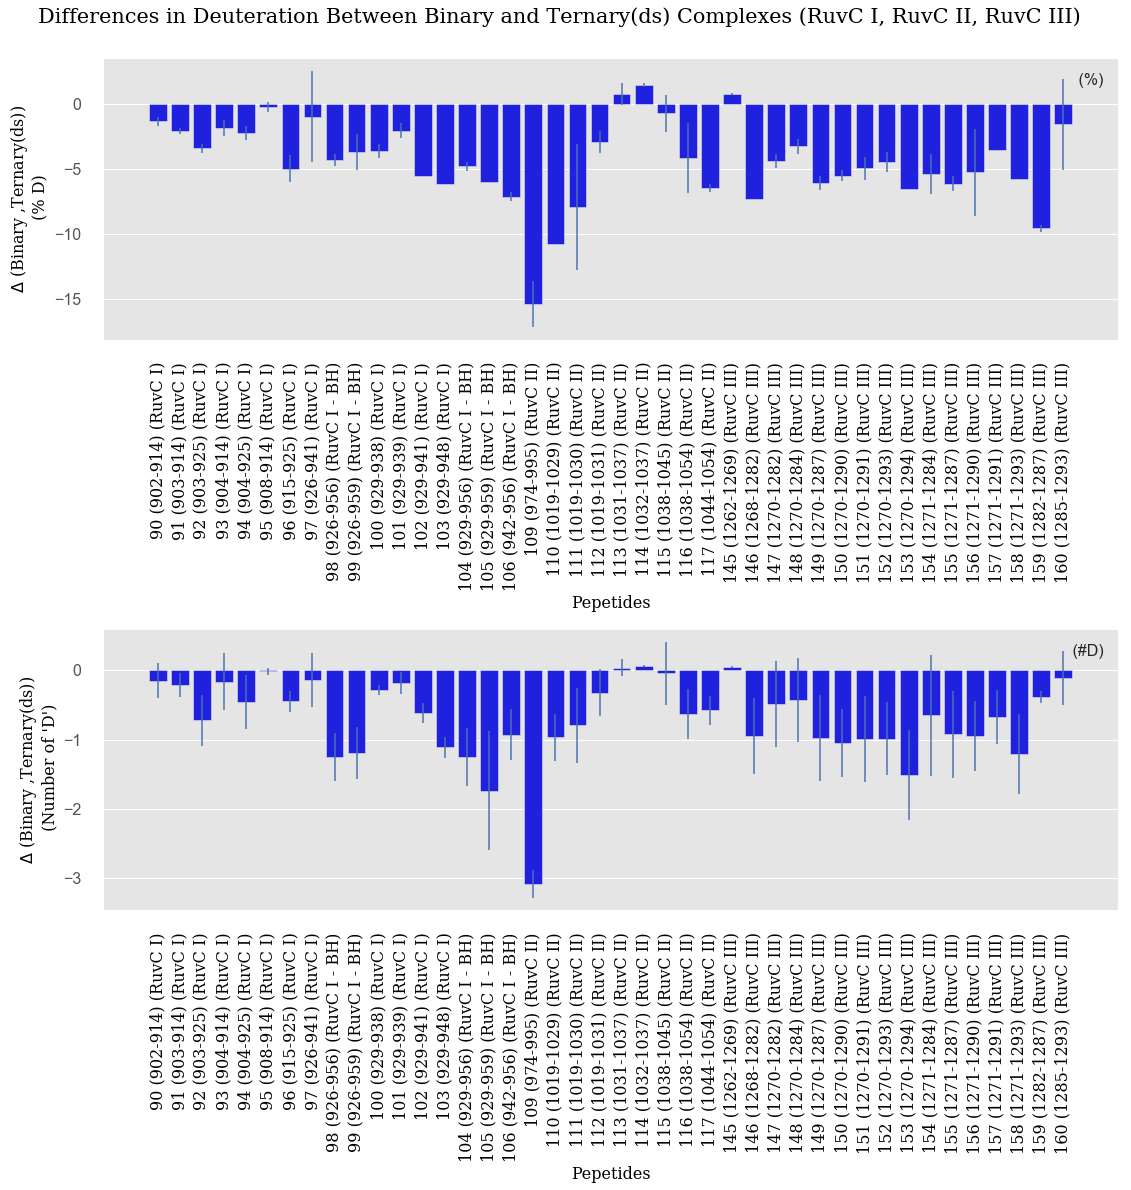

In [69]:
pl.barplots(df, timepoint="t2", domains= ruvc, diff_state=("Binary","Ternary(ds)"),
             pdf =True, error_bar = True, name = "ruvc_apo-ternary(ds)_barplot", figsize=(16, 16))

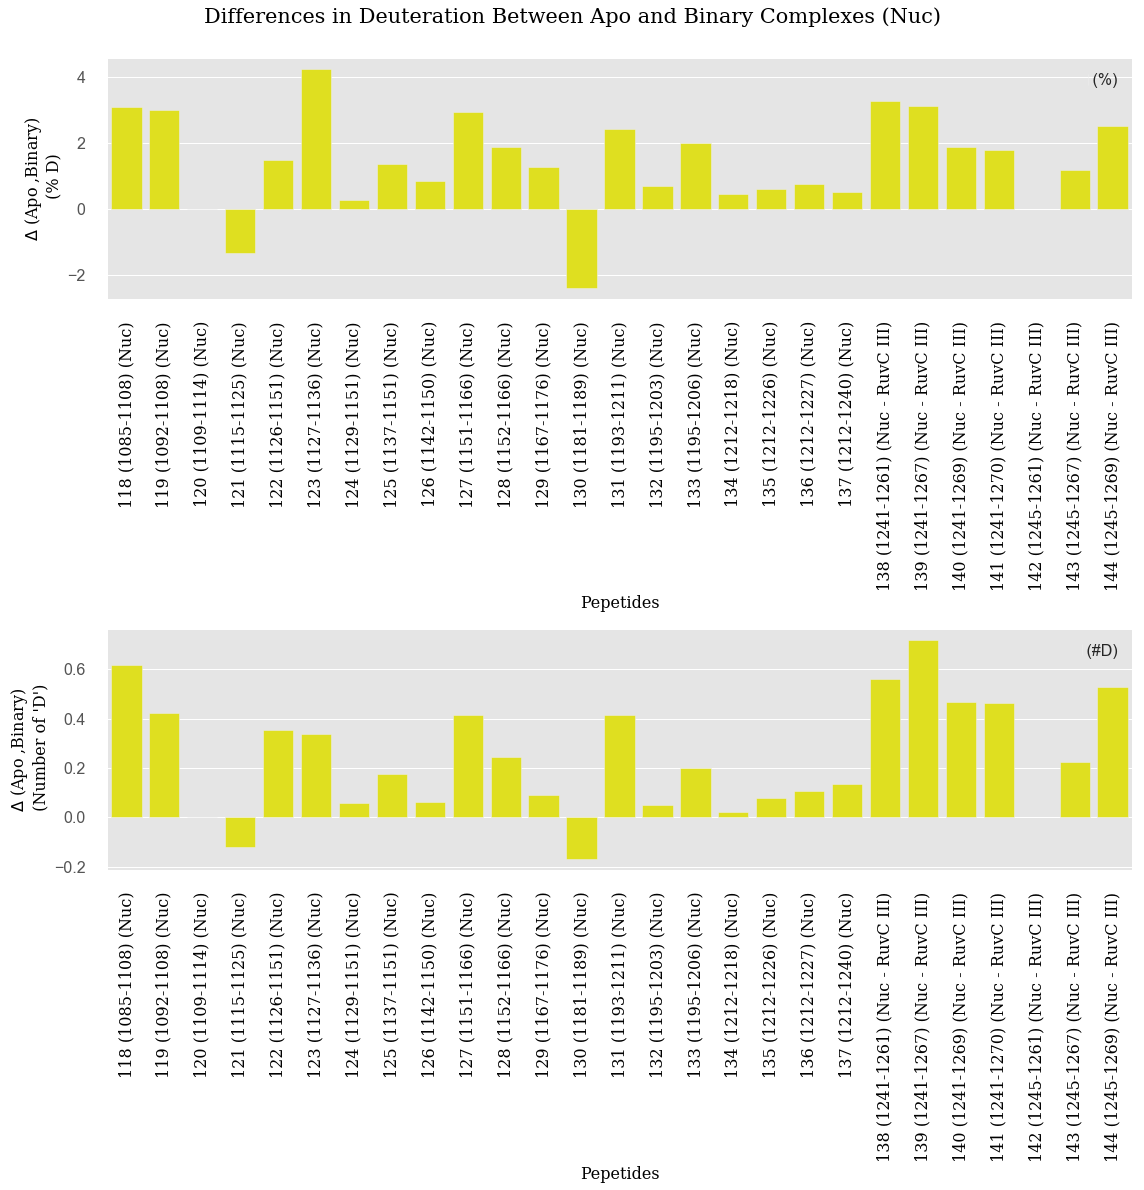

In [70]:
pl.barplots(df, timepoint="t2", domains= nuc, diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = False, name = "nuc_apo-binary_barplot", figsize=(16, 16))

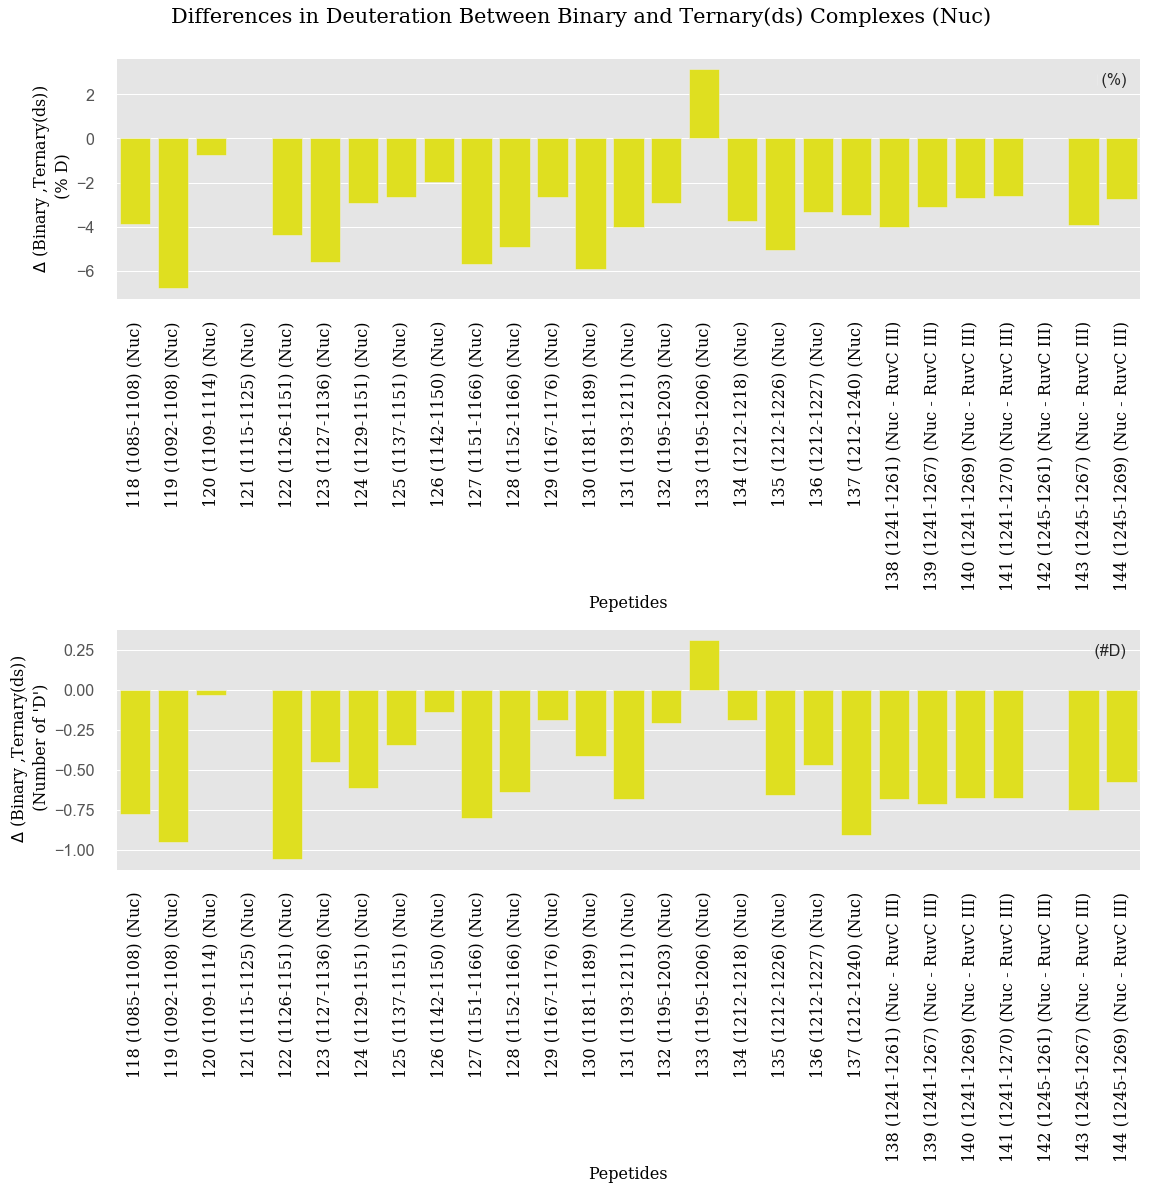

In [71]:
pl.barplots(df, timepoint="t2", domains= nuc, diff_state=( "Binary","Ternary(ds)"),
             pdf =True, error_bar = False, name = "nuc_binary_ternary(ds)_barplot", figsize=(16, 16))

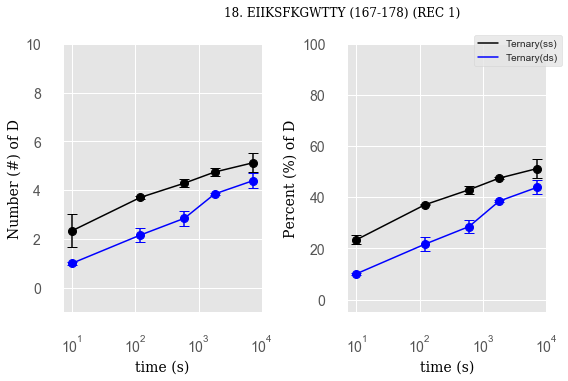

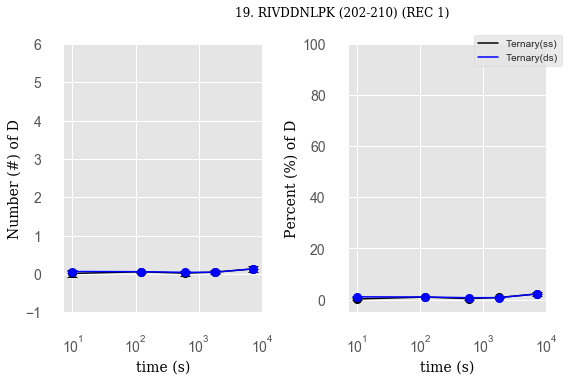

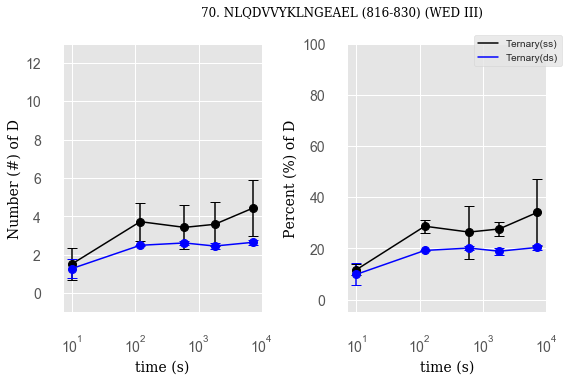

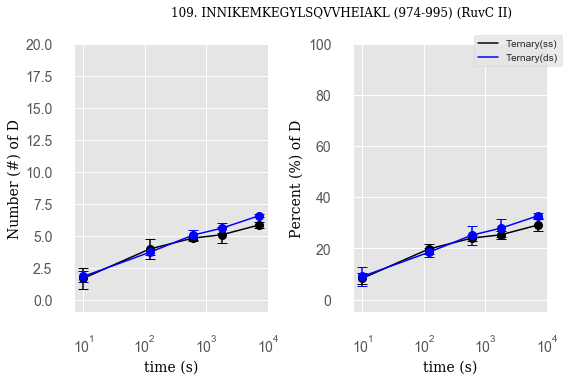

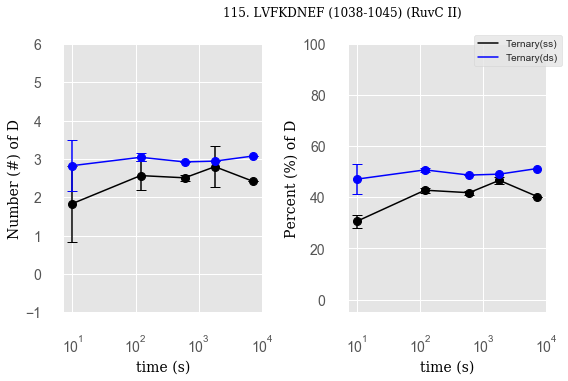

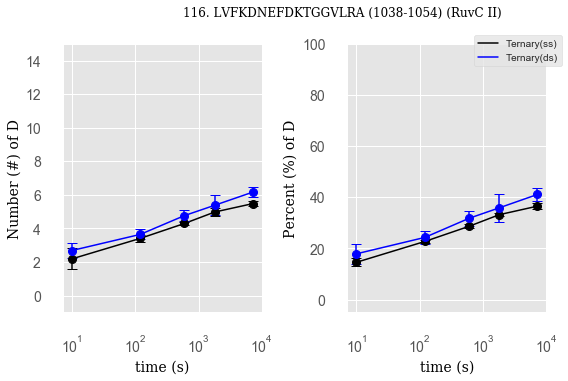

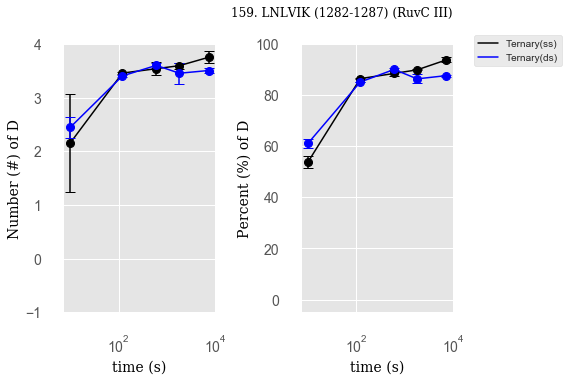

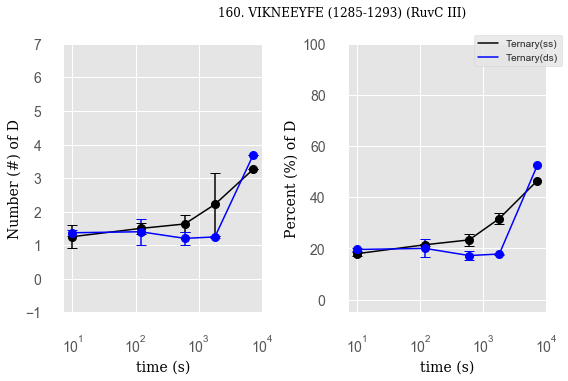

In [72]:
pl.uptake_plots(df, plot_states=["Ternary(ss)", "Ternary(ds)"], pep_class =[18,19,70,109,115,116,159,160] ,pdf = True )

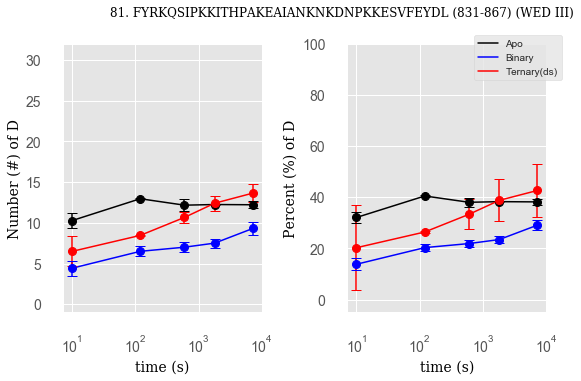

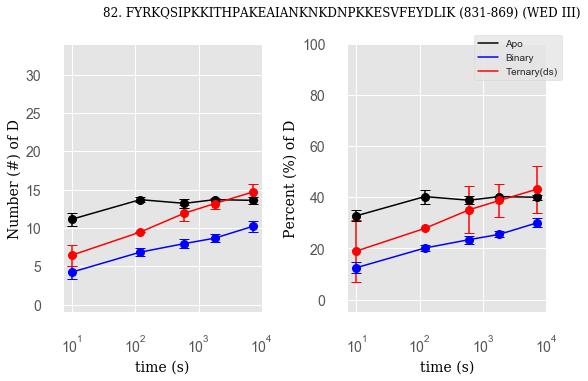

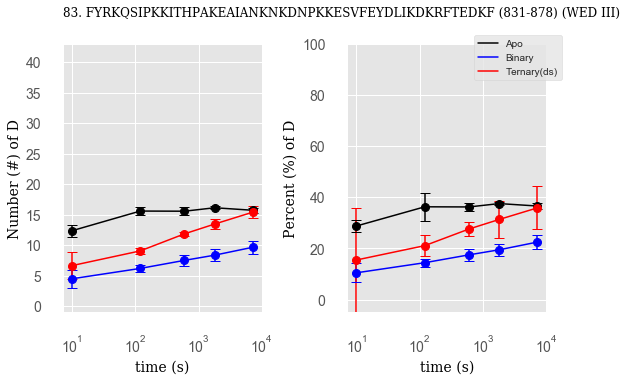

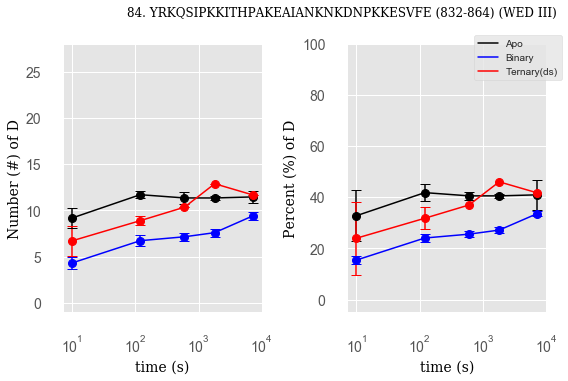

In [78]:
pl.uptake_plots(df, plot_states=["Apo", "Binary", "Ternary(ds)"], pep_class =[81,82,83,84], pdf = True )

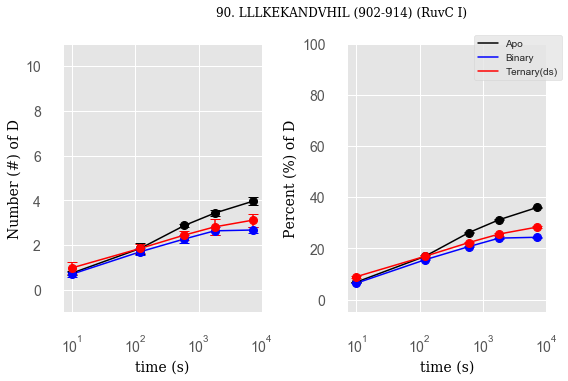

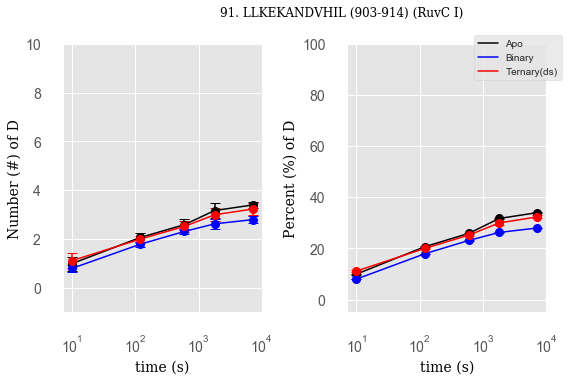

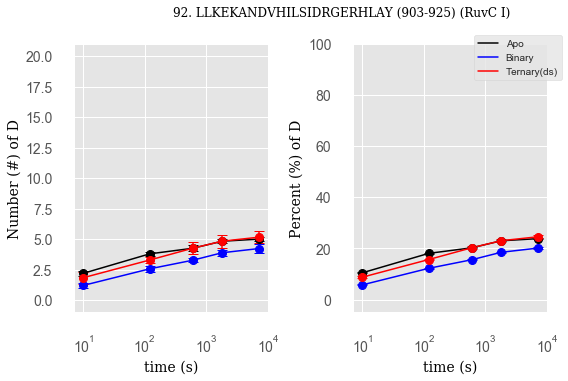

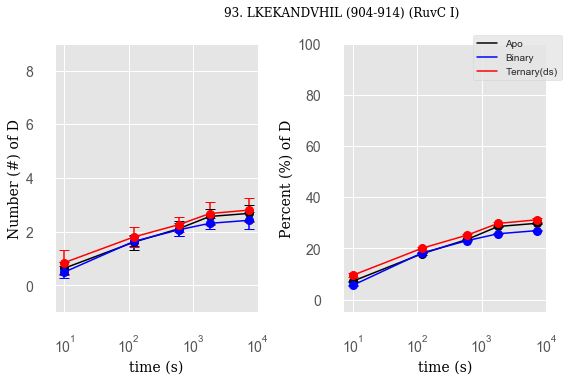

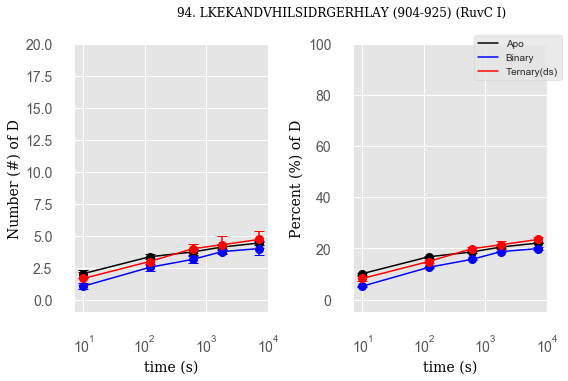

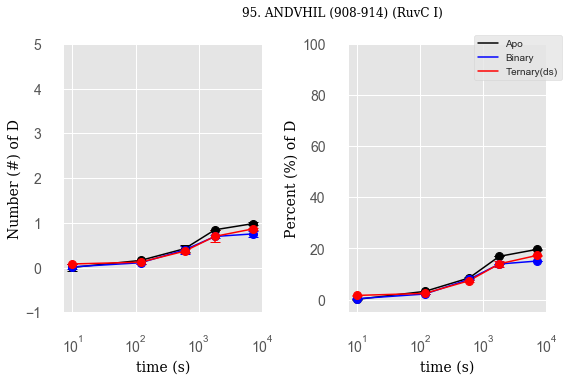

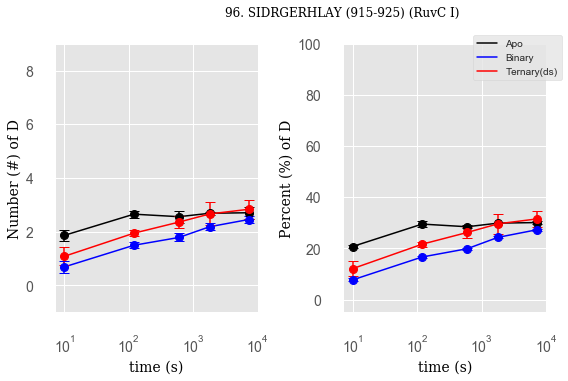

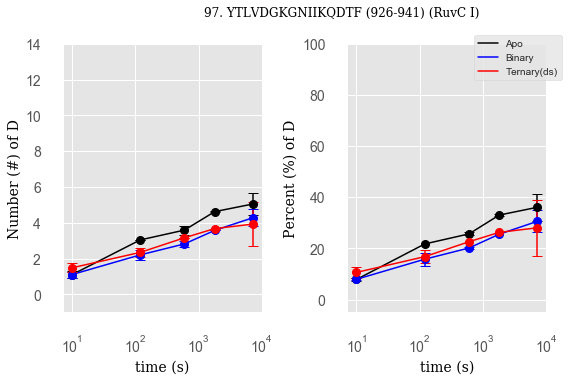

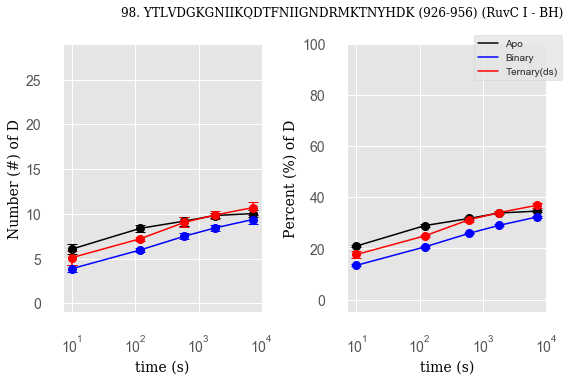

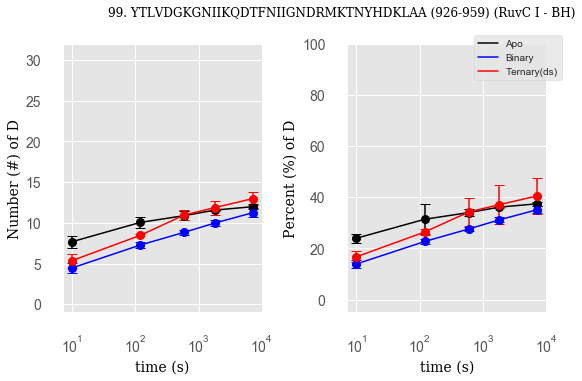

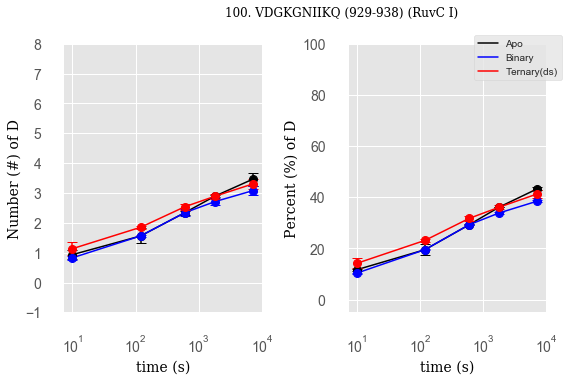

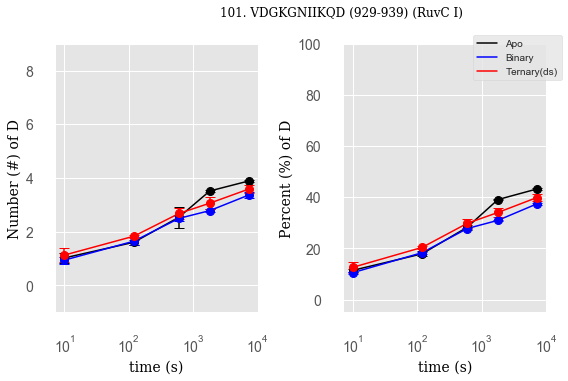

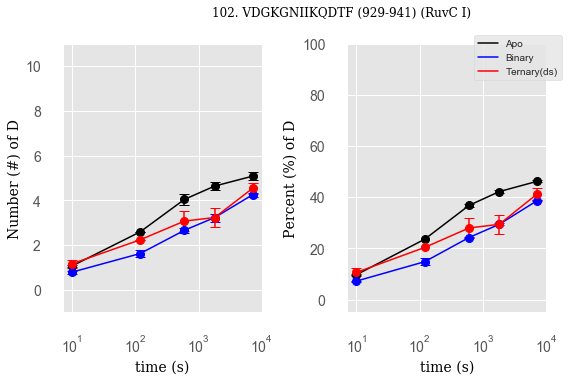

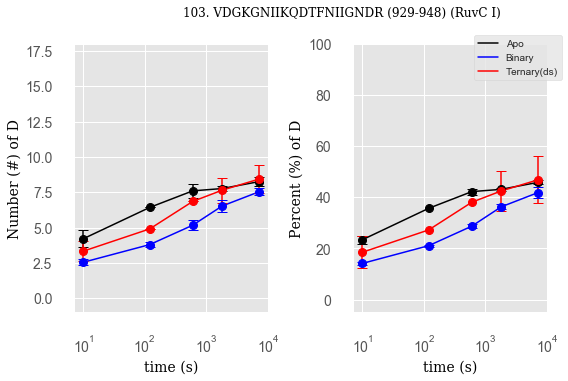

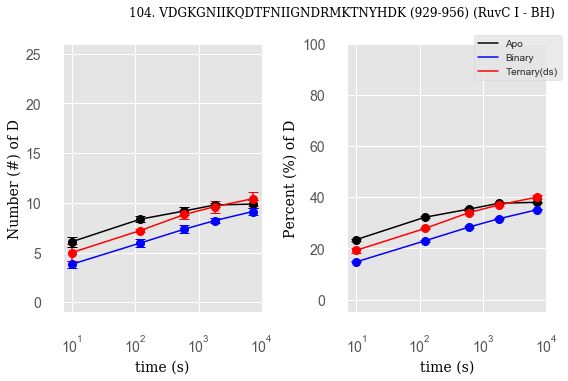

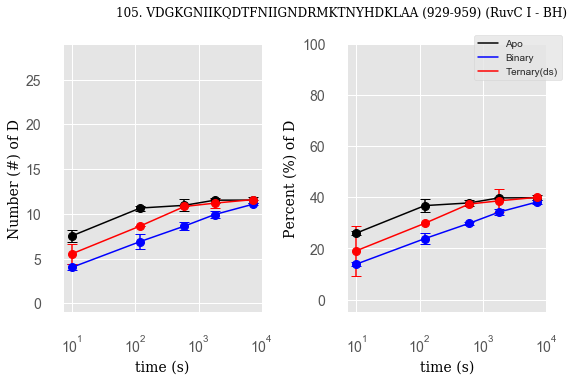

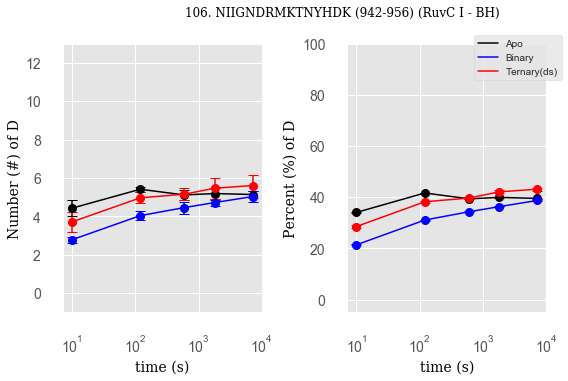

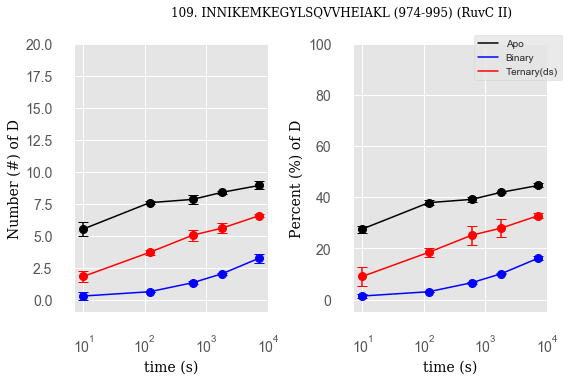

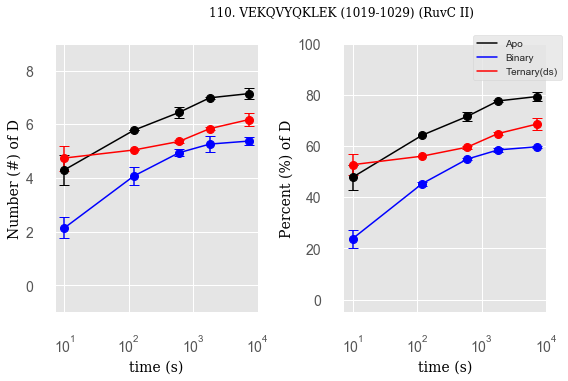

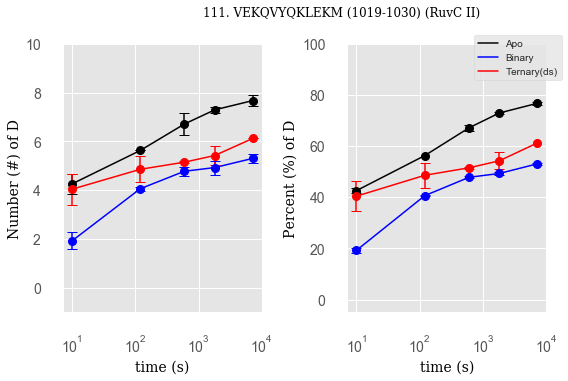

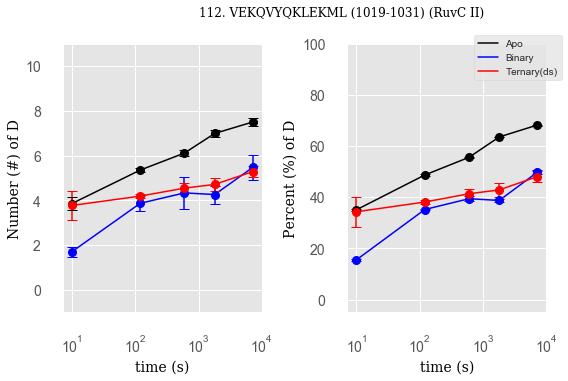

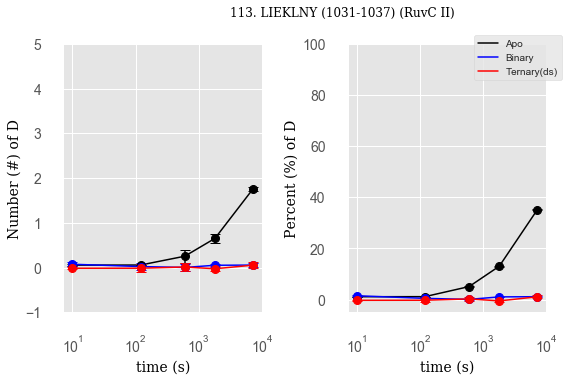

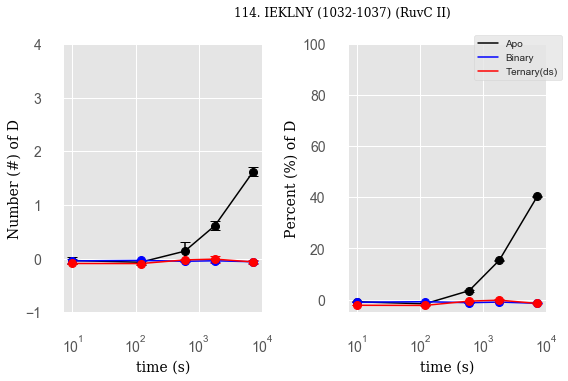

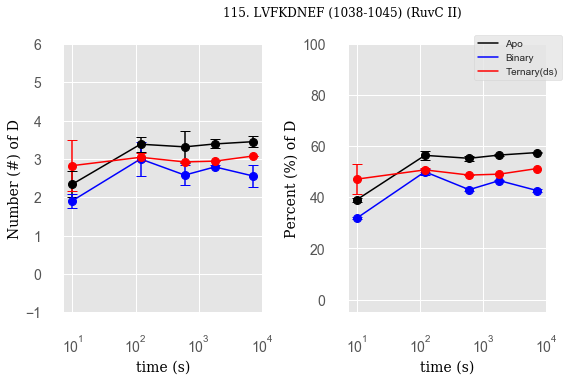

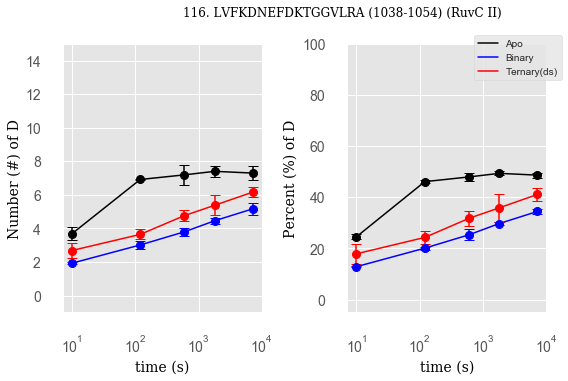

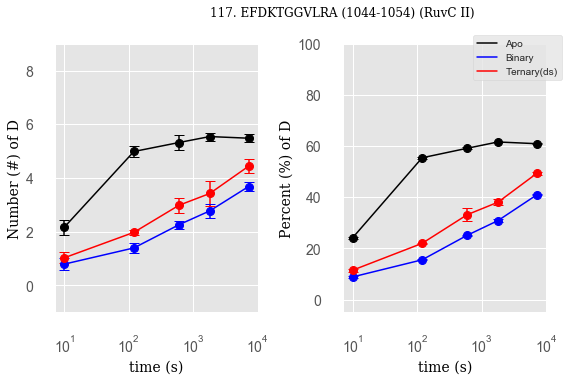

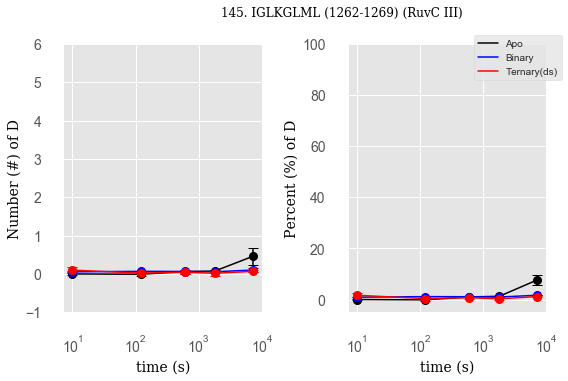

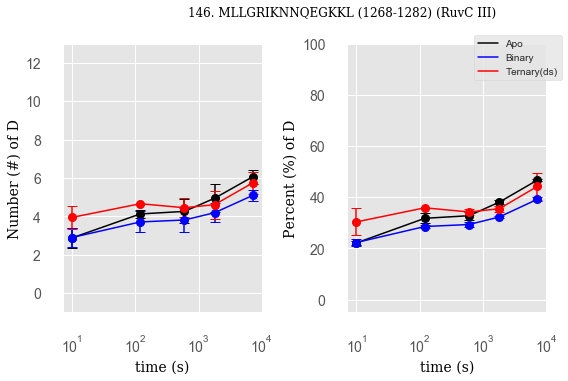

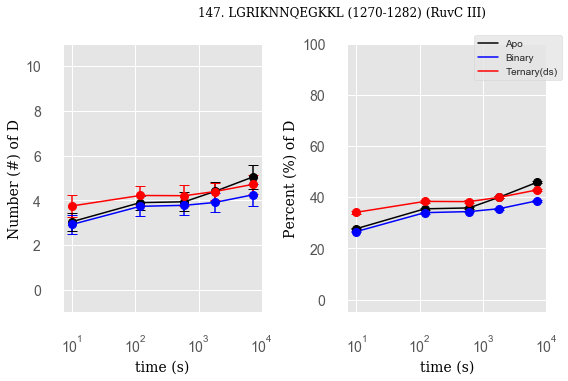

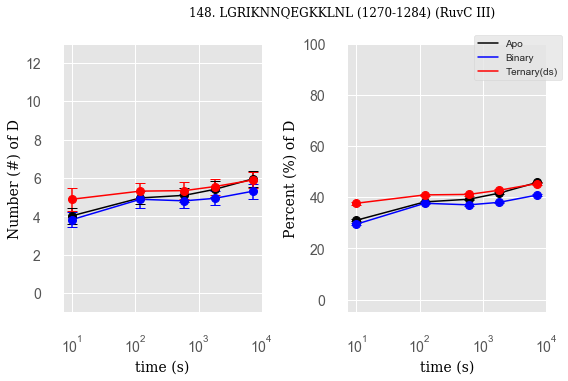

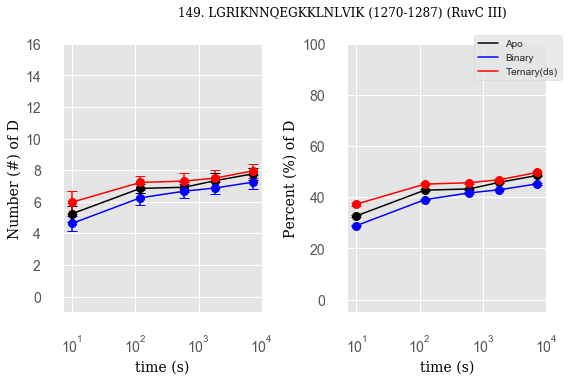

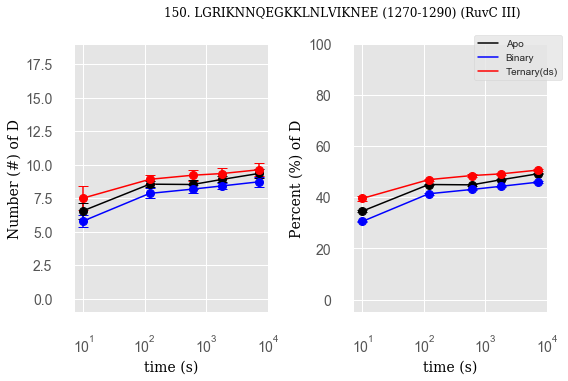

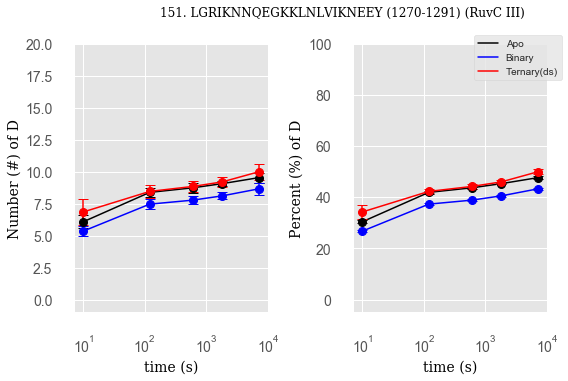

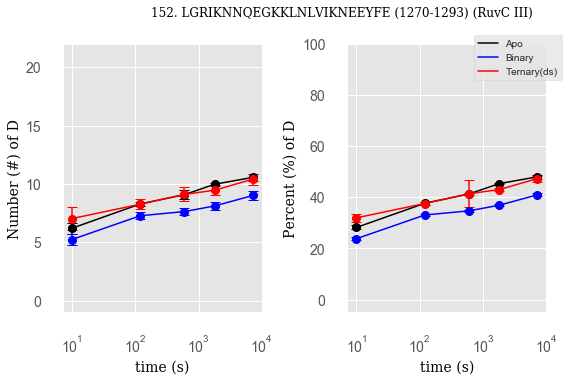

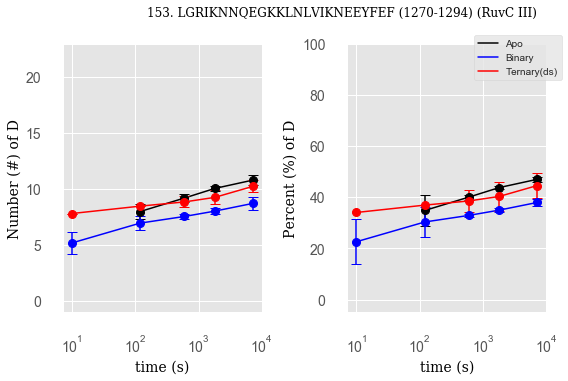

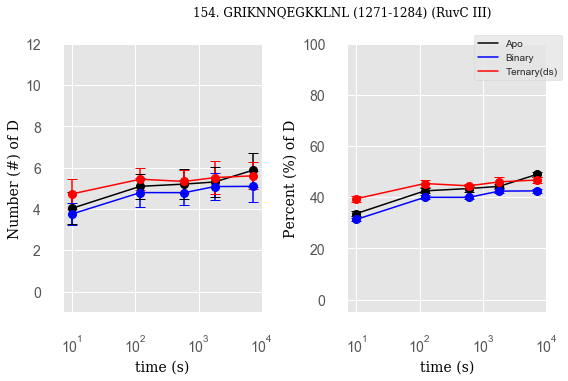

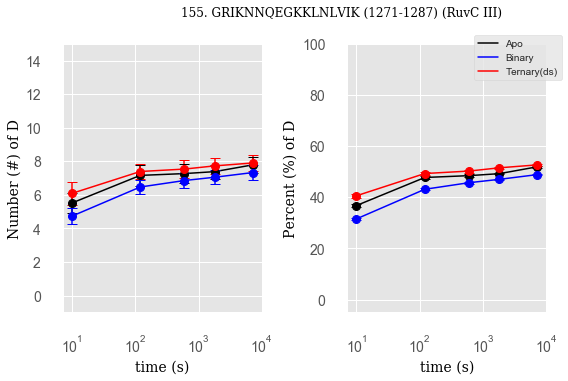

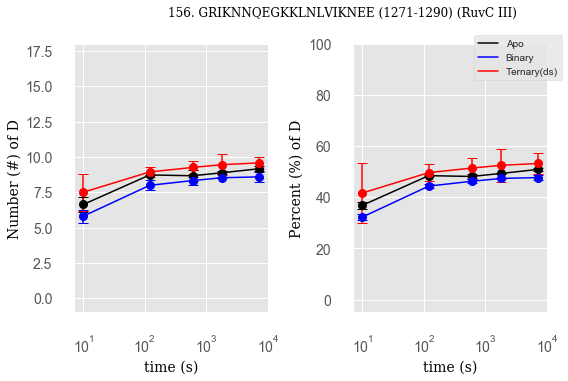

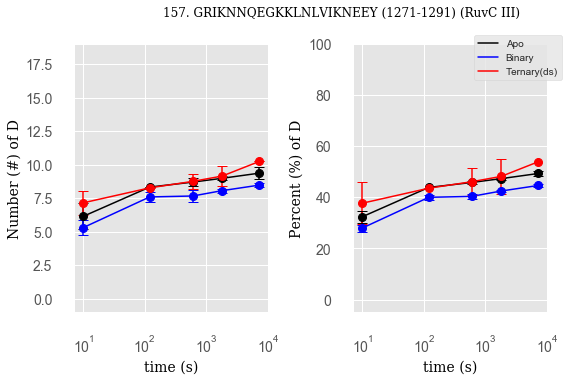

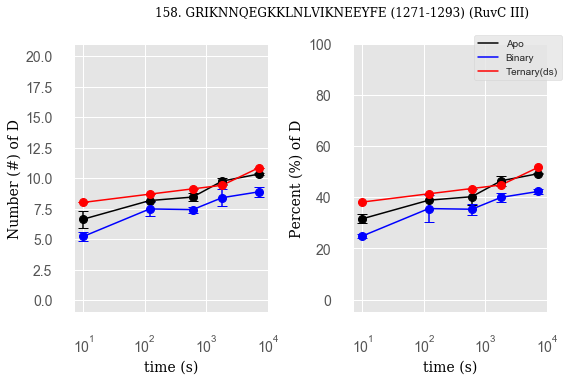

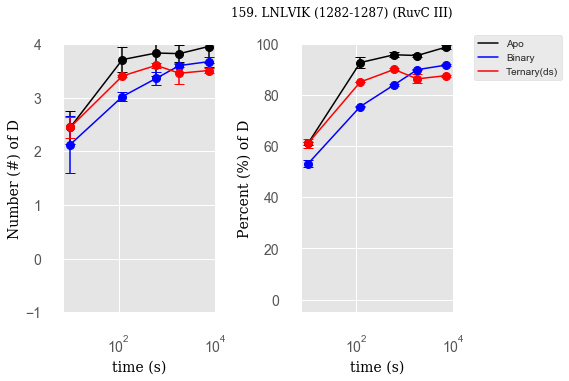

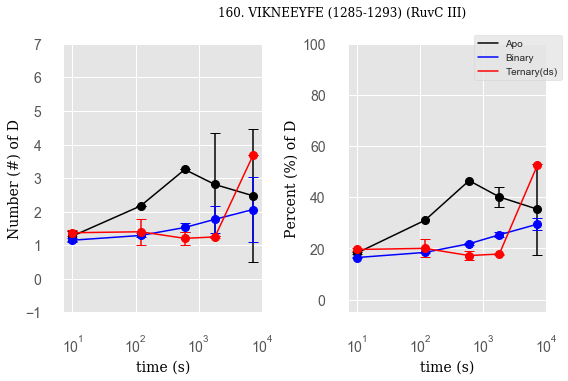

In [74]:
# significant peptides for the rec domain
rec_pep = [12,13,14,27,28,34,35,36,37,43]
pl.uptake_plots(df, plot_states=["Apo", "Binary", "Ternary(ds)"], domains=ruvc,  pdf = True )

In [75]:
#pep, idx = pl.pep_diff_sig_class(df, dstate=('Apo', "Binary"), st1_st2=True, er_da=2)
barplots(df, timepoint="t2", domains= rec, diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = False, name = "Barplot_rec(apo, binary)")

NameError: name 'barplots' is not defined

In [ ]:
#pep, idx = pl.pep_diff_sig_class(df, dstate=("Binary", "Ternary(ds)"), st1_st2=True, er_da=2)
barplots(df, timepoint="t2", domains= rec, diff_state=( "Binary", "Ternary(ds)"),
             pdf =True, error_bar = False, name = "Barplot_rec(binary, ternary(ds))")

In [ ]:
# Changes in REC domain
rec_apo_binary =  [8,12,13,14,15,18,30,33,42,43]
barplots(df, timepoint="t2", peptides = rec_apo_binary , diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = False, name = "Barplot_rec_sel_pep(apo, binary)", figsize=(8,10))

In [ ]:
rec_apo_binary =  [8,12,13,14,15,18,30,33,42,43]
barplots(df, timepoint="t2", peptides = rec_apo_binary , diff_state=( "Binary", "Ternary(ss)",),
             pdf =True, error_bar = False, name = "Barplots_ternary(apo, binary)", figsize=(8,10))

In [ ]:
pl.pep_map

In [ ]:
#pep, idx = pl.pep_diff_sig_class(df, dstate=('Apo', "Binary"), st1_st2=True, er_da=2)
barplots(df, timepoint="t2", domains= wedge, diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = False, name = "wedge_apo-binary_barplot")

In [ ]:

barplots(df, timepoint="t2", domains= wedge, diff_state=( "Binary", "Ternary(ds)"),
             pdf =True, error_bar = False, name = "wedge_binary-ternary(ds)_barplot")

In [ ]:
barplots(df, timepoint="t2",  diff_state=( "Apo", "Binary",),
            domains=rec,pdf =True, error_bar = False, name = "Barplots_ternary(apo,binary)")

In [ ]:
pep, idx = pl.pep_diff_sig_class(df, dstate=('Apo', "Binary"), st1_st2=True, er_da=2)
barplots(df, timepoint="t2", domains= rec, diff_state=( "Apo", "Binary",),
             pdf =True, error_bar = False, name = "Barplots_ternary(apo, binary)")

In [ ]:
pep, idx = pl.pep_diff_sig_class(df, dstate=('Binary', "Ternary(ss)"), st1_st2=True, er_da=0.1)
barplots(df, timepoint="t3", peptides =idx, diff_state=( "Binary", "Ternary(ss)",),
            domains=None,pdf =True, error_bar = True, name = "Barplots_ternary(ss,ds)")

In [ ]:
pep, idx = pl.pep_diff_sig_class(df, dstate=('Binary', "Ternary(ss)"), st1_st2=False, er_da=.01)
len(idx)
barplots(df, timepoint="t2", peptides= idx, diff_state=("Binary", "Ternary(ss)", ),
            domains=None,pdf =True, name = "Barplots_ternary(ss,ds)",figsize=(20, 25))

In [ ]:
pep, idx = pl.pep_diff_sig_class(df, dstate=( "Ternary(ss)",'Binary'), st1_st2=True, er_da=1)
len(idx)
barplots(df, timepoint="t3", peptides= idx, diff_state=("Binary", "Ternary(ss)" ),
            domains=None,pdf =True, name = "Barplots_ternary(ss,ds)",figsize=(20, 25))

In [ ]:
barplots(df, timepoint="t2", diff_state=("Binary", "Ternary(ss)", ),
            domains=ruvc+nuc,pdf =True, name = "Barplots_ternary(ss,ds)",figsize=(20, 25))

In [ ]:
pl.difference_plots(df, diff_states=("Ternary(ds)", "Ternary(ss)"), domains =ruvc,  pdf = True )

In [ ]:
pl.uptake_plots(df, plot_states=["Apo","Binary"],  pdf = True )

In [ ]:
pl.uptake_plots(df, plot_states=["Apo","Binary"], domains =bh )

In [ ]:
df.loc[15][['Start', 'End', 'Sequence', 'Deut Time (sec)', 'maxD', '#D_Apo',
       '%D_Apo', 'Conf Interval (#D)_Apo', '#Pts_Apo', 'Confidence_Apo',
       'Stddev_Apo', 'p_Apo', '#D_Binary', '%D_Binary',
       'Conf Interval (#D)_Binary', '#Pts_Binary', 'Confidence_Binary',
       'Stddev_Binary', 'p_Binary', '#D_Ternary(ss)', '%D_Ternary(ss)',
       'Conf Interval (#D)_Ternary(ss)', '#Pts_Ternary(ss)',
       'Confidence_Ternary(ss)', 'Stddev_Ternary(ss)', 'p_Ternary(ss)',
       '#D_Ternary(ds)', '%D_Ternary(ds)', 'Conf Interval (#D)_Ternary(ds)',
       '#Pts_Ternary(ds)', 'Confidence_Ternary(ds)', 'Stddev_Ternary(ds)',
       'p_Ternary(ds)']]

In [ ]:
hdx.domain

In [ ]:

barplots(df,diff_state=("Binary","Ternary(ds)"), timepoint = "t2", peptides = None,
             domains = ruvc, plot_style ="ggplot" ,
                 figsize =(20,20),error_bar =True, pdf=False, tiff = False,name ="Barplots")

In [ ]:
pl.barplots(df,diff_state=("Apo","Binary"), timepoint = "t2", peptides = None,
             domains = ruvc, plot_style ="ggplot" ,
                 figsize =(20,20),error_bar =True, pdf=True, tiff = False,name ="Barplots")

In [ ]:
barplots(df,diff_state=("Apo","Binary"), timepoint = "t2", peptides = None,
             domains = pi, plot_style ="ggplot" ,
                 figsize =(10,10),error_bar =True, pdf=False, tiff = False,name ="pi_Barplots")

In [ ]:
barplots(df,diff_state=("Binary", "Ternary(ss)"), timepoint = "t2", peptides = None,
             domains = pi, plot_style ="ggplot" ,
                 figsize =(10,10),error_bar =True, pdf=False, tiff = False,name ="pi_binary_ternary(ss)_Barplots")

In [ ]:
pl.uptake_plots(df, plot_states=['Apo', 'Binary', "Ternary(ss)", "Ternary(ds)"], domains=pi, pep_no=None, pep_class=None, pdf=False, tiff=False)

In [ ]:
barplots(df,diff_state=("Ternary(ss)", "Binary"), time_points = ["t2", "t4"],  plot_kind = "D", peptides = idx,
             domains = ["Rec 1","Rec 2" ], plot_style ="ggplot" ,
                 figsize =(20,20), pdf=False, tiff = False,name ="Barplots")

In [ ]:
barplots(df,diff_state=("Apo", "Binary"), timepoints = ["t2", "t4"],  plot_kind = "percent", peptides = idx,
             domains = ["Rec 1","Rec 2" ], plot_style ="ggplot" ,
                 figsize =(20,20), pdf=False, tiff = False,name ="Barplots")

In [ ]:
barplots(processed_hdx_files,diff_state=("Ternary(ss)", "Binary"), timepoints = ["t2", "t4"],  plot_kind = "percent", peptides = idx,
             domains = ["Rec 1","Rec 2" ], plot_style ="ggplot" ,
                 figsize =(20,20), pdf=False, tiff = False,name ="Barplots")

In [ ]:
processed_hdx_files.loc[[120,122]]

In [ ]:
idx_domain=[]
for domain in ["RuvC I", "RuvC II"]:
    domain_lists = processed_hdx_files.loc[processed_hdx_files['domains_start']== domain].index.unique().tolist()
    idx_domain.extend(domain_lists)
    

idx_domains

In [ ]:
processed_hdx_files.columns

In [ ]:
processed_hdx_files[['Apo_Ternary(ds)_%D', 'Binary_Apo', 'Binary_Apo_%D',
       'Binary_Ternary(ss)', 'Binary_Ternary(ss)_%D']]

In [ ]:
# I am calling cal_diff function
processed_hdx_files = pl.cal_diff()

In [ ]:
peptides_to_drop = [3,10,20,21,22,24,27,29,32,43,50,54,
                59,69,76,85,86,89,90,97,110,115,116,122,
                123,134,138,140,149,152,157,159,165,
                176,194]
processed_hdx_files = processed_hdx_files.drop(peptides_to_drop)

In [ ]:
# scatter plots for a particular time point (2 hrs) 
pl.scatter_plot(processed_hdx_files, domains = domains_cas12a[:3], states = states_list, timepoint = "t5",
                    figsize =(20,15), tiff = True)

In [ ]:
# scatter plots for a particular time point (2 hrs) 
pl.scatter_plot(processed_hdx_files, domains = domains_cas12a[3:6], states = states_list, timepoint = "t5",
                    figsize =(20,15), tiff = True)

In [ ]:
# scatter plots for a particular time point (2 hrs) 
pl.scatter_plot(processed_hdx_files, domains = domains_cas12a[6:10], states = states_list, timepoint = "t5",
                    figsize =(20,15), tiff = True)

In [ ]:

pl.bubble_plot(domains =domains[:6], state ="Binary",
                figsize =(20,12), plot_style = 'ggplot', pdf= False, tiff= True)

In [ ]:
pl.bubble_plot(domains =domains[6:], state ="Binary",
                figsize =(20,12), plot_style = 'ggplot', pdf= False, tiff= True)

In [ ]:
pl.bubble_plot(cf, domains =["RuvC I", "RuvC II", "RuvC III"], state ="Binary",
                figsize =(14,12), plot_style = 'ggplot', pdf= False, tiff= True)

In [ ]:
processed_hdx_files.loc[idx, ["color", "domains_start", ]]

In [ ]:
pep, idx = pl.pep_diff_sig_class(processed_hdx_files, dstate=('Binary', "Ternary(ds)"), st1_st2=True, er_da=0.01)
len(idx)
pl.barplots(processed_hdx_files, time_points=[120, 7200], pep_class=None, dstate=('Binary', "Ternary(ds)"),
            yaxis='percent', domains=["RuvC"], pdf =True, name = "Barplots_ternary(ss,ds)")

In [ ]:
pep, idx = pl.pep_diff_sig_class(processed_hdx_files, dstate=('Binary', "Ternary(ds)"), st1_st2=True, er_da=0.01)
len(idx)
pl.barplots(processed_hdx_files, time_points=[7200, 120], pep_class=idx, dstate=('Binary', "Ternary(ds)"),
            domains=None, pdf =True, name = "Barplots_ternary(ss,ds)"),

In [ ]:
pl.uptake_plots(processed_hdx_files, plot_states=["Apo",'Binary', "Ternary(ss)", "Ternary(ds)"], pep_class = idx, pdf = True )

In [ ]:
pl.uptake_plots(processed_hdx_files, plot_states=["Apo",'Binary', "Ternary(ss)", "Ternary(ds)"],pdf = True )

In [ ]:
pl.difference_plots(cf, diff_states=( "Ternary(ss)", "Ternary(ds)"), pep_class = idx, pdf = True )

In [ ]:
cf = pl.cal_diff().drop([3,10,20,21,22,24,27,29,32,43,50,54,59,69,76,85,86,89,90,97,110,115,116,123,134,138,140,149,152,157,159,165,176,194])

In [ ]:
100000*0.0001

In [ ]:
pl.barplots(time_points=[7200, 120], pep_class=idx, dstate=("Binary", "Ternary"),figsize = (15,10),
            domains=None, pdf = True, name ="Barplots_Binary_Ternary")

In [ ]:
domains = list(pl.pep_map.keys())
pl.scatter_plot(domains =domains[6:], states =["Apo", "Binary", "Ternary"], timepoint = "t4",
                    figsize =(25,16), tiff = True)

In [ ]:
pl.scatter_plot(domains =["RuvC I", "RuvC II", ], states =["Apo", "Binary", "Ternary"], timepoint = "t4",
                    figsize =(14,12), tiff =True)

In [ ]:
pl.scatter_plot(domains =["REC 1", "REC 2"], states =["Apo", "Binary", "Ternary"], timepoint = "t3",
                    figsize =(14,12), tiff = True)

In [ ]:
pl.scatter_plot(domains =["RuvC I", "RuvC II", "RuvC III"], states =["Binary", "Ternary"], timepoint = "t5",
                    figsize =(14,12), tiff = True)

In [ ]:
peptides, indexes =pl.pep_diff_sig_class(dstate=('Apo', 'Binary'), st1_st2=True, er_da=1)
peptides[:10]

In [ ]:
pl.uptake_plots(plot_states=["Apo",'Binary', "Ternary"], pep_no = [138,139,140,141,117,118,119,120,121,122,123,124,125,176,177,178,179], pdf = False)

In [ ]:
pl.difference_plots(diff_states=("Apo",'Ternary'), pep_no = [138,139,140,141,117,118,119,120,121,122,123,124,125,176,177,178,179], pdf = True)

In [ ]:
pl.uptake_plots(cf, plot_states=["Apo",'Binary', "Ternary(ss)", "Ternary(ds)"], pdf = True )

In [ ]:
pl.difference_plots(diff_states=('Apo', 'Binary'), pep_class = idx)
